## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 614)
Hypercube shape: (512, 614, 176)


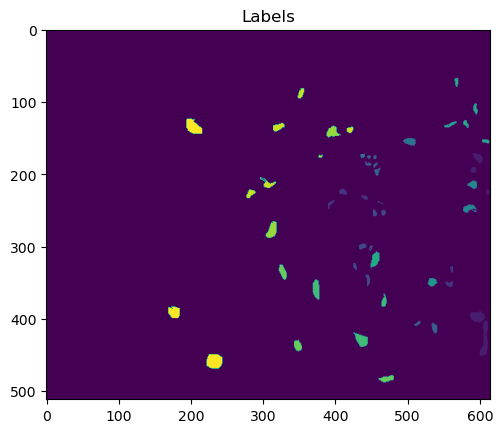

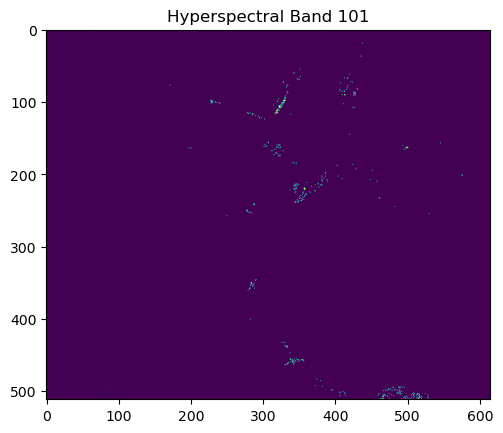

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'KSC_gt.mat'
data_files = 'KSC.mat'
label_files = 'KSC_gt'
hypercube_files = 'KSC'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 5211
Extracted windows shape: (5211, 5, 5, 176)
Corresponding labels shape: (5211,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 761 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 243 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 256 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 252 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 161 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 229 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 105 samples
Shuffled class indices for class '7'
Sele


All datasets saved to the 'indices' folder.
(260, 5, 5, 176)
(65, 5, 5, 176)
(4886, 5, 5, 176)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 260
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (4168, 5, 5, 176)
Validation data shape: (1043, 5, 5, 176)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

176


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/66], Loss: 0.2520, PSNR: 5.9862


Epoch [1/50] Training Loss: 0.2415, PSNR: 6.1734
	[Val]   Batch [1/17] Loss: 0.2287, PSNR: 6.4065
	[Val]   Batch [10/17] Loss: 0.2291, PSNR: 6.3990
Epoch [1/50] Validation Loss: 0.2289, PSNR: 6.4031

LOG: Epoch [2/50]
	 Training Batch [1/66], Loss: 0.2230, PSNR: 6.5169


Epoch [2/50] Training Loss: 0.2063, PSNR: 6.8616
	[Val]   Batch [1/17] Loss: 0.1827, PSNR: 7.3815
	[Val]   Batch [10/17] Loss: 0.1845, PSNR: 7.3403
Epoch [2/50] Validation Loss: 0.1839, PSNR: 7.3553

LOG: Epoch [3/50]
	 Training Batch [1/66], Loss: 0.1826, PSNR: 7.3858


Epoch [3/50] Training Loss: 0.1684, PSNR: 7.7440
	[Val]   Batch [1/17] Loss: 0.1465, PSNR: 8.3425
	[Val]   Batch [10/17] Loss: 0.1497, PSNR: 8.2486
Epoch [3/50] Validation Loss: 0.1488, PSNR: 8.2732

LOG: Epoch [4/50]
	 Training Batch [1/66], Loss: 0.1476, PSNR: 8.3091


Epoch [4/50] Training Loss: 0.1355, PSNR: 8.6898
	[Val]   Batch [1/17] Loss: 0.1179, PSNR: 9.2867
	[Val]   Batch [10/17] Loss: 0.1190, PSNR: 9.2463
Epoch [4/50] Validation Loss: 0.1186, PSNR: 9.2578

LOG: Epoch [5/50]
	 Training Batch [1/66], Loss: 0.1180, PSNR: 9.2829


Epoch [5/50] Training Loss: 0.1078, PSNR: 9.6813
	[Val]   Batch [1/17] Loss: 0.0956, PSNR: 10.1944
	[Val]   Batch [10/17] Loss: 0.0973, PSNR: 10.1210
Epoch [5/50] Validation Loss: 0.0968, PSNR: 10.1426

LOG: Epoch [6/50]
	 Training Batch [1/66], Loss: 0.0933, PSNR: 10.3000


Epoch [6/50] Training Loss: 0.0857, PSNR: 10.6787
	[Val]   Batch [1/17] Loss: 0.0773, PSNR: 11.1200
	[Val]   Batch [10/17] Loss: 0.0780, PSNR: 11.0772
Epoch [6/50] Validation Loss: 0.0778, PSNR: 11.0920

LOG: Epoch [7/50]
	 Training Batch [1/66], Loss: 0.0750, PSNR: 11.2490


Epoch [7/50] Training Loss: 0.0689, PSNR: 11.6263
	[Val]   Batch [1/17] Loss: 0.0615, PSNR: 12.1123
	[Val]   Batch [10/17] Loss: 0.0618, PSNR: 12.0915
Epoch [7/50] Validation Loss: 0.0617, PSNR: 12.0979

LOG: Epoch [8/50]
	 Training Batch [1/66], Loss: 0.0609, PSNR: 12.1572


Epoch [8/50] Training Loss: 0.0562, PSNR: 12.5102
	[Val]   Batch [1/17] Loss: 0.0521, PSNR: 12.8298
	[Val]   Batch [10/17] Loss: 0.0527, PSNR: 12.7859
Epoch [8/50] Validation Loss: 0.0525, PSNR: 12.7977

LOG: Epoch [9/50]
	 Training Batch [1/66], Loss: 0.0504, PSNR: 12.9757


Epoch [9/50] Training Loss: 0.0466, PSNR: 13.3208
	[Val]   Batch [1/17] Loss: 0.0434, PSNR: 13.6241
	[Val]   Batch [10/17] Loss: 0.0438, PSNR: 13.5885
Epoch [9/50] Validation Loss: 0.0437, PSNR: 13.5992

LOG: Epoch [10/50]
	 Training Batch [1/66], Loss: 0.0420, PSNR: 13.7678


Epoch [10/50] Training Loss: 0.0392, PSNR: 14.0695
	[Val]   Batch [1/17] Loss: 0.0364, PSNR: 14.3831
	[Val]   Batch [10/17] Loss: 0.0369, PSNR: 14.3352
Epoch [10/50] Validation Loss: 0.0367, PSNR: 14.3480

LOG: Epoch [11/50]
	 Training Batch [1/66], Loss: 0.0354, PSNR: 14.5131


Epoch [11/50] Training Loss: 0.0336, PSNR: 14.0615
	[Val]   Batch [1/17] Loss: 0.0322, PSNR: 14.9198
	[Val]   Batch [10/17] Loss: 0.0327, PSNR: 14.8554
Epoch [11/50] Validation Loss: 0.0326, PSNR: 14.8735

LOG: Epoch [12/50]
	 Training Batch [1/66], Loss: 0.0306, PSNR: 15.1473


Epoch [12/50] Training Loss: 0.0291, PSNR: 15.3712
	[Val]   Batch [1/17] Loss: 0.0278, PSNR: 15.5634
	[Val]   Batch [10/17] Loss: 0.0278, PSNR: 15.5581
Epoch [12/50] Validation Loss: 0.0278, PSNR: 15.5610

LOG: Epoch [13/50]
	 Training Batch [1/66], Loss: 0.0269, PSNR: 15.6944


Epoch [13/50] Training Loss: 0.0255, PSNR: 15.2581
	[Val]   Batch [1/17] Loss: 0.0243, PSNR: 16.1361
	[Val]   Batch [10/17] Loss: 0.0246, PSNR: 16.0899
Epoch [13/50] Validation Loss: 0.0245, PSNR: 16.1026

LOG: Epoch [14/50]
	 Training Batch [1/66], Loss: 0.0234, PSNR: 16.3167


Epoch [14/50] Training Loss: 0.0225, PSNR: 16.4721
	[Val]   Batch [1/17] Loss: 0.0218, PSNR: 16.6218
	[Val]   Batch [10/17] Loss: 0.0220, PSNR: 16.5836
Epoch [14/50] Validation Loss: 0.0219, PSNR: 16.5921

LOG: Epoch [15/50]
	 Training Batch [1/66], Loss: 0.0209, PSNR: 16.8085


Epoch [15/50] Training Loss: 0.0201, PSNR: 16.9683
	[Val]   Batch [1/17] Loss: 0.0192, PSNR: 17.1709
	[Val]   Batch [10/17] Loss: 0.0193, PSNR: 17.1424
Epoch [15/50] Validation Loss: 0.0193, PSNR: 17.1485

LOG: Epoch [16/50]
	 Training Batch [1/66], Loss: 0.0190, PSNR: 17.2224


Epoch [16/50] Training Loss: 0.0181, PSNR: 17.4306
	[Val]   Batch [1/17] Loss: 0.0176, PSNR: 17.5568
	[Val]   Batch [10/17] Loss: 0.0178, PSNR: 17.4953
Epoch [16/50] Validation Loss: 0.0177, PSNR: 17.5104

LOG: Epoch [17/50]
	 Training Batch [1/66], Loss: 0.0167, PSNR: 17.7608


Epoch [17/50] Training Loss: 0.0163, PSNR: 17.8666
	[Val]   Batch [1/17] Loss: 0.0157, PSNR: 18.0483
	[Val]   Batch [10/17] Loss: 0.0158, PSNR: 18.0176
Epoch [17/50] Validation Loss: 0.0158, PSNR: 18.0243

LOG: Epoch [18/50]
	 Training Batch [1/66], Loss: 0.0155, PSNR: 18.0972


Epoch [18/50] Training Loss: 0.0149, PSNR: 18.2773
	[Val]   Batch [1/17] Loss: 0.0144, PSNR: 18.4039
	[Val]   Batch [10/17] Loss: 0.0146, PSNR: 18.3532
Epoch [18/50] Validation Loss: 0.0146, PSNR: 18.3639

LOG: Epoch [19/50]
	 Training Batch [1/66], Loss: 0.0142, PSNR: 18.4846


Epoch [19/50] Training Loss: 0.0136, PSNR: 18.6706
	[Val]   Batch [1/17] Loss: 0.0133, PSNR: 18.7641
	[Val]   Batch [10/17] Loss: 0.0134, PSNR: 18.7148
Epoch [19/50] Validation Loss: 0.0134, PSNR: 18.7275

LOG: Epoch [20/50]
	 Training Batch [1/66], Loss: 0.0130, PSNR: 18.8557


Epoch [20/50] Training Loss: 0.0125, PSNR: 18.3702
	[Val]   Batch [1/17] Loss: 0.0123, PSNR: 19.1122
	[Val]   Batch [10/17] Loss: 0.0125, PSNR: 19.0371
Epoch [20/50] Validation Loss: 0.0124, PSNR: 19.0575

LOG: Epoch [21/50]
	 Training Batch [1/66], Loss: 0.0117, PSNR: 19.3337


Epoch [21/50] Training Loss: 0.0115, PSNR: 19.3943
	[Val]   Batch [1/17] Loss: 0.0112, PSNR: 19.5154
	[Val]   Batch [10/17] Loss: 0.0113, PSNR: 19.4629
Epoch [21/50] Validation Loss: 0.0113, PSNR: 19.4778

LOG: Epoch [22/50]
	 Training Batch [1/66], Loss: 0.0109, PSNR: 19.6406


Epoch [22/50] Training Loss: 0.0107, PSNR: 19.0392
	[Val]   Batch [1/17] Loss: 0.0105, PSNR: 19.7799
	[Val]   Batch [10/17] Loss: 0.0107, PSNR: 19.7083
Epoch [22/50] Validation Loss: 0.0106, PSNR: 19.7307

LOG: Epoch [23/50]
	 Training Batch [1/66], Loss: 0.0101, PSNR: 19.9414


Epoch [23/50] Training Loss: 0.0099, PSNR: 20.0458
	[Val]   Batch [1/17] Loss: 0.0096, PSNR: 20.1733
	[Val]   Batch [10/17] Loss: 0.0098, PSNR: 20.1086
Epoch [23/50] Validation Loss: 0.0097, PSNR: 20.1300

LOG: Epoch [24/50]
	 Training Batch [1/66], Loss: 0.0096, PSNR: 20.1687


Epoch [24/50] Training Loss: 0.0092, PSNR: 20.3599
	[Val]   Batch [1/17] Loss: 0.0091, PSNR: 20.4191
	[Val]   Batch [10/17] Loss: 0.0092, PSNR: 20.3544
Epoch [24/50] Validation Loss: 0.0092, PSNR: 20.3768

LOG: Epoch [25/50]
	 Training Batch [1/66], Loss: 0.0090, PSNR: 20.4401


Epoch [25/50] Training Loss: 0.0086, PSNR: 20.6471
	[Val]   Batch [1/17] Loss: 0.0084, PSNR: 20.7606
	[Val]   Batch [10/17] Loss: 0.0085, PSNR: 20.6939
Epoch [25/50] Validation Loss: 0.0085, PSNR: 20.7183

LOG: Epoch [26/50]
	 Training Batch [1/66], Loss: 0.0082, PSNR: 20.8567


Epoch [26/50] Training Loss: 0.0081, PSNR: 20.9386
	[Val]   Batch [1/17] Loss: 0.0079, PSNR: 21.0009
	[Val]   Batch [10/17] Loss: 0.0081, PSNR: 20.9261
Epoch [26/50] Validation Loss: 0.0080, PSNR: 20.9508

LOG: Epoch [27/50]
	 Training Batch [1/66], Loss: 0.0078, PSNR: 21.0764


Epoch [27/50] Training Loss: 0.0076, PSNR: 20.5434
	[Val]   Batch [1/17] Loss: 0.0075, PSNR: 21.2570
	[Val]   Batch [10/17] Loss: 0.0076, PSNR: 21.1644
Epoch [27/50] Validation Loss: 0.0076, PSNR: 21.1949

LOG: Epoch [28/50]
	 Training Batch [1/66], Loss: 0.0074, PSNR: 21.3202


Epoch [28/50] Training Loss: 0.0071, PSNR: 21.4801
	[Val]   Batch [1/17] Loss: 0.0070, PSNR: 21.5676
	[Val]   Batch [10/17] Loss: 0.0071, PSNR: 21.4823
Epoch [28/50] Validation Loss: 0.0071, PSNR: 21.5121

LOG: Epoch [29/50]
	 Training Batch [1/66], Loss: 0.0069, PSNR: 21.5965


Epoch [29/50] Training Loss: 0.0067, PSNR: 21.0578
	[Val]   Batch [1/17] Loss: 0.0067, PSNR: 21.7388
	[Val]   Batch [10/17] Loss: 0.0068, PSNR: 21.6435
Epoch [29/50] Validation Loss: 0.0068, PSNR: 21.6758

LOG: Epoch [30/50]
	 Training Batch [1/66], Loss: 0.0064, PSNR: 21.9186


Epoch [30/50] Training Loss: 0.0063, PSNR: 21.3140
	[Val]   Batch [1/17] Loss: 0.0063, PSNR: 21.9984
	[Val]   Batch [10/17] Loss: 0.0065, PSNR: 21.8980
Epoch [30/50] Validation Loss: 0.0064, PSNR: 21.9337

LOG: Epoch [31/50]
	 Training Batch [1/66], Loss: 0.0060, PSNR: 22.2419


Epoch [31/50] Training Loss: 0.0060, PSNR: 21.5521
	[Val]   Batch [1/17] Loss: 0.0060, PSNR: 22.2275
	[Val]   Batch [10/17] Loss: 0.0061, PSNR: 22.1288
Epoch [31/50] Validation Loss: 0.0061, PSNR: 22.1648

LOG: Epoch [32/50]
	 Training Batch [1/66], Loss: 0.0057, PSNR: 22.4351


Epoch [32/50] Training Loss: 0.0057, PSNR: 22.4595
	[Val]   Batch [1/17] Loss: 0.0056, PSNR: 22.5302
	[Val]   Batch [10/17] Loss: 0.0057, PSNR: 22.4165
Epoch [32/50] Validation Loss: 0.0057, PSNR: 22.4555

LOG: Epoch [33/50]
	 Training Batch [1/66], Loss: 0.0056, PSNR: 22.5298


Epoch [33/50] Training Loss: 0.0054, PSNR: 21.9874
	[Val]   Batch [1/17] Loss: 0.0054, PSNR: 22.6989
	[Val]   Batch [10/17] Loss: 0.0055, PSNR: 22.5828
Epoch [33/50] Validation Loss: 0.0055, PSNR: 22.6251

LOG: Epoch [34/50]
	 Training Batch [1/66], Loss: 0.0052, PSNR: 22.8529


Epoch [34/50] Training Loss: 0.0051, PSNR: 22.2210
	[Val]   Batch [1/17] Loss: 0.0051, PSNR: 22.9209
	[Val]   Batch [10/17] Loss: 0.0053, PSNR: 22.7922
Epoch [34/50] Validation Loss: 0.0052, PSNR: 22.8404

LOG: Epoch [35/50]
	 Training Batch [1/66], Loss: 0.0051, PSNR: 22.9299


Epoch [35/50] Training Loss: 0.0049, PSNR: 23.1127
	[Val]   Batch [1/17] Loss: 0.0048, PSNR: 23.1935
	[Val]   Batch [10/17] Loss: 0.0049, PSNR: 23.0699
Epoch [35/50] Validation Loss: 0.0049, PSNR: 23.1170

LOG: Epoch [36/50]
	 Training Batch [1/66], Loss: 0.0047, PSNR: 23.2928


Epoch [36/50] Training Loss: 0.0047, PSNR: 23.3134
	[Val]   Batch [1/17] Loss: 0.0046, PSNR: 23.3701
	[Val]   Batch [10/17] Loss: 0.0047, PSNR: 23.2449
Epoch [36/50] Validation Loss: 0.0047, PSNR: 23.2939

LOG: Epoch [37/50]
	 Training Batch [1/66], Loss: 0.0046, PSNR: 23.3608


Epoch [37/50] Training Loss: 0.0045, PSNR: 23.5110
	[Val]   Batch [1/17] Loss: 0.0044, PSNR: 23.5765
	[Val]   Batch [10/17] Loss: 0.0045, PSNR: 23.4398
Epoch [37/50] Validation Loss: 0.0045, PSNR: 23.4919

LOG: Epoch [38/50]
	 Training Batch [1/66], Loss: 0.0044, PSNR: 23.5725


Epoch [38/50] Training Loss: 0.0043, PSNR: 23.6958
	[Val]   Batch [1/17] Loss: 0.0042, PSNR: 23.7735
	[Val]   Batch [10/17] Loss: 0.0043, PSNR: 23.6249
Epoch [38/50] Validation Loss: 0.0043, PSNR: 23.6783

LOG: Epoch [39/50]
	 Training Batch [1/66], Loss: 0.0042, PSNR: 23.8015


Epoch [39/50] Training Loss: 0.0041, PSNR: 23.8875
	[Val]   Batch [1/17] Loss: 0.0040, PSNR: 23.9791
	[Val]   Batch [10/17] Loss: 0.0041, PSNR: 23.8328
Epoch [39/50] Validation Loss: 0.0041, PSNR: 23.8866

LOG: Epoch [40/50]
	 Training Batch [1/66], Loss: 0.0043, PSNR: 23.7026


Epoch [40/50] Training Loss: 0.0039, PSNR: 24.0737
	[Val]   Batch [1/17] Loss: 0.0038, PSNR: 24.1665
	[Val]   Batch [10/17] Loss: 0.0040, PSNR: 24.0183
Epoch [40/50] Validation Loss: 0.0039, PSNR: 24.0746

LOG: Epoch [41/50]
	 Training Batch [1/66], Loss: 0.0036, PSNR: 24.4071


Epoch [41/50] Training Loss: 0.0038, PSNR: 24.2511
	[Val]   Batch [1/17] Loss: 0.0037, PSNR: 24.3408
	[Val]   Batch [10/17] Loss: 0.0038, PSNR: 24.1765
Epoch [41/50] Validation Loss: 0.0038, PSNR: 24.2372

LOG: Epoch [42/50]
	 Training Batch [1/66], Loss: 0.0036, PSNR: 24.4032


Epoch [42/50] Training Loss: 0.0036, PSNR: 24.4409
	[Val]   Batch [1/17] Loss: 0.0035, PSNR: 24.5126
	[Val]   Batch [10/17] Loss: 0.0037, PSNR: 24.3440
Epoch [42/50] Validation Loss: 0.0036, PSNR: 24.4064

LOG: Epoch [43/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.6284


Epoch [43/50] Training Loss: 0.0035, PSNR: 24.6018
	[Val]   Batch [1/17] Loss: 0.0034, PSNR: 24.6510
	[Val]   Batch [10/17] Loss: 0.0036, PSNR: 24.4757
Epoch [43/50] Validation Loss: 0.0035, PSNR: 24.5427

LOG: Epoch [44/50]
	 Training Batch [1/66], Loss: 0.0033, PSNR: 24.8331


Epoch [44/50] Training Loss: 0.0033, PSNR: 24.7688
	[Val]   Batch [1/17] Loss: 0.0032, PSNR: 24.8870
	[Val]   Batch [10/17] Loss: 0.0034, PSNR: 24.6924
Epoch [44/50] Validation Loss: 0.0033, PSNR: 24.7631

LOG: Epoch [45/50]
	 Training Batch [1/66], Loss: 0.0032, PSNR: 24.9391


Epoch [45/50] Training Loss: 0.0032, PSNR: 24.2628
	[Val]   Batch [1/17] Loss: 0.0032, PSNR: 24.9683
	[Val]   Batch [10/17] Loss: 0.0033, PSNR: 24.7754
Epoch [45/50] Validation Loss: 0.0033, PSNR: 24.8462

LOG: Epoch [46/50]
	 Training Batch [1/66], Loss: 0.0030, PSNR: 25.1718


Epoch [46/50] Training Loss: 0.0031, PSNR: 25.0976
	[Val]   Batch [1/17] Loss: 0.0030, PSNR: 25.1719
	[Val]   Batch [10/17] Loss: 0.0032, PSNR: 24.9803
Epoch [46/50] Validation Loss: 0.0031, PSNR: 25.0517

LOG: Epoch [47/50]
	 Training Batch [1/66], Loss: 0.0029, PSNR: 25.3898


Epoch [47/50] Training Loss: 0.0030, PSNR: 25.2557
	[Val]   Batch [1/17] Loss: 0.0029, PSNR: 25.3376
	[Val]   Batch [10/17] Loss: 0.0031, PSNR: 25.1311
Epoch [47/50] Validation Loss: 0.0030, PSNR: 25.2081

LOG: Epoch [48/50]
	 Training Batch [1/66], Loss: 0.0029, PSNR: 25.3095


Epoch [48/50] Training Loss: 0.0029, PSNR: 25.4107
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.4723
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.2626
Epoch [48/50] Validation Loss: 0.0029, PSNR: 25.3400

LOG: Epoch [49/50]
	 Training Batch [1/66], Loss: 0.0029, PSNR: 25.4454


Epoch [49/50] Training Loss: 0.0028, PSNR: 25.5554
	[Val]   Batch [1/17] Loss: 0.0027, PSNR: 25.6512
	[Val]   Batch [10/17] Loss: 0.0029, PSNR: 25.4391
Epoch [49/50] Validation Loss: 0.0028, PSNR: 25.5185

LOG: Epoch [50/50]
	 Training Batch [1/66], Loss: 0.0028, PSNR: 25.5527


Epoch [50/50] Training Loss: 0.0027, PSNR: 25.7090
	[Val]   Batch [1/17] Loss: 0.0026, PSNR: 25.7937
	[Val]   Batch [10/17] Loss: 0.0028, PSNR: 25.5679
Epoch [50/50] Validation Loss: 0.0027, PSNR: 25.6503


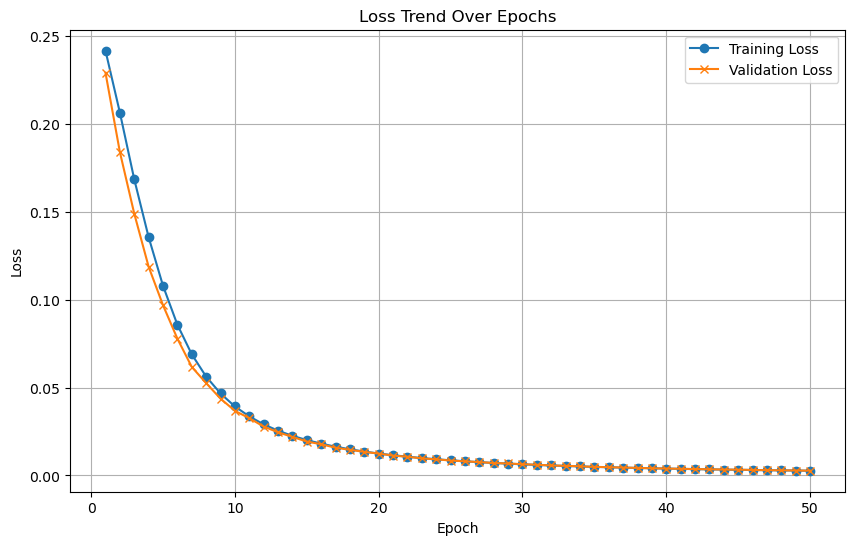

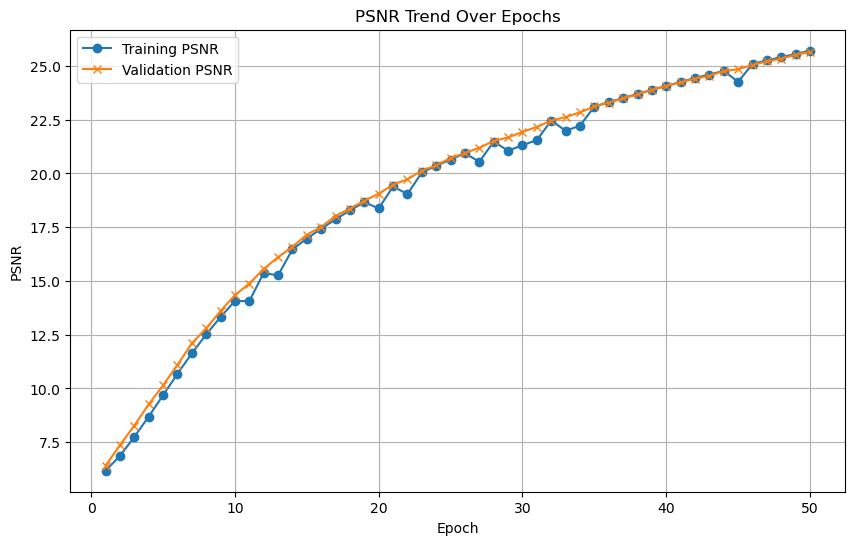

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/20 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.5582
    Validation Batch [1/1], Loss: 2.5702
Validation Loss: 2.5702, Validation Accuracy: 7.69%
Validation loss improved from inf to 2.5702. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5411
    Validation Batch [1/1], Loss: 2.5702
Validation Loss: 2.5702, Validation Accuracy: 7.69%
Validation loss improved from 2.5702 to 2.5702. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5296
    Validation Batch [1/1], Loss: 2.5702
Validation Loss: 2.5702, Validation Accuracy: 7.69%
Validation loss improved from 2.5702 to 2.5702. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5332
    Validation Batch [1/1], Loss: 2.5702
Validation Loss: 2.5702, Validation Accuracy: 7.69%
Validation loss improved from 2.5702 to 2.5702. Saving model...

LOG: Epoch [5/1000] - 

Epoch [20/1000] completed, Average Training Loss: 2.4184
    Validation Batch [1/1], Loss: 2.5700
Validation Loss: 2.5700, Validation Accuracy: 7.69%
Validation loss improved from 2.5700 to 2.5700. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.4176
    Validation Batch [1/1], Loss: 2.5700
Validation Loss: 2.5700, Validation Accuracy: 7.69%
Validation loss improved from 2.5700 to 2.5700. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.4067
    Validation Batch [1/1], Loss: 2.5699
Validation Loss: 2.5699, Validation Accuracy: 7.69%
Validation loss improved from 2.5700 to 2.5699. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.3968
    Validation Batch [1/1], Loss: 2.5699
Validation Loss: 2.5699, Validation Accuracy: 7.69%
Validation loss improved from 2.5699 to 2.5699. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/10

Epoch [45/1000] completed, Average Training Loss: 2.2523
    Validation Batch [1/1], Loss: 2.5642
Validation Loss: 2.5642, Validation Accuracy: 7.69%
Validation loss improved from 2.5650 to 2.5642. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [46/1000] completed, Average Training Loss: 2.2528
    Validation Batch [1/1], Loss: 2.5630
Validation Loss: 2.5630, Validation Accuracy: 9.23%
Validation loss improved from 2.5642 to 2.5630. Saving model...

LOG: Epoch [47/1000] - Training
Epoch [47/1000] completed, Average Training Loss: 2.2474
    Validation Batch [1/1], Loss: 2.5618
Validation Loss: 2.5618, Validation Accuracy: 9.23%
Validation loss improved from 2.5630 to 2.5618. Saving model...

LOG: Epoch [48/1000] - Training
Epoch [48/1000] completed, Average Training Loss: 2.2200
    Validation Batch [1/1], Loss: 2.5607
Validation Loss: 2.5607, Validation Accuracy: 9.23%
Validation loss improved from 2.5618 to 2.5607. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/10

    Validation Batch [1/1], Loss: 2.4914
Validation Loss: 2.4914, Validation Accuracy: 16.92%
Validation loss improved from 2.4980 to 2.4914. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 2.0699
    Validation Batch [1/1], Loss: 2.4836
Validation Loss: 2.4836, Validation Accuracy: 18.46%
Validation loss improved from 2.4914 to 2.4836. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [72/1000] completed, Average Training Loss: 2.0741
    Validation Batch [1/1], Loss: 2.4747
Validation Loss: 2.4747, Validation Accuracy: 23.08%
Validation loss improved from 2.4836 to 2.4747. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [73/1000] completed, Average Training Loss: 2.0459
    Validation Batch [1/1], Loss: 2.4658
Validation Loss: 2.4658, Validation Accuracy: 23.08%
Validation loss improved from 2.4747 to 2.4658. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Training Loss: 2.0340
    Vali

Epoch [96/1000] completed, Average Training Loss: 1.8620
    Validation Batch [1/1], Loss: 2.1436
Validation Loss: 2.1436, Validation Accuracy: 38.46%
Validation loss improved from 2.1560 to 2.1436. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.8785
    Validation Batch [1/1], Loss: 2.1332
Validation Loss: 2.1332, Validation Accuracy: 38.46%
Validation loss improved from 2.1436 to 2.1332. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.8653
    Validation Batch [1/1], Loss: 2.1239
Validation Loss: 2.1239, Validation Accuracy: 36.92%
Validation loss improved from 2.1332 to 2.1239. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.8495
    Validation Batch [1/1], Loss: 2.1137
Validation Loss: 2.1137, Validation Accuracy: 36.92%
Validation loss improved from 2.1239 to 2.1137. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [

Epoch [123/1000] completed, Average Training Loss: 1.6432
    Validation Batch [1/1], Loss: 1.9031
Validation Loss: 1.9031, Validation Accuracy: 38.46%
Validation loss improved from 1.9125 to 1.9031. Saving model...

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 1.6526
    Validation Batch [1/1], Loss: 1.8927
Validation Loss: 1.8927, Validation Accuracy: 41.54%
Validation loss improved from 1.9031 to 1.8927. Saving model...

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 1.6510
    Validation Batch [1/1], Loss: 1.8863
Validation Loss: 1.8863, Validation Accuracy: 41.54%
Validation loss improved from 1.8927 to 1.8863. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 1.6329
    Validation Batch [1/1], Loss: 1.8799
Validation Loss: 1.8799, Validation Accuracy: 40.00%
Validation loss improved from 1.8863 to 1.8799. Saving model...

LOG: Epoch [127/1000] - Training


Epoch [149/1000] completed, Average Training Loss: 1.4797
    Validation Batch [1/1], Loss: 1.7210
Validation Loss: 1.7210, Validation Accuracy: 58.46%
Validation loss improved from 1.7319 to 1.7210. Saving model...

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 1.4471
    Validation Batch [1/1], Loss: 1.7091
Validation Loss: 1.7091, Validation Accuracy: 56.92%
Validation loss improved from 1.7210 to 1.7091. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 1.4264
    Validation Batch [1/1], Loss: 1.7002
Validation Loss: 1.7002, Validation Accuracy: 56.92%
Validation loss improved from 1.7091 to 1.7002. Saving model...

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 1.4452
    Validation Batch [1/1], Loss: 1.6951
Validation Loss: 1.6951, Validation Accuracy: 58.46%
Validation loss improved from 1.7002 to 1.6951. Saving model...

LOG: Epoch [153/1000] - Training


    Validation Batch [1/1], Loss: 1.5580
Validation Loss: 1.5580, Validation Accuracy: 60.00%
Validation loss improved from 1.5678 to 1.5580. Saving model...

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 1.2658
    Validation Batch [1/1], Loss: 1.5561
Validation Loss: 1.5561, Validation Accuracy: 60.00%
Validation loss improved from 1.5580 to 1.5561. Saving model...

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 1.2384
    Validation Batch [1/1], Loss: 1.5513
Validation Loss: 1.5513, Validation Accuracy: 61.54%
Validation loss improved from 1.5561 to 1.5513. Saving model...

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 1.2267
    Validation Batch [1/1], Loss: 1.5502
Validation Loss: 1.5502, Validation Accuracy: 61.54%
Validation loss improved from 1.5513 to 1.5502. Saving model...

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 1.2243


Epoch [201/1000] completed, Average Training Loss: 1.0462
    Validation Batch [1/1], Loss: 1.4481
Validation Loss: 1.4481, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 1.0414
    Validation Batch [1/1], Loss: 1.4430
Validation Loss: 1.4430, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 1.0451
    Validation Batch [1/1], Loss: 1.4297
Validation Loss: 1.4297, Validation Accuracy: 64.62%
Validation loss improved from 1.4410 to 1.4297. Saving model...

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 1.0180
    Validation Batch [1/1], Loss: 1.4363
Validation Loss: 1.4363, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.3319
Validation Loss: 1.3319, Validation Accuracy: 64.62%
Validation loss improved from 1.3375 to 1.3319. Saving model...

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.8430
    Validation Batch [1/1], Loss: 1.3560
Validation Loss: 1.3560, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.8264
    Validation Batch [1/1], Loss: 1.3076
Validation Loss: 1.3076, Validation Accuracy: 64.62%
Validation loss improved from 1.3319 to 1.3076. Saving model...

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 0.8382
    Validation Batch [1/1], Loss: 1.3329
Validation Loss: 1.3329, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training Loss: 0.8362
    Validation Batch [1/1], Lo

Epoch [253/1000] completed, Average Training Loss: 0.6643
    Validation Batch [1/1], Loss: 1.2049
Validation Loss: 1.2049, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.6367
    Validation Batch [1/1], Loss: 1.1490
Validation Loss: 1.1490, Validation Accuracy: 70.77%
Validation loss improved from 1.1844 to 1.1490. Saving model...

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training Loss: 0.6492
    Validation Batch [1/1], Loss: 1.1746
Validation Loss: 1.1746, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.6286
    Validation Batch [1/1], Loss: 1.2521
Validation Loss: 1.2521, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training 

Epoch [280/1000] completed, Average Training Loss: 0.5055
    Validation Batch [1/1], Loss: 1.0864
Validation Loss: 1.0864, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.4969
    Validation Batch [1/1], Loss: 1.0800
Validation Loss: 1.0800, Validation Accuracy: 72.31%
Validation loss improved from 1.0800 to 1.0800. Saving model...

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.4928
    Validation Batch [1/1], Loss: 1.0469
Validation Loss: 1.0469, Validation Accuracy: 70.77%
Validation loss improved from 1.0800 to 1.0469. Saving model...

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.4852
    Validation Batch [1/1], Loss: 1.0512
Validation Loss: 1.0512, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Av

Epoch [306/1000] completed, Average Training Loss: 0.4223
    Validation Batch [1/1], Loss: 1.0012
Validation Loss: 1.0012, Validation Accuracy: 73.85%
Validation loss improved from 1.0042 to 1.0012. Saving model...

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.3998
    Validation Batch [1/1], Loss: 1.0000
Validation Loss: 1.0000, Validation Accuracy: 76.92%
Validation loss improved from 1.0012 to 1.0000. Saving model...

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.4034
    Validation Batch [1/1], Loss: 1.0068
Validation Loss: 1.0068, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.3970
    Validation Batch [1/1], Loss: 1.0087
Validation Loss: 1.0087, Validation Accuracy: 73.85%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Av

    Validation Batch [1/1], Loss: 0.9282
Validation Loss: 0.9282, Validation Accuracy: 76.92%
Validation loss improved from 0.9364 to 0.9282. Saving model...

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.2940
    Validation Batch [1/1], Loss: 0.9370
Validation Loss: 0.9370, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.3230
    Validation Batch [1/1], Loss: 0.9536
Validation Loss: 0.9536, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.3145
    Validation Batch [1/1], Loss: 0.9219
Validation Loss: 0.9219, Validation Accuracy: 76.92%
Validation loss improved from 0.9282 to 0.9219. Saving model...

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.3074
    Validation Batch [1/1], Lo

Epoch [355/1000] completed, Average Training Loss: 0.2479
    Validation Batch [1/1], Loss: 0.9648
Validation Loss: 0.9648, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.2329
    Validation Batch [1/1], Loss: 0.9917
Validation Loss: 0.9917, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training Loss: 0.2449
    Validation Batch [1/1], Loss: 0.9485
Validation Loss: 0.9485, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [358/1000] - Training
Epoch [358/1000] completed, Average Training Loss: 0.2324
    Validation Batch [1/1], Loss: 0.9370
Validation Loss: 0.9370, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [359/1000] - Training
Epoch [359/1000] completed, Average Training Loss: 0.222

Epoch [383/1000] completed, Average Training Loss: 0.1786
    Validation Batch [1/1], Loss: 1.0043
Validation Loss: 1.0043, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [384/1000] - Training
Epoch [384/1000] completed, Average Training Loss: 0.1700
    Validation Batch [1/1], Loss: 1.0347
Validation Loss: 1.0347, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.1950
    Validation Batch [1/1], Loss: 0.9854
Validation Loss: 0.9854, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.1750
    Validation Batch [1/1], Loss: 0.9711
Validation Loss: 0.9711, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.182

Epoch [408/1000] completed, Average Training Loss: 0.1453
    Validation Batch [1/1], Loss: 0.9036
Validation Loss: 0.9036, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [409/1000] - Training
Epoch [409/1000] completed, Average Training Loss: 0.1538
    Validation Batch [1/1], Loss: 0.9094
Validation Loss: 0.9094, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [410/1000] - Training
Epoch [410/1000] completed, Average Training Loss: 0.1236
    Validation Batch [1/1], Loss: 0.9708
Validation Loss: 0.9708, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [411/1000] - Training
Epoch [411/1000] completed, Average Training Loss: 0.1376
    Validation Batch [1/1], Loss: 1.0075
Validation Loss: 1.0075, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [412/1000] - Training
Epoch [412/1000] completed, Average Training Loss: 0.138

Epoch [423/1000] completed, Average Training Loss: 0.1238
    Validation Batch [1/1], Loss: 1.0106
Validation Loss: 1.0106, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.1439
    Validation Batch [1/1], Loss: 0.9982
Validation Loss: 0.9982, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.1328
    Validation Batch [1/1], Loss: 1.0151
Validation Loss: 1.0151, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.1236
    Validation Batch [1/1], Loss: 1.0187
Validation Loss: 1.0187, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.131

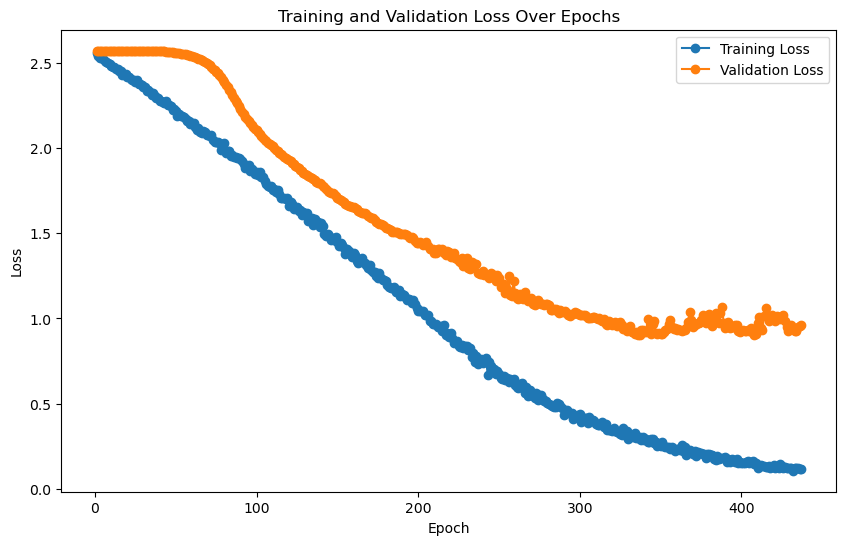

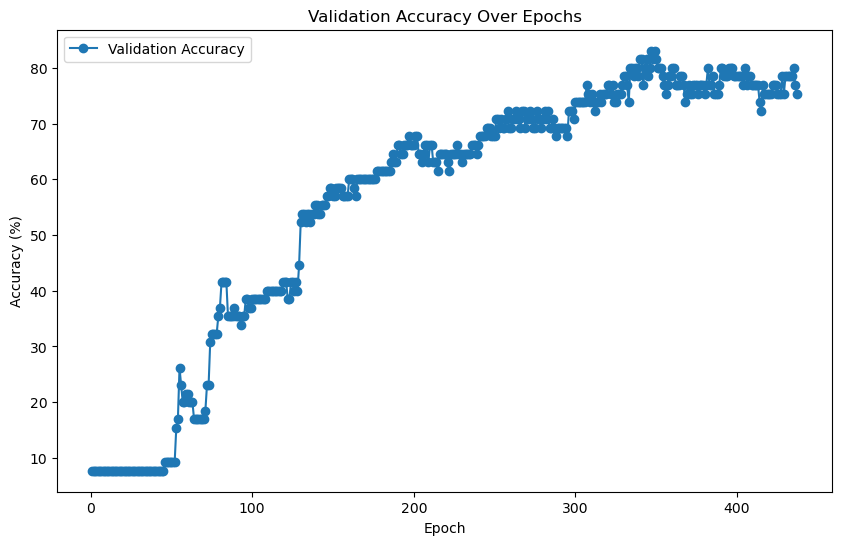


Evaluating on the test set...
    Test Batch [1/20], Loss: 0.4118

Final Test Loss: 0.9592, Test Accuracy: 82.17%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 260 samples with 64 features each
LOG: Labels shape: (260,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4886 samples with 64 features each
LOG: Labels shape: (4886,)

LOG: Training features shape: (260, 64), Training labels shape: (260,)
LOG: Validation features shape: (65, 64), Validation labels shape: (65,)
LOG: Test features shape: (4886, 64), Test labels shape: (4886,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 32.31%



Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.33      0.20      0.25         5
           4       0.60      0.60      0.60         5
           5       1.00      0.20      0.33         5
           6       0.56      1.00      0.71         5
           7       0.10      0.20      0.13         5
           8       0.31      0.80      0.44         5
           9       0.00      0.00      0.00         5
          10       0.44      0.80      0.57         5
          11       0.00      0.00      0.00         5
          12       0.20      0.20      0.20         5

    accuracy                           0.32        65
   macro avg       0.31      0.32      0.27        65
weighted avg       0.31      0.32      0.27        65


LOG: Evaluating on the test set...
Test Ac

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 260 samples with 64 features each
LOG: Labels shape: (260,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4886 samples with 64 features each
LOG: Labels shape: (4886,)
Train reps shape: (260, 64)
Train labels shape: (260,)
Val reps shape: (65, 64)
Val labels shape: (65,)
Test reps shape: (4886, 64)
Test labels shape: (4886,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5556  |  Val Loss: 2.5199
Validation loss improved from inf to 2.5199.
[Epoch 2/1000] Train Loss: 2.5053  |  Val Loss: 2.5159
Validation loss improved from 2.5199 to 2.5159.
[Epoch 3/1000] Train Loss: 2.4870  |  Val Loss: 2.4937
Validation loss improved from 2.5159 to 2.4937.
[Epoch 4/1000] Train Loss: 2.4687  |  Val Loss: 2.4840
Validation loss improved from 2.4937 to 2.4840.
[Epoch 5/1000] Train Loss: 2.4549  |  Val Loss: 2.5002
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 6/1000] Train Loss: 2.4561  |  Val Loss: 2.5105
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 7/1000] Train Loss: 2.4453  |  Val Loss: 2.4964
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 8/1000] Train Loss: 2.4345  |  Val Loss: 2.4828
Validation loss improved from 2.4840 to 2.4828.
[Epoch 9/1000] Train Loss: 2.4274  |  Val Loss: 2.4721
Validation loss improved from 2.4828 to 2.4721.
[Epoch 10/1000] Train Loss: 2.4223  |  Val Loss: 2.4677
Va

[Epoch 16/1000] Train Loss: 2.3918  |  Val Loss: 2.4796
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 17/1000] Train Loss: 2.3915  |  Val Loss: 2.4720
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 18/1000] Train Loss: 2.3768  |  Val Loss: 2.4659
Validation loss improved from 2.4677 to 2.4659.
[Epoch 19/1000] Train Loss: 2.3682  |  Val Loss: 2.4662
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 20/1000] Train Loss: 2.3754  |  Val Loss: 2.4797
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 21/1000] Train Loss: 2.3716  |  Val Loss: 2.4765
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 22/1000] Train Loss: 2.3630  |  Val Loss: 2.4771
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 23/1000] Train Loss: 2.3604  |  Val Loss: 2.4686
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 24/1000] Train Loss: 2.3471  |  Val Loss: 2.4639
Validation loss improved from 2.4659 to 2.4639.
[Epoch 25/1000] Train Loss: 2.3506  |  Val Loss: 2.4510
Validation loss improved from 2.4639 to 2.4510.
[Epoch 26/1000] Train Loss: 2.3746  |  Val Loss: 2.4608
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 27/1000] Train Loss: 2.3570  |  Val Loss: 2.4822
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 28/1000] Train Loss: 2.3393  |  Val Loss: 2.4884
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 29/1000] Train Loss: 2.3326  |  Val Loss: 2.4835
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 30/1000] Train Loss: 2.3360  |  Val Loss: 2.4952
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 31/1000] Train Loss: 2.3357  |  Val Loss: 2.5041
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 32/1000] Train 

[Epoch 36/1000] Train Loss: 2.3070  |  Val Loss: 2.4900
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 37/1000] Train Loss: 2.3021  |  Val Loss: 2.5188
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 38/1000] Train Loss: 2.3484  |  Val Loss: 2.5433
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 39/1000] Train Loss: 2.3364  |  Val Loss: 2.5210
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 40/1000] Train Loss: 2.3199  |  Val Loss: 2.6301
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 41/1000] Train Loss: 2.3725  |  Val Loss: 2.6204
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 42/1000] Train Loss: 2.3533  |  Val Loss: 2.5416
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 43/1000] Train Loss: 2.3209  |  Val Loss: 2.5177
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 44/1000] Train Loss: 2.3051  |  Val Loss: 2.5032
!! Validation loss did NOT improve !! Patience: 19/100


[Epoch 45/1000] Train Loss: 2.3022  |  Val Loss: 2.5157
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 46/1000] Train Loss: 2.3076  |  Val Loss: 2.5156
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 47/1000] Train Loss: 2.3049  |  Val Loss: 2.5306
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 48/1000] Train Loss: 2.2957  |  Val Loss: 2.5936
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 49/1000] Train Loss: 2.3327  |  Val Loss: 2.5997
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 50/1000] Train Loss: 2.3169  |  Val Loss: 2.5359
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 51/1000] Train Loss: 2.2894  |  Val Loss: 2.4942
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 52/1000] Train Loss: 2.2885  |  Val Loss: 2.4848
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 53/1000] Train Loss: 2.2855  |  Val Loss: 2.4961
!! Validation loss did NOT improve !! Patience: 28/100
[

[Epoch 58/1000] Train Loss: 2.2721  |  Val Loss: 2.4967
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 59/1000] Train Loss: 2.2715  |  Val Loss: 2.5214
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 60/1000] Train Loss: 2.3157  |  Val Loss: 2.5351
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 61/1000] Train Loss: 2.2780  |  Val Loss: 2.5743
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 62/1000] Train Loss: 2.2758  |  Val Loss: 2.5500
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 63/1000] Train Loss: 2.2727  |  Val Loss: 2.5341
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 64/1000] Train Loss: 2.2688  |  Val Loss: 2.5267
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 65/1000] Train Loss: 2.2635  |  Val Loss: 2.5333
!! Validation loss did NOT improve !! Patience: 40/100


[Epoch 66/1000] Train Loss: 2.2589  |  Val Loss: 2.5487
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 67/1000] Train Loss: 2.2660  |  Val Loss: 2.5966
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 68/1000] Train Loss: 2.2746  |  Val Loss: 2.5452
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 69/1000] Train Loss: 2.2426  |  Val Loss: 2.5047
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 70/1000] Train Loss: 2.2597  |  Val Loss: 2.4988
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 71/1000] Train Loss: 2.2581  |  Val Loss: 2.5152
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 72/1000] Train Loss: 2.2477  |  Val Loss: 2.5455
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 73/1000] Train Loss: 2.2468  |  Val Loss: 2.5443
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 74/1000] Train Loss: 2.2390  |  Val Loss: 2.5163
!! Validation loss did NOT improve !! Patience: 49/100
[

[Epoch 78/1000] Train Loss: 2.2209  |  Val Loss: 2.5266
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 79/1000] Train Loss: 2.2307  |  Val Loss: 2.5411
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 80/1000] Train Loss: 2.2247  |  Val Loss: 2.5250
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 81/1000] Train Loss: 2.2129  |  Val Loss: 2.5356
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 82/1000] Train Loss: 2.2039  |  Val Loss: 2.5068
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 83/1000] Train Loss: 2.1994  |  Val Loss: 2.5127
!! Validation loss did NOT improve !! Patience: 58/100


[Epoch 84/1000] Train Loss: 2.1978  |  Val Loss: 2.5294
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 85/1000] Train Loss: 2.1917  |  Val Loss: 2.5402
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 86/1000] Train Loss: 2.1885  |  Val Loss: 2.5132
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 87/1000] Train Loss: 2.1845  |  Val Loss: 2.5020
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 88/1000] Train Loss: 2.1938  |  Val Loss: 2.5258
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 89/1000] Train Loss: 2.1825  |  Val Loss: 2.5940
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 90/1000] Train Loss: 2.2012  |  Val Loss: 2.5904
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 91/1000] Train Loss: 2.1754  |  Val Loss: 2.5545
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 92/1000] Train Loss: 2.2317  |  Val Loss: 2.5199
!! Validation loss did NOT improve !! Patience: 67/100
[

[Epoch 99/1000] Train Loss: 2.1457  |  Val Loss: 2.5215
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 100/1000] Train Loss: 2.1437  |  Val Loss: 2.5272
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 101/1000] Train Loss: 2.1396  |  Val Loss: 2.5126
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 102/1000] Train Loss: 2.1347  |  Val Loss: 2.5119
!! Validation loss did NOT improve !! Patience: 77/100


[Epoch 103/1000] Train Loss: 2.1237  |  Val Loss: 2.5141
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 104/1000] Train Loss: 2.1131  |  Val Loss: 2.5274
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 105/1000] Train Loss: 2.1288  |  Val Loss: 2.5445
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 106/1000] Train Loss: 2.1139  |  Val Loss: 2.4324
Validation loss improved from 2.4510 to 2.4324.
[Epoch 107/1000] Train Loss: 2.0961  |  Val Loss: 2.4164
Validation loss improved from 2.4324 to 2.4164.
[Epoch 108/1000] Train Loss: 2.0885  |  Val Loss: 2.5108
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 109/1000] Train Loss: 2.0938  |  Val Loss: 2.5047
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 110/1000] Train Loss: 2.0768  |  Val Loss: 2.4291
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 111/1000] Train Loss: 2.0536  |  Val Loss: 2.4062
Validation loss improved from 2.4164 to 2.4062.
[Epoch 112/1000]

[Epoch 120/1000] Train Loss: 1.9501  |  Val Loss: 2.3628
Validation loss improved from 2.3683 to 2.3628.


[Epoch 121/1000] Train Loss: 1.9528  |  Val Loss: 2.3729
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 122/1000] Train Loss: 1.9768  |  Val Loss: 2.4023
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 123/1000] Train Loss: 1.9684  |  Val Loss: 2.5153
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 124/1000] Train Loss: 2.0603  |  Val Loss: 2.3692
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 125/1000] Train Loss: 1.9253  |  Val Loss: 2.3727
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 126/1000] Train Loss: 1.9833  |  Val Loss: 2.3311
Validation loss improved from 2.3628 to 2.3311.
[Epoch 127/1000] Train Loss: 1.9345  |  Val Loss: 2.3359
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 128/1000] Train Loss: 1.9409  |  Val Loss: 2.3525
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 129/1000] Train Loss: 1.9185  |  Val Loss: 2.3549
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 

[Epoch 142/1000] Train Loss: 1.7932  |  Val Loss: 2.2740
Validation loss improved from 2.2983 to 2.2740.
[Epoch 143/1000] Train Loss: 1.7796  |  Val Loss: 2.4418
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 144/1000] Train Loss: 1.8677  |  Val Loss: 2.5111
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 145/1000] Train Loss: 1.8093  |  Val Loss: 2.4404
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 146/1000] Train Loss: 1.7757  |  Val Loss: 2.4007
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 147/1000] Train Loss: 1.8599  |  Val Loss: 2.3572
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 148/1000] Train Loss: 1.7561  |  Val Loss: 2.4656
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 149/1000] Train Loss: 1.8309  |  Val Loss: 2.4078
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 150/1000] Train Loss: 1.9434  |  Val Loss: 2.5199
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 163/1000] Train Loss: 1.6751  |  Val Loss: 2.2791
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 164/1000] Train Loss: 1.6757  |  Val Loss: 2.3479
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 165/1000] Train Loss: 1.7062  |  Val Loss: 2.2970
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 166/1000] Train Loss: 1.6767  |  Val Loss: 2.3237
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 167/1000] Train Loss: 1.6364  |  Val Loss: 2.2697
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 168/1000] Train Loss: 1.6358  |  Val Loss: 2.2493
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 169/1000] Train Loss: 1.6402  |  Val Loss: 2.2593
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 170/1000] Train Loss: 1.6423  |  Val Loss: 2.2871
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 171/1000] Train Loss: 1.6331  |  Val Loss: 2.2863
!! Validation loss did NOT improve !! Patience:

[Epoch 183/1000] Train Loss: 1.6165  |  Val Loss: 2.2904
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 184/1000] Train Loss: 1.6130  |  Val Loss: 2.3090
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 185/1000] Train Loss: 1.6014  |  Val Loss: 2.2892
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 186/1000] Train Loss: 1.5864  |  Val Loss: 2.2529
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 187/1000] Train Loss: 1.5666  |  Val Loss: 2.2722
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 188/1000] Train Loss: 1.5645  |  Val Loss: 2.2677
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 189/1000] Train Loss: 1.5473  |  Val Loss: 2.2537
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 190/1000] Train Loss: 1.5768  |  Val Loss: 2.2669
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 191/1000] Train Loss: 1.5933  |  Val Loss: 2.2540
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 205/1000] Train Loss: 1.5658  |  Val Loss: 2.4104
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 206/1000] Train Loss: 1.6312  |  Val Loss: 2.3463
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 207/1000] Train Loss: 1.5980  |  Val Loss: 2.3150
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 208/1000] Train Loss: 1.5508  |  Val Loss: 2.3031
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 209/1000] Train Loss: 1.5440  |  Val Loss: 2.4117
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 210/1000] Train Loss: 1.6035  |  Val Loss: 2.3937
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 211/1000] Train Loss: 1.5318  |  Val Loss: 2.3445
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 212/1000] Train Loss: 1.5289  |  Val Loss: 2.3208
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 213/1000] Train Loss: 1.5681  |  Val Loss: 2.2832
!! Validation loss did NOT improve !! Patience:

[Epoch 225/1000] Train Loss: 1.5222  |  Val Loss: 2.3167
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 226/1000] Train Loss: 1.4924  |  Val Loss: 2.4093
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 227/1000] Train Loss: 1.6082  |  Val Loss: 2.3290
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 228/1000] Train Loss: 1.5524  |  Val Loss: 2.3003
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 229/1000] Train Loss: 1.4997  |  Val Loss: 2.3118
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 230/1000] Train Loss: 1.5426  |  Val Loss: 2.3982
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 231/1000] Train Loss: 1.6028  |  Val Loss: 2.4178
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 232/1000] Train Loss: 1.5177  |  Val Loss: 2.2637
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 233/1000] Train Loss: 1.4993  |  Val Loss: 2.3164
!! Validation loss did NOT improve !! Patience:

[Epoch 245/1000] Train Loss: 1.5053  |  Val Loss: 2.4211
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 246/1000] Train Loss: 1.5018  |  Val Loss: 2.4005
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 247/1000] Train Loss: 1.4663  |  Val Loss: 2.3597
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 248/1000] Train Loss: 1.4567  |  Val Loss: 2.3746
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 249/1000] Train Loss: 1.4578  |  Val Loss: 2.3590
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 250/1000] Train Loss: 1.4748  |  Val Loss: 2.3612
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 251/1000] Train Loss: 1.4736  |  Val Loss: 2.4603
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 252/1000] Train Loss: 1.4717  |  Val Loss: 2.4356
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 253/1000] Train Loss: 1.4808  |  Val Loss: 2.4342
!! Validation loss did NOT improve !! Patience:

[Epoch 264/1000] Train Loss: 1.4472  |  Val Loss: 2.4142
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 265/1000] Train Loss: 1.4874  |  Val Loss: 2.3268
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 266/1000] Train Loss: 1.4457  |  Val Loss: 2.3265
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 267/1000] Train Loss: 1.4399  |  Val Loss: 2.3308
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 268/1000] Train Loss: 1.4332  |  Val Loss: 2.3457
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 269/1000] Train Loss: 1.4458  |  Val Loss: 2.4253
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 270/1000] Train Loss: 1.4442  |  Val Loss: 2.4358
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 271/1000] Train Loss: 1.4615  |  Val Loss: 2.3718
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 272/1000] Train Loss: 1.4303  |  Val Loss: 2.3441
!! Validation loss did NOT improve !! Patience:

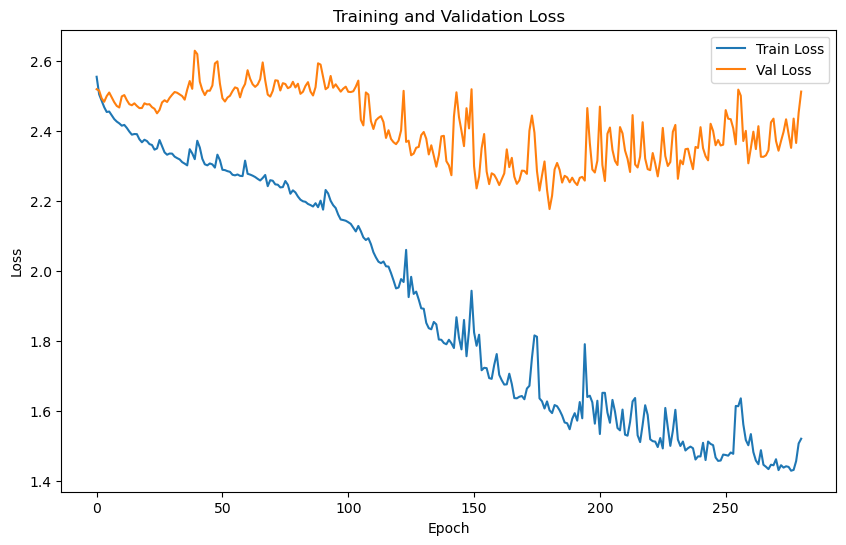

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.7625 | Test Accuracy: 39.05%


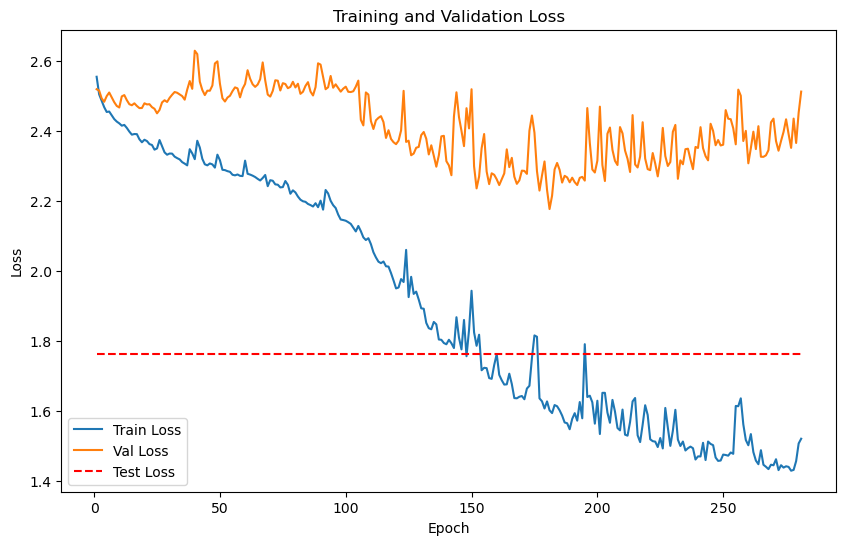

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 260 samples with 64 features each
LOG: Labels shape: (260,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4886 samples with 64 features each
LOG: Labels shape: (4886,)


Train embeddings shape: (260, 64), 
Train labels shape: (260,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (4886, 64), 
Test labels shape: (4886,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}
Training batch size: 260


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.3287
Epoch [1/2000], Avg Train Loss: 8.3287
Epoch [1/2000], Avg Val Loss: 6.2608
Validation loss improved from inf to 6.2608. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.2075
Epoch [2/2000], Avg Train Loss: 8.2075
Epoch [2/2000], Avg Val Loss: 6.2222
Validation loss improved from 6.2608 to 6.2222. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.1511
Epoch [3/2000], Avg Train Loss: 8.1511
Epoch [3/2000], Avg Val Loss: 6.1847
Validation loss improved from 6.2222 to 6.1847. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.1500
Epoch [4/2000], Avg Train Loss: 8.1500
Epoch [4/2000], Avg Val Loss: 6.1471
Validation loss improved from 6.1847 to 6.1471. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.9321
Epoch [5/2000], Avg Train Loss: 7.9321
Epoch [5/2000], Avg Val Loss: 6.1092
Validation loss improved from 6.1471 to 6.1092. Saving mode

    Batch [1/1], Train Loss: 7.6958
Epoch [12/2000], Avg Train Loss: 7.6958
Epoch [12/2000], Avg Val Loss: 5.8362
Validation loss improved from 5.8754 to 5.8362. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 7.7466
Epoch [13/2000], Avg Train Loss: 7.7466
Epoch [13/2000], Avg Val Loss: 5.7970
Validation loss improved from 5.8362 to 5.7970. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 7.6265
Epoch [14/2000], Avg Train Loss: 7.6265
Epoch [14/2000], Avg Val Loss: 5.7576
Validation loss improved from 5.7970 to 5.7576. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 7.5726
Epoch [15/2000], Avg Train Loss: 7.5726
Epoch [15/2000], Avg Val Loss: 5.7177
Validation loss improved from 5.7576 to 5.7177. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 7.5366
Epoch [16/2000], Avg Train Loss: 7.5366
Epoch [16/2000], Avg Val Loss: 5.6778
Validation loss improved from 5.7177 to 5.

    Batch [1/1], Train Loss: 7.4117
Epoch [18/2000], Avg Train Loss: 7.4117
Epoch [18/2000], Avg Val Loss: 5.5984
Validation loss improved from 5.6380 to 5.5984. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 7.3766
Epoch [19/2000], Avg Train Loss: 7.3766
Epoch [19/2000], Avg Val Loss: 5.5588
Validation loss improved from 5.5984 to 5.5588. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 7.3777
Epoch [20/2000], Avg Train Loss: 7.3777
Epoch [20/2000], Avg Val Loss: 5.5194
Validation loss improved from 5.5588 to 5.5194. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 7.3003
Epoch [21/2000], Avg Train Loss: 7.3003
Epoch [21/2000], Avg Val Loss: 5.4801
Validation loss improved from 5.5194 to 5.4801. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 7.2103
Epoch [22/2000], Avg Train Loss: 7.2103
Epoch [22/2000], Avg Val Loss: 5.4406
Validation loss improved from 5.4801 to 5.

    Batch [1/1], Train Loss: 7.1534
Epoch [25/2000], Avg Train Loss: 7.1534
Epoch [25/2000], Avg Val Loss: 5.3242
Validation loss improved from 5.3627 to 5.3242. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 7.1392
Epoch [26/2000], Avg Train Loss: 7.1392
Epoch [26/2000], Avg Val Loss: 5.2859
Validation loss improved from 5.3242 to 5.2859. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 7.0396
Epoch [27/2000], Avg Train Loss: 7.0396
Epoch [27/2000], Avg Val Loss: 5.2483
Validation loss improved from 5.2859 to 5.2483. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 7.0350
Epoch [28/2000], Avg Train Loss: 7.0350
Epoch [28/2000], Avg Val Loss: 5.2110
Validation loss improved from 5.2483 to 5.2110. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 7.0860
Epoch [29/2000], Avg Train Loss: 7.0860
Epoch [29/2000], Avg Val Loss: 5.1740
Validation loss improved from 5.2110 to 5.

    Batch [1/1], Train Loss: 6.7663
Epoch [36/2000], Avg Train Loss: 6.7663
Epoch [36/2000], Avg Val Loss: 4.9275
Validation loss improved from 4.9612 to 4.9275. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 6.7154
Epoch [37/2000], Avg Train Loss: 6.7154
Epoch [37/2000], Avg Val Loss: 4.8943
Validation loss improved from 4.9275 to 4.8943. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 6.6920
Epoch [38/2000], Avg Train Loss: 6.6920
Epoch [38/2000], Avg Val Loss: 4.8617
Validation loss improved from 4.8943 to 4.8617. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 6.6450
Epoch [39/2000], Avg Train Loss: 6.6450
Epoch [39/2000], Avg Val Loss: 4.8298
Validation loss improved from 4.8617 to 4.8298. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 6.6273
Epoch [40/2000], Avg Train Loss: 6.6273
Epoch [40/2000], Avg Val Loss: 4.7983
Validation loss improved from 4.8298 to 4.

    Batch [1/1], Train Loss: 6.6236
Epoch [42/2000], Avg Train Loss: 6.6236
Epoch [42/2000], Avg Val Loss: 4.7374
Validation loss improved from 4.7675 to 4.7374. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 6.6050
Epoch [43/2000], Avg Train Loss: 6.6050
Epoch [43/2000], Avg Val Loss: 4.7079
Validation loss improved from 4.7374 to 4.7079. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 6.5665
Epoch [44/2000], Avg Train Loss: 6.5665
Epoch [44/2000], Avg Val Loss: 4.6793
Validation loss improved from 4.7079 to 4.6793. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 6.5402
Epoch [45/2000], Avg Train Loss: 6.5402
Epoch [45/2000], Avg Val Loss: 4.6516
Validation loss improved from 4.6793 to 4.6516. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 6.5316
Epoch [46/2000], Avg Train Loss: 6.5316
Epoch [46/2000], Avg Val Loss: 4.6247
Validation loss improved from 4.6516 to 4.

    Batch [1/1], Train Loss: 6.4448
Epoch [49/2000], Avg Train Loss: 6.4448
Epoch [49/2000], Avg Val Loss: 4.5476
Validation loss improved from 4.5727 to 4.5476. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 6.4505
Epoch [50/2000], Avg Train Loss: 6.4505
Epoch [50/2000], Avg Val Loss: 4.5234
Validation loss improved from 4.5476 to 4.5234. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 6.3216
Epoch [51/2000], Avg Train Loss: 6.3216
Epoch [51/2000], Avg Val Loss: 4.4999
Validation loss improved from 4.5234 to 4.4999. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 6.3600
Epoch [52/2000], Avg Train Loss: 6.3600
Epoch [52/2000], Avg Val Loss: 4.4771
Validation loss improved from 4.4999 to 4.4771. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 6.2844
Epoch [53/2000], Avg Train Loss: 6.2844
Epoch [53/2000], Avg Val Loss: 4.4552
Validation loss improved from 4.4771 to 4.

    Batch [1/1], Train Loss: 6.0398
Epoch [67/2000], Avg Train Loss: 6.0398
Epoch [67/2000], Avg Val Loss: 4.2180
Validation loss improved from 4.2310 to 4.2180. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 6.0190
Epoch [68/2000], Avg Train Loss: 6.0190
Epoch [68/2000], Avg Val Loss: 4.2055
Validation loss improved from 4.2180 to 4.2055. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 5.9640
Epoch [69/2000], Avg Train Loss: 5.9640
Epoch [69/2000], Avg Val Loss: 4.1936
Validation loss improved from 4.2055 to 4.1936. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 6.0333
Epoch [70/2000], Avg Train Loss: 6.0333
Epoch [70/2000], Avg Val Loss: 4.1820
Validation loss improved from 4.1936 to 4.1820. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.9928
Epoch [71/2000], Avg Train Loss: 5.9928
Epoch [71/2000], Avg Val Loss: 4.1709
Validation loss improved from 4.1820 to 4.

    Batch [1/1], Train Loss: 5.9597
Epoch [75/2000], Avg Train Loss: 5.9597
Epoch [75/2000], Avg Val Loss: 4.1308
Validation loss improved from 4.1402 to 4.1308. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 5.9273
Epoch [76/2000], Avg Train Loss: 5.9273
Epoch [76/2000], Avg Val Loss: 4.1217
Validation loss improved from 4.1308 to 4.1217. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 5.8996
Epoch [77/2000], Avg Train Loss: 5.8996
Epoch [77/2000], Avg Val Loss: 4.1128
Validation loss improved from 4.1217 to 4.1128. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 5.8787
Epoch [78/2000], Avg Train Loss: 5.8787
Epoch [78/2000], Avg Val Loss: 4.1044
Validation loss improved from 4.1128 to 4.1044. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 5.8741
Epoch [79/2000], Avg Train Loss: 5.8741
Epoch [79/2000], Avg Val Loss: 4.0962
Validation loss improved from 4.1044 to 4.

    Batch [1/1], Train Loss: 5.8475
Epoch [85/2000], Avg Train Loss: 5.8475
Epoch [85/2000], Avg Val Loss: 4.0535
Validation loss improved from 4.0600 to 4.0535. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 5.8351
Epoch [86/2000], Avg Train Loss: 5.8351
Epoch [86/2000], Avg Val Loss: 4.0471
Validation loss improved from 4.0535 to 4.0471. Saving model...

LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 5.8735
Epoch [87/2000], Avg Train Loss: 5.8735
Epoch [87/2000], Avg Val Loss: 4.0410
Validation loss improved from 4.0471 to 4.0410. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 5.8158
Epoch [88/2000], Avg Train Loss: 5.8158
Epoch [88/2000], Avg Val Loss: 4.0351
Validation loss improved from 4.0410 to 4.0351. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 5.7567
Epoch [89/2000], Avg Train Loss: 5.7567
Epoch [89/2000], Avg Val Loss: 4.0294
Validation loss improved from 4.0351 to 4.

    Batch [1/1], Train Loss: 5.6555
Epoch [105/2000], Avg Train Loss: 5.6555
Epoch [105/2000], Avg Val Loss: 3.9537
Validation loss improved from 3.9577 to 3.9537. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 5.6991
Epoch [106/2000], Avg Train Loss: 5.6991
Epoch [106/2000], Avg Val Loss: 3.9498
Validation loss improved from 3.9537 to 3.9498. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 5.6865
Epoch [107/2000], Avg Train Loss: 5.6865
Epoch [107/2000], Avg Val Loss: 3.9460
Validation loss improved from 3.9498 to 3.9460. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 5.6658
Epoch [108/2000], Avg Train Loss: 5.6658
Epoch [108/2000], Avg Val Loss: 3.9423
Validation loss improved from 3.9460 to 3.9423. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 5.6578
Epoch [109/2000], Avg Train Loss: 5.6578
Epoch [109/2000], Avg Val Loss: 3.9387
Validation loss improved fro

    Batch [1/1], Train Loss: 5.6719
Epoch [111/2000], Avg Train Loss: 5.6719
Epoch [111/2000], Avg Val Loss: 3.9317
Validation loss improved from 3.9352 to 3.9317. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 5.6223
Epoch [112/2000], Avg Train Loss: 5.6223
Epoch [112/2000], Avg Val Loss: 3.9283
Validation loss improved from 3.9317 to 3.9283. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 5.6011
Epoch [113/2000], Avg Train Loss: 5.6011
Epoch [113/2000], Avg Val Loss: 3.9250
Validation loss improved from 3.9283 to 3.9250. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 5.6473
Epoch [114/2000], Avg Train Loss: 5.6473
Epoch [114/2000], Avg Val Loss: 3.9218
Validation loss improved from 3.9250 to 3.9218. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 5.6055
Epoch [115/2000], Avg Train Loss: 5.6055
Epoch [115/2000], Avg Val Loss: 3.9186
Validation loss improved fro

Epoch [124/2000], Avg Val Loss: 3.8925
Validation loss improved from 3.8952 to 3.8925. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 5.5548
Epoch [125/2000], Avg Train Loss: 5.5548
Epoch [125/2000], Avg Val Loss: 3.8897
Validation loss improved from 3.8925 to 3.8897. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 5.5675
Epoch [126/2000], Avg Train Loss: 5.5675
Epoch [126/2000], Avg Val Loss: 3.8870
Validation loss improved from 3.8897 to 3.8870. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 5.5109
Epoch [127/2000], Avg Train Loss: 5.5109
Epoch [127/2000], Avg Val Loss: 3.8843
Validation loss improved from 3.8870 to 3.8843. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 5.5760
Epoch [128/2000], Avg Train Loss: 5.5760
Epoch [128/2000], Avg Val Loss: 3.8817
Validation loss improved from 3.8843 to 3.8817. Saving model...

LOG: Epoch [129/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.4708
Epoch [144/2000], Avg Train Loss: 5.4708
Epoch [144/2000], Avg Val Loss: 3.8472
Validation loss improved from 3.8490 to 3.8472. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 5.5282
Epoch [145/2000], Avg Train Loss: 5.5282
Epoch [145/2000], Avg Val Loss: 3.8454
Validation loss improved from 3.8472 to 3.8454. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 5.4579
Epoch [146/2000], Avg Train Loss: 5.4579
Epoch [146/2000], Avg Val Loss: 3.8436
Validation loss improved from 3.8454 to 3.8436. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 5.4914
Epoch [147/2000], Avg Train Loss: 5.4914
Epoch [147/2000], Avg Val Loss: 3.8419
Validation loss improved from 3.8436 to 3.8419. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 5.4240
Epoch [148/2000], Avg Train Loss: 5.4240
Epoch [148/2000], Avg Val Loss: 3.8402
Validation loss improved fro

    Batch [1/1], Train Loss: 5.3995
Epoch [161/2000], Avg Train Loss: 5.3995
Epoch [161/2000], Avg Val Loss: 3.8224
Validation loss improved from 3.8234 to 3.8224. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 5.4101
Epoch [162/2000], Avg Train Loss: 5.4101
Epoch [162/2000], Avg Val Loss: 3.8214
Validation loss improved from 3.8224 to 3.8214. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 5.3924
Epoch [163/2000], Avg Train Loss: 5.3924
Epoch [163/2000], Avg Val Loss: 3.8205
Validation loss improved from 3.8214 to 3.8205. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 5.3877
Epoch [164/2000], Avg Train Loss: 5.3877
Epoch [164/2000], Avg Val Loss: 3.8196
Validation loss improved from 3.8205 to 3.8196. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 5.4052
Epoch [165/2000], Avg Train Loss: 5.4052
Epoch [165/2000], Avg Val Loss: 3.8187
Validation loss improved fro

    Batch [1/1], Train Loss: 5.3527
Epoch [180/2000], Avg Train Loss: 5.3527
Epoch [180/2000], Avg Val Loss: 3.8081
Validation loss improved from 3.8086 to 3.8081. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 5.3425
Epoch [181/2000], Avg Train Loss: 5.3425
Epoch [181/2000], Avg Val Loss: 3.8076
Validation loss improved from 3.8081 to 3.8076. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 5.3535
Epoch [182/2000], Avg Train Loss: 5.3535
Epoch [182/2000], Avg Val Loss: 3.8071
Validation loss improved from 3.8076 to 3.8071. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 5.3311
Epoch [183/2000], Avg Train Loss: 5.3311
Epoch [183/2000], Avg Val Loss: 3.8067
Validation loss improved from 3.8071 to 3.8067. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 5.3378
Epoch [184/2000], Avg Train Loss: 5.3378
Epoch [184/2000], Avg Val Loss: 3.8062
Validation loss improved fro

    Batch [1/1], Train Loss: 5.3035
Epoch [198/2000], Avg Train Loss: 5.3035
Epoch [198/2000], Avg Val Loss: 3.8008
Validation loss improved from 3.8011 to 3.8008. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 5.3238
Epoch [199/2000], Avg Train Loss: 5.3238
Epoch [199/2000], Avg Val Loss: 3.8004
Validation loss improved from 3.8008 to 3.8004. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 5.2898
Epoch [200/2000], Avg Train Loss: 5.2898
Epoch [200/2000], Avg Val Loss: 3.8000
Validation loss improved from 3.8004 to 3.8000. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 5.3284
Epoch [201/2000], Avg Train Loss: 5.3284
Epoch [201/2000], Avg Val Loss: 3.7997
Validation loss improved from 3.8000 to 3.7997. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 5.3051
Epoch [202/2000], Avg Train Loss: 5.3051
Epoch [202/2000], Avg Val Loss: 3.7993
Validation loss improved fro

    Batch [1/1], Train Loss: 5.3147
Epoch [216/2000], Avg Train Loss: 5.3147
Epoch [216/2000], Avg Val Loss: 3.7957
Validation loss improved from 3.7959 to 3.7957. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 5.2676
Epoch [217/2000], Avg Train Loss: 5.2676
Epoch [217/2000], Avg Val Loss: 3.7955
Validation loss improved from 3.7957 to 3.7955. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 5.3022
Epoch [218/2000], Avg Train Loss: 5.3022
Epoch [218/2000], Avg Val Loss: 3.7954
Validation loss improved from 3.7955 to 3.7954. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 5.2483
Epoch [219/2000], Avg Train Loss: 5.2483
Epoch [219/2000], Avg Val Loss: 3.7952
Validation loss improved from 3.7954 to 3.7952. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 5.2911
Epoch [220/2000], Avg Train Loss: 5.2911
Epoch [220/2000], Avg Val Loss: 3.7950
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2525
Epoch [237/2000], Avg Train Loss: 5.2525
Epoch [237/2000], Avg Val Loss: 3.7909
Validation loss improved from 3.7912 to 3.7909. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 5.2429
Epoch [238/2000], Avg Train Loss: 5.2429
Epoch [238/2000], Avg Val Loss: 3.7906
Validation loss improved from 3.7909 to 3.7906. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 5.2453
Epoch [239/2000], Avg Train Loss: 5.2453
Epoch [239/2000], Avg Val Loss: 3.7904
Validation loss improved from 3.7906 to 3.7904. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 5.2631
Epoch [240/2000], Avg Train Loss: 5.2631
Epoch [240/2000], Avg Val Loss: 3.7902
Validation loss improved from 3.7904 to 3.7902. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 5.2748
Epoch [241/2000], Avg Train Loss: 5.2748
Epoch [241/2000], Avg Val Loss: 3.7900
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1800
Epoch [256/2000], Avg Train Loss: 5.1800
Epoch [256/2000], Avg Val Loss: 3.7871
Validation loss improved from 3.7872 to 3.7871. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 5.2153
Epoch [257/2000], Avg Train Loss: 5.2153
Epoch [257/2000], Avg Val Loss: 3.7869
Validation loss improved from 3.7871 to 3.7869. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 5.2435
Epoch [258/2000], Avg Train Loss: 5.2435
Epoch [258/2000], Avg Val Loss: 3.7866
Validation loss improved from 3.7869 to 3.7866. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 5.2353
Epoch [259/2000], Avg Train Loss: 5.2353
Epoch [259/2000], Avg Val Loss: 3.7863
Validation loss improved from 3.7866 to 3.7863. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 5.2150
Epoch [260/2000], Avg Train Loss: 5.2150
Epoch [260/2000], Avg Val Loss: 3.7860
Validation loss improved fro

Epoch [279/2000], Avg Val Loss: 3.7846
Validation loss did not improve. Patience: 8/100

LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 5.2095
Epoch [280/2000], Avg Train Loss: 5.2095
Epoch [280/2000], Avg Val Loss: 3.7846
Validation loss did not improve. Patience: 9/100

LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 5.1470
Epoch [281/2000], Avg Train Loss: 5.1470
Epoch [281/2000], Avg Val Loss: 3.7846
Validation loss did not improve. Patience: 10/100

LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 5.1816
Epoch [282/2000], Avg Train Loss: 5.1816
Epoch [282/2000], Avg Val Loss: 3.7846
Validation loss did not improve. Patience: 11/100

LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 5.1748
Epoch [283/2000], Avg Train Loss: 5.1748
Epoch [283/2000], Avg Val Loss: 3.7846
Validation loss did not improve. Patience: 12/100

LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 5.2154
Epoch [284/2000], Avg Train Loss: 5.2154
Ep

    Batch [1/1], Train Loss: 5.1715
Epoch [295/2000], Avg Train Loss: 5.1715
Epoch [295/2000], Avg Val Loss: 3.7828
Validation loss improved from 3.7829 to 3.7828. Saving model...

LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 5.1820
Epoch [296/2000], Avg Train Loss: 5.1820
Epoch [296/2000], Avg Val Loss: 3.7828
Validation loss improved from 3.7828 to 3.7828. Saving model...

LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 5.1861
Epoch [297/2000], Avg Train Loss: 5.1861
Epoch [297/2000], Avg Val Loss: 3.7827
Validation loss improved from 3.7828 to 3.7827. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 5.1685
Epoch [298/2000], Avg Train Loss: 5.1685
Epoch [298/2000], Avg Val Loss: 3.7827
Validation loss improved from 3.7827 to 3.7827. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 5.1606
Epoch [299/2000], Avg Train Loss: 5.1606
Epoch [299/2000], Avg Val Loss: 3.7826
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1470
Epoch [316/2000], Avg Train Loss: 5.1470
Epoch [316/2000], Avg Val Loss: 3.7788
Validation loss improved from 3.7790 to 3.7788. Saving model...

LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 5.1277
Epoch [317/2000], Avg Train Loss: 5.1277
Epoch [317/2000], Avg Val Loss: 3.7786
Validation loss improved from 3.7788 to 3.7786. Saving model...

LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 5.1351
Epoch [318/2000], Avg Train Loss: 5.1351
Epoch [318/2000], Avg Val Loss: 3.7783
Validation loss improved from 3.7786 to 3.7783. Saving model...

LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 5.1590
Epoch [319/2000], Avg Train Loss: 5.1590
Epoch [319/2000], Avg Val Loss: 3.7781
Validation loss improved from 3.7783 to 3.7781. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 5.1411
Epoch [320/2000], Avg Train Loss: 5.1411
Epoch [320/2000], Avg Val Loss: 3.7779
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1264
Epoch [330/2000], Avg Train Loss: 5.1264
Epoch [330/2000], Avg Val Loss: 3.7770
Validation loss improved from 3.7771 to 3.7770. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 5.1485
Epoch [331/2000], Avg Train Loss: 5.1485
Epoch [331/2000], Avg Val Loss: 3.7769
Validation loss improved from 3.7770 to 3.7769. Saving model...

LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 5.1447
Epoch [332/2000], Avg Train Loss: 5.1447
Epoch [332/2000], Avg Val Loss: 3.7770
Validation loss did not improve. Patience: 1/100

LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 5.1244
Epoch [333/2000], Avg Train Loss: 5.1244
Epoch [333/2000], Avg Val Loss: 3.7770
Validation loss did not improve. Patience: 2/100

LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 5.1123
Epoch [334/2000], Avg Train Loss: 5.1123
Epoch [334/2000], Avg Val Loss: 3.7770
Validation loss did not improve. Patience: 3/100

LOG: Epo

    Batch [1/1], Train Loss: 5.1191
Epoch [351/2000], Avg Train Loss: 5.1191
Epoch [351/2000], Avg Val Loss: 3.7747
Validation loss improved from 3.7748 to 3.7747. Saving model...

LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 5.1301
Epoch [352/2000], Avg Train Loss: 5.1301
Epoch [352/2000], Avg Val Loss: 3.7746
Validation loss improved from 3.7747 to 3.7746. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 5.1248
Epoch [353/2000], Avg Train Loss: 5.1248
Epoch [353/2000], Avg Val Loss: 3.7744
Validation loss improved from 3.7746 to 3.7744. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 5.1067
Epoch [354/2000], Avg Train Loss: 5.1067
Epoch [354/2000], Avg Val Loss: 3.7744
Validation loss improved from 3.7744 to 3.7744. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 5.1286
Epoch [355/2000], Avg Train Loss: 5.1286
Epoch [355/2000], Avg Val Loss: 3.7743
Validation loss improved fro

Epoch [367/2000], Avg Val Loss: 3.7712
Validation loss improved from 3.7713 to 3.7712. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 5.0766
Epoch [368/2000], Avg Train Loss: 5.0766
Epoch [368/2000], Avg Val Loss: 3.7711
Validation loss improved from 3.7712 to 3.7711. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 5.1044
Epoch [369/2000], Avg Train Loss: 5.1044
Epoch [369/2000], Avg Val Loss: 3.7711
Validation loss did not improve. Patience: 1/100

LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 5.1179
Epoch [370/2000], Avg Train Loss: 5.1179
Epoch [370/2000], Avg Val Loss: 3.7711
Validation loss improved from 3.7711 to 3.7711. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 5.1061
Epoch [371/2000], Avg Train Loss: 5.1061
Epoch [371/2000], Avg Val Loss: 3.7710
Validation loss improved from 3.7711 to 3.7710. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/1], Train

    Batch [1/1], Train Loss: 5.0832
Epoch [395/2000], Avg Train Loss: 5.0832
Epoch [395/2000], Avg Val Loss: 3.7722
Validation loss did not improve. Patience: 19/100

LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 5.1059
Epoch [396/2000], Avg Train Loss: 5.1059
Epoch [396/2000], Avg Val Loss: 3.7722
Validation loss did not improve. Patience: 20/100

LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 5.0990
Epoch [397/2000], Avg Train Loss: 5.0990
Epoch [397/2000], Avg Val Loss: 3.7721
Validation loss did not improve. Patience: 21/100

LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 5.0683
Epoch [398/2000], Avg Train Loss: 5.0683
Epoch [398/2000], Avg Val Loss: 3.7720
Validation loss did not improve. Patience: 22/100

LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 5.0915
Epoch [399/2000], Avg Train Loss: 5.0915
Epoch [399/2000], Avg Val Loss: 3.7718
Validation loss did not improve. Patience: 23/100

LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 5.0975
Epoch [410/2000], Avg Train Loss: 5.0975
Epoch [410/2000], Avg Val Loss: 3.7704
Validation loss improved from 3.7705 to 3.7704. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 5.0597
Epoch [411/2000], Avg Train Loss: 5.0597
Epoch [411/2000], Avg Val Loss: 3.7700
Validation loss improved from 3.7704 to 3.7700. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 5.0960
Epoch [412/2000], Avg Train Loss: 5.0960
Epoch [412/2000], Avg Val Loss: 3.7697
Validation loss improved from 3.7700 to 3.7697. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 5.0771
Epoch [413/2000], Avg Train Loss: 5.0771
Epoch [413/2000], Avg Val Loss: 3.7693
Validation loss improved from 3.7697 to 3.7693. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 5.0845
Epoch [414/2000], Avg Train Loss: 5.0845
Epoch [414/2000], Avg Val Loss: 3.7689
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0680
Epoch [436/2000], Avg Train Loss: 5.0680
Epoch [436/2000], Avg Val Loss: 3.7616
Validation loss did not improve. Patience: 3/100

LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 5.0644
Epoch [437/2000], Avg Train Loss: 5.0644
Epoch [437/2000], Avg Val Loss: 3.7614
Validation loss improved from 3.7616 to 3.7614. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 5.0820
Epoch [438/2000], Avg Train Loss: 5.0820
Epoch [438/2000], Avg Val Loss: 3.7613
Validation loss improved from 3.7614 to 3.7613. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 5.0715
Epoch [439/2000], Avg Train Loss: 5.0715
Epoch [439/2000], Avg Val Loss: 3.7612
Validation loss improved from 3.7613 to 3.7612. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 5.0549
Epoch [440/2000], Avg Train Loss: 5.0549
Epoch [440/2000], Avg Val Loss: 3.7612
Validation loss improved from 3.7612 to 3.7

Epoch [449/2000], Avg Val Loss: 3.7631
Validation loss did not improve. Patience: 9/100

LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 5.0524
Epoch [450/2000], Avg Train Loss: 5.0524
Epoch [450/2000], Avg Val Loss: 3.7634
Validation loss did not improve. Patience: 10/100

LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 5.0737
Epoch [451/2000], Avg Train Loss: 5.0737
Epoch [451/2000], Avg Val Loss: 3.7634
Validation loss did not improve. Patience: 11/100

LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 5.0547
Epoch [452/2000], Avg Train Loss: 5.0547
Epoch [452/2000], Avg Val Loss: 3.7635
Validation loss did not improve. Patience: 12/100

LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 5.0278
Epoch [453/2000], Avg Train Loss: 5.0278
Epoch [453/2000], Avg Val Loss: 3.7634
Validation loss did not improve. Patience: 13/100

LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 5.0481
Epoch [454/2000], Avg Train Loss: 5.0481
E

    Batch [1/1], Train Loss: 5.0394
Epoch [472/2000], Avg Train Loss: 5.0394
Epoch [472/2000], Avg Val Loss: 3.7598
Validation loss improved from 3.7599 to 3.7598. Saving model...

LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 5.0224
Epoch [473/2000], Avg Train Loss: 5.0224
Epoch [473/2000], Avg Val Loss: 3.7597
Validation loss improved from 3.7598 to 3.7597. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 5.0324
Epoch [474/2000], Avg Train Loss: 5.0324
Epoch [474/2000], Avg Val Loss: 3.7597
Validation loss improved from 3.7597 to 3.7597. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 5.0234
Epoch [475/2000], Avg Train Loss: 5.0234
Epoch [475/2000], Avg Val Loss: 3.7597
Validation loss did not improve. Patience: 1/100

LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 4.9967
Epoch [476/2000], Avg Train Loss: 4.9967
Epoch [476/2000], Avg Val Loss: 3.7598
Validation loss did not improve. Patience: 

    Batch [1/1], Train Loss: 5.0248
Epoch [488/2000], Avg Train Loss: 5.0248
Epoch [488/2000], Avg Val Loss: 3.7586
Validation loss improved from 3.7587 to 3.7586. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 5.0236
Epoch [489/2000], Avg Train Loss: 5.0236
Epoch [489/2000], Avg Val Loss: 3.7585
Validation loss improved from 3.7586 to 3.7585. Saving model...

LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 5.0610
Epoch [490/2000], Avg Train Loss: 5.0610
Epoch [490/2000], Avg Val Loss: 3.7582
Validation loss improved from 3.7585 to 3.7582. Saving model...

LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 5.0032
Epoch [491/2000], Avg Train Loss: 5.0032
Epoch [491/2000], Avg Val Loss: 3.7580
Validation loss improved from 3.7582 to 3.7580. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 5.0284
Epoch [492/2000], Avg Train Loss: 5.0284
Epoch [492/2000], Avg Val Loss: 3.7578
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0159
Epoch [511/2000], Avg Train Loss: 5.0159
Epoch [511/2000], Avg Val Loss: 3.7546
Validation loss improved from 3.7547 to 3.7546. Saving model...

LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 4.9995
Epoch [512/2000], Avg Train Loss: 4.9995
Epoch [512/2000], Avg Val Loss: 3.7545
Validation loss improved from 3.7546 to 3.7545. Saving model...

LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 5.0250
Epoch [513/2000], Avg Train Loss: 5.0250
Epoch [513/2000], Avg Val Loss: 3.7546
Validation loss did not improve. Patience: 1/100

LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 4.9991
Epoch [514/2000], Avg Train Loss: 4.9991
Epoch [514/2000], Avg Val Loss: 3.7546
Validation loss did not improve. Patience: 2/100

LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 4.9769
Epoch [515/2000], Avg Train Loss: 4.9769
Epoch [515/2000], Avg Val Loss: 3.7546
Validation loss did not improve. Patience: 3/100

LOG: Epo

    Batch [1/1], Train Loss: 5.0014
Epoch [526/2000], Avg Train Loss: 5.0014
Epoch [526/2000], Avg Val Loss: 3.7538
Validation loss improved from 3.7542 to 3.7538. Saving model...

LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 4.9921
Epoch [527/2000], Avg Train Loss: 4.9921
Epoch [527/2000], Avg Val Loss: 3.7535
Validation loss improved from 3.7538 to 3.7535. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 5.0045
Epoch [528/2000], Avg Train Loss: 5.0045
Epoch [528/2000], Avg Val Loss: 3.7533
Validation loss improved from 3.7535 to 3.7533. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 5.0108
Epoch [529/2000], Avg Train Loss: 5.0108
Epoch [529/2000], Avg Val Loss: 3.7532
Validation loss improved from 3.7533 to 3.7532. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 5.0181
Epoch [530/2000], Avg Train Loss: 5.0181
Epoch [530/2000], Avg Val Loss: 3.7528
Validation loss improved fro

Epoch [547/2000], Avg Val Loss: 3.7490
Validation loss did not improve. Patience: 2/100

LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 4.9760
Epoch [548/2000], Avg Train Loss: 4.9760
Epoch [548/2000], Avg Val Loss: 3.7490
Validation loss did not improve. Patience: 3/100

LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 5.0283
Epoch [549/2000], Avg Train Loss: 5.0283
Epoch [549/2000], Avg Val Loss: 3.7489
Validation loss improved from 3.7489 to 3.7489. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 4.9925
Epoch [550/2000], Avg Train Loss: 4.9925
Epoch [550/2000], Avg Val Loss: 3.7488
Validation loss improved from 3.7489 to 3.7488. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 4.9783
Epoch [551/2000], Avg Train Loss: 4.9783
Epoch [551/2000], Avg Val Loss: 3.7488
Validation loss improved from 3.7488 to 3.7488. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 4.9889
E

Epoch [564/2000], Avg Val Loss: 3.7460
Validation loss improved from 3.7463 to 3.7460. Saving model...

LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 4.9591
Epoch [565/2000], Avg Train Loss: 4.9591
Epoch [565/2000], Avg Val Loss: 3.7458
Validation loss improved from 3.7460 to 3.7458. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 4.9776
Epoch [566/2000], Avg Train Loss: 4.9776
Epoch [566/2000], Avg Val Loss: 3.7455
Validation loss improved from 3.7458 to 3.7455. Saving model...

LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 4.9482
Epoch [567/2000], Avg Train Loss: 4.9482
Epoch [567/2000], Avg Val Loss: 3.7451
Validation loss improved from 3.7455 to 3.7451. Saving model...

LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 4.9789
Epoch [568/2000], Avg Train Loss: 4.9789
Epoch [568/2000], Avg Val Loss: 3.7449
Validation loss improved from 3.7451 to 3.7449. Saving model...

LOG: Epoch [569/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.9635
Epoch [586/2000], Avg Train Loss: 4.9635
Epoch [586/2000], Avg Val Loss: 3.7473
Validation loss did not improve. Patience: 12/100

LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 4.9759
Epoch [587/2000], Avg Train Loss: 4.9759
Epoch [587/2000], Avg Val Loss: 3.7474
Validation loss did not improve. Patience: 13/100

LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 4.9309
Epoch [588/2000], Avg Train Loss: 4.9309
Epoch [588/2000], Avg Val Loss: 3.7474
Validation loss did not improve. Patience: 14/100

LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 4.9538
Epoch [589/2000], Avg Train Loss: 4.9538
Epoch [589/2000], Avg Val Loss: 3.7473
Validation loss did not improve. Patience: 15/100

LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 4.9642
Epoch [590/2000], Avg Train Loss: 4.9642
Epoch [590/2000], Avg Val Loss: 3.7471
Validation loss did not improve. Patience: 16/100

LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 4.9225
Epoch [603/2000], Avg Train Loss: 4.9225
Epoch [603/2000], Avg Val Loss: 3.7401
Validation loss improved from 3.7408 to 3.7401. Saving model...

LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 4.9694
Epoch [604/2000], Avg Train Loss: 4.9694
Epoch [604/2000], Avg Val Loss: 3.7398
Validation loss improved from 3.7401 to 3.7398. Saving model...

LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 4.9390
Epoch [605/2000], Avg Train Loss: 4.9390
Epoch [605/2000], Avg Val Loss: 3.7394
Validation loss improved from 3.7398 to 3.7394. Saving model...

LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 4.9628
Epoch [606/2000], Avg Train Loss: 4.9628
Epoch [606/2000], Avg Val Loss: 3.7392
Validation loss improved from 3.7394 to 3.7392. Saving model...

LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 4.9365
Epoch [607/2000], Avg Train Loss: 4.9365
Epoch [607/2000], Avg Val Loss: 3.7391
Validation loss improved fro

Epoch [623/2000], Avg Val Loss: 3.7409
Validation loss did not improve. Patience: 16/100

LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 4.9091
Epoch [624/2000], Avg Train Loss: 4.9091
Epoch [624/2000], Avg Val Loss: 3.7408
Validation loss did not improve. Patience: 17/100

LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 4.9336
Epoch [625/2000], Avg Train Loss: 4.9336
Epoch [625/2000], Avg Val Loss: 3.7408
Validation loss did not improve. Patience: 18/100

LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 4.9427
Epoch [626/2000], Avg Train Loss: 4.9427
Epoch [626/2000], Avg Val Loss: 3.7407
Validation loss did not improve. Patience: 19/100

LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 4.9179
Epoch [627/2000], Avg Train Loss: 4.9179
Epoch [627/2000], Avg Val Loss: 3.7405
Validation loss did not improve. Patience: 20/100

LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 4.9091
Epoch [628/2000], Avg Train Loss: 4.9091


Epoch [642/2000], Avg Val Loss: 3.7379
Validation loss improved from 3.7381 to 3.7379. Saving model...

LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 4.9366
Epoch [643/2000], Avg Train Loss: 4.9366
Epoch [643/2000], Avg Val Loss: 3.7378
Validation loss improved from 3.7379 to 3.7378. Saving model...

LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 4.9370
Epoch [644/2000], Avg Train Loss: 4.9370
Epoch [644/2000], Avg Val Loss: 3.7378
Validation loss improved from 3.7378 to 3.7378. Saving model...

LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 4.9166
Epoch [645/2000], Avg Train Loss: 4.9166
Epoch [645/2000], Avg Val Loss: 3.7378
Validation loss did not improve. Patience: 1/100

LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 4.9112
Epoch [646/2000], Avg Train Loss: 4.9112
Epoch [646/2000], Avg Val Loss: 3.7379
Validation loss did not improve. Patience: 2/100

LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 4.9312
E

    Batch [1/1], Train Loss: 4.9352
Epoch [662/2000], Avg Train Loss: 4.9352
Epoch [662/2000], Avg Val Loss: 3.7357
Validation loss improved from 3.7365 to 3.7357. Saving model...

LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 4.9483
Epoch [663/2000], Avg Train Loss: 4.9483
Epoch [663/2000], Avg Val Loss: 3.7350
Validation loss improved from 3.7357 to 3.7350. Saving model...

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 4.8809
Epoch [664/2000], Avg Train Loss: 4.8809
Epoch [664/2000], Avg Val Loss: 3.7340
Validation loss improved from 3.7350 to 3.7340. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 4.9144
Epoch [665/2000], Avg Train Loss: 4.9144
Epoch [665/2000], Avg Val Loss: 3.7329
Validation loss improved from 3.7340 to 3.7329. Saving model...

LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 4.9495
Epoch [666/2000], Avg Train Loss: 4.9495
Epoch [666/2000], Avg Val Loss: 3.7318
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9246
Epoch [681/2000], Avg Train Loss: 4.9246
Epoch [681/2000], Avg Val Loss: 3.7235
Validation loss improved from 3.7237 to 3.7235. Saving model...

LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 4.9270
Epoch [682/2000], Avg Train Loss: 4.9270
Epoch [682/2000], Avg Val Loss: 3.7234
Validation loss improved from 3.7235 to 3.7234. Saving model...

LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 4.8993
Epoch [683/2000], Avg Train Loss: 4.8993
Epoch [683/2000], Avg Val Loss: 3.7234
Validation loss did not improve. Patience: 1/100

LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 4.9017
Epoch [684/2000], Avg Train Loss: 4.9017
Epoch [684/2000], Avg Val Loss: 3.7234
Validation loss did not improve. Patience: 2/100

LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 4.9060
Epoch [685/2000], Avg Train Loss: 4.9060
Epoch [685/2000], Avg Val Loss: 3.7236
Validation loss did not improve. Patience: 3/100

LOG: Epo

Epoch [700/2000], Avg Val Loss: 3.7297
Validation loss did not improve. Patience: 18/100

LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 4.9259
Epoch [701/2000], Avg Train Loss: 4.9259
Epoch [701/2000], Avg Val Loss: 3.7297
Validation loss did not improve. Patience: 19/100

LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 4.9060
Epoch [702/2000], Avg Train Loss: 4.9060
Epoch [702/2000], Avg Val Loss: 3.7297
Validation loss did not improve. Patience: 20/100

LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 4.8724
Epoch [703/2000], Avg Train Loss: 4.8724
Epoch [703/2000], Avg Val Loss: 3.7298
Validation loss did not improve. Patience: 21/100

LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 4.9205
Epoch [704/2000], Avg Train Loss: 4.9205
Epoch [704/2000], Avg Val Loss: 3.7296
Validation loss did not improve. Patience: 22/100

LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 4.9144
Epoch [705/2000], Avg Train Loss: 4.9144


Epoch [717/2000], Avg Val Loss: 3.7198
Validation loss improved from 3.7206 to 3.7198. Saving model...

LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 4.8535
Epoch [718/2000], Avg Train Loss: 4.8535
Epoch [718/2000], Avg Val Loss: 3.7192
Validation loss improved from 3.7198 to 3.7192. Saving model...

LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 4.8754
Epoch [719/2000], Avg Train Loss: 4.8754
Epoch [719/2000], Avg Val Loss: 3.7188
Validation loss improved from 3.7192 to 3.7188. Saving model...

LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 4.8577
Epoch [720/2000], Avg Train Loss: 4.8577
Epoch [720/2000], Avg Val Loss: 3.7186
Validation loss improved from 3.7188 to 3.7186. Saving model...

LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 4.8987
Epoch [721/2000], Avg Train Loss: 4.8987
Epoch [721/2000], Avg Val Loss: 3.7184
Validation loss improved from 3.7186 to 3.7184. Saving model...

LOG: Epoch [722/2000] - Training
    Bat

Epoch [738/2000], Avg Val Loss: 3.7165
Validation loss did not improve. Patience: 10/100

LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 4.9034
Epoch [739/2000], Avg Train Loss: 4.9034
Epoch [739/2000], Avg Val Loss: 3.7165
Validation loss did not improve. Patience: 11/100

LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 4.8390
Epoch [740/2000], Avg Train Loss: 4.8390
Epoch [740/2000], Avg Val Loss: 3.7165
Validation loss did not improve. Patience: 12/100

LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 4.8646
Epoch [741/2000], Avg Train Loss: 4.8646
Epoch [741/2000], Avg Val Loss: 3.7161
Validation loss improved from 3.7162 to 3.7161. Saving model...

LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 4.8580
Epoch [742/2000], Avg Train Loss: 4.8580
Epoch [742/2000], Avg Val Loss: 3.7157
Validation loss improved from 3.7161 to 3.7157. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 4.8792
Epoch [743/20

    Batch [1/1], Train Loss: 4.8483
Epoch [758/2000], Avg Train Loss: 4.8483
Epoch [758/2000], Avg Val Loss: 3.7138
Validation loss did not improve. Patience: 4/100

LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 4.8589
Epoch [759/2000], Avg Train Loss: 4.8589
Epoch [759/2000], Avg Val Loss: 3.7144
Validation loss did not improve. Patience: 5/100

LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 4.8599
Epoch [760/2000], Avg Train Loss: 4.8599
Epoch [760/2000], Avg Val Loss: 3.7150
Validation loss did not improve. Patience: 6/100

LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 4.8643
Epoch [761/2000], Avg Train Loss: 4.8643
Epoch [761/2000], Avg Val Loss: 3.7157
Validation loss did not improve. Patience: 7/100

LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 4.8798
Epoch [762/2000], Avg Train Loss: 4.8798
Epoch [762/2000], Avg Val Loss: 3.7165
Validation loss did not improve. Patience: 8/100

LOG: Epoch [763/2000] - Training
    B

    Batch [1/1], Train Loss: 4.8406
Epoch [778/2000], Avg Train Loss: 4.8406
Epoch [778/2000], Avg Val Loss: 3.7185
Validation loss did not improve. Patience: 24/100

LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 4.8559
Epoch [779/2000], Avg Train Loss: 4.8559
Epoch [779/2000], Avg Val Loss: 3.7177
Validation loss did not improve. Patience: 25/100

LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 4.8754
Epoch [780/2000], Avg Train Loss: 4.8754
Epoch [780/2000], Avg Val Loss: 3.7169
Validation loss did not improve. Patience: 26/100

LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 4.8832
Epoch [781/2000], Avg Train Loss: 4.8832
Epoch [781/2000], Avg Val Loss: 3.7158
Validation loss did not improve. Patience: 27/100

LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 4.8398
Epoch [782/2000], Avg Train Loss: 4.8398
Epoch [782/2000], Avg Val Loss: 3.7147
Validation loss did not improve. Patience: 28/100

LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 4.8577
Epoch [797/2000], Avg Train Loss: 4.8577
Epoch [797/2000], Avg Val Loss: 3.7103
Validation loss improved from 3.7104 to 3.7103. Saving model...

LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 4.8261
Epoch [798/2000], Avg Train Loss: 4.8261
Epoch [798/2000], Avg Val Loss: 3.7100
Validation loss improved from 3.7103 to 3.7100. Saving model...

LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 4.8766
Epoch [799/2000], Avg Train Loss: 4.8766
Epoch [799/2000], Avg Val Loss: 3.7097
Validation loss improved from 3.7100 to 3.7097. Saving model...

LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 4.8482
Epoch [800/2000], Avg Train Loss: 4.8482
Epoch [800/2000], Avg Val Loss: 3.7098
Validation loss did not improve. Patience: 1/100

LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 4.8574
Epoch [801/2000], Avg Train Loss: 4.8574
Epoch [801/2000], Avg Val Loss: 3.7100
Validation loss did not improve. Patience: 

    Batch [1/1], Train Loss: 4.8398
Epoch [815/2000], Avg Train Loss: 4.8398
Epoch [815/2000], Avg Val Loss: 3.7165
Validation loss did not improve. Patience: 16/100

LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 4.8766
Epoch [816/2000], Avg Train Loss: 4.8766
Epoch [816/2000], Avg Val Loss: 3.7168
Validation loss did not improve. Patience: 17/100

LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 4.8094
Epoch [817/2000], Avg Train Loss: 4.8094
Epoch [817/2000], Avg Val Loss: 3.7171
Validation loss did not improve. Patience: 18/100

LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 4.8130
Epoch [818/2000], Avg Train Loss: 4.8130
Epoch [818/2000], Avg Val Loss: 3.7172
Validation loss did not improve. Patience: 19/100

LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 4.7926
Epoch [819/2000], Avg Train Loss: 4.7926
Epoch [819/2000], Avg Val Loss: 3.7173
Validation loss did not improve. Patience: 20/100

LOG: Epoch [820/2000] - Training


    Batch [1/1], Train Loss: 4.8174
Epoch [835/2000], Avg Train Loss: 4.8174
Epoch [835/2000], Avg Val Loss: 3.7175
Validation loss did not improve. Patience: 36/100

LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 4.8043
Epoch [836/2000], Avg Train Loss: 4.8043
Epoch [836/2000], Avg Val Loss: 3.7167
Validation loss did not improve. Patience: 37/100

LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 4.8481
Epoch [837/2000], Avg Train Loss: 4.8481
Epoch [837/2000], Avg Val Loss: 3.7158
Validation loss did not improve. Patience: 38/100

LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 4.8371
Epoch [838/2000], Avg Train Loss: 4.8371
Epoch [838/2000], Avg Val Loss: 3.7146
Validation loss did not improve. Patience: 39/100

LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 4.8244
Epoch [839/2000], Avg Train Loss: 4.8244
Epoch [839/2000], Avg Val Loss: 3.7137
Validation loss did not improve. Patience: 40/100

LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 4.8117
Epoch [855/2000], Avg Train Loss: 4.8117
Epoch [855/2000], Avg Val Loss: 3.7072
Validation loss improved from 3.7077 to 3.7072. Saving model...

LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 4.8072
Epoch [856/2000], Avg Train Loss: 4.8072
Epoch [856/2000], Avg Val Loss: 3.7071
Validation loss improved from 3.7072 to 3.7071. Saving model...

LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 4.7711
Epoch [857/2000], Avg Train Loss: 4.7711
Epoch [857/2000], Avg Val Loss: 3.7071
Validation loss improved from 3.7071 to 3.7071. Saving model...

LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 4.7826
Epoch [858/2000], Avg Train Loss: 4.7826
Epoch [858/2000], Avg Val Loss: 3.7074
Validation loss did not improve. Patience: 1/100

LOG: Epoch [859/2000] - Training
    Batch [1/1], Train Loss: 4.7809
Epoch [859/2000], Avg Train Loss: 4.7809
Epoch [859/2000], Avg Val Loss: 3.7076
Validation loss did not improve. Patience: 

    Batch [1/1], Train Loss: 4.8229
Epoch [874/2000], Avg Train Loss: 4.8229
Epoch [874/2000], Avg Val Loss: 3.7119
Validation loss did not improve. Patience: 17/100

LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 4.8135
Epoch [875/2000], Avg Train Loss: 4.8135
Epoch [875/2000], Avg Val Loss: 3.7118
Validation loss did not improve. Patience: 18/100

LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 4.7931
Epoch [876/2000], Avg Train Loss: 4.7931
Epoch [876/2000], Avg Val Loss: 3.7117
Validation loss did not improve. Patience: 19/100

LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 4.8145
Epoch [877/2000], Avg Train Loss: 4.8145
Epoch [877/2000], Avg Val Loss: 3.7113
Validation loss did not improve. Patience: 20/100

LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 4.7987
Epoch [878/2000], Avg Train Loss: 4.7987
Epoch [878/2000], Avg Val Loss: 3.7108
Validation loss did not improve. Patience: 21/100

LOG: Epoch [879/2000] - Training


    Batch [1/1], Train Loss: 4.7776
Epoch [889/2000], Avg Train Loss: 4.7776
Epoch [889/2000], Avg Val Loss: 3.7053
Validation loss improved from 3.7060 to 3.7053. Saving model...

LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 4.8121
Epoch [890/2000], Avg Train Loss: 4.8121
Epoch [890/2000], Avg Val Loss: 3.7043
Validation loss improved from 3.7053 to 3.7043. Saving model...

LOG: Epoch [891/2000] - Training
    Batch [1/1], Train Loss: 4.7819
Epoch [891/2000], Avg Train Loss: 4.7819
Epoch [891/2000], Avg Val Loss: 3.7033
Validation loss improved from 3.7043 to 3.7033. Saving model...

LOG: Epoch [892/2000] - Training
    Batch [1/1], Train Loss: 4.8095
Epoch [892/2000], Avg Train Loss: 4.8095
Epoch [892/2000], Avg Val Loss: 3.7026
Validation loss improved from 3.7033 to 3.7026. Saving model...

LOG: Epoch [893/2000] - Training
    Batch [1/1], Train Loss: 4.8296
Epoch [893/2000], Avg Train Loss: 4.8296
Epoch [893/2000], Avg Val Loss: 3.7017
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7968
Epoch [914/2000], Avg Train Loss: 4.7968
Epoch [914/2000], Avg Val Loss: 3.7004
Validation loss did not improve. Patience: 11/100

LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 4.7609
Epoch [915/2000], Avg Train Loss: 4.7609
Epoch [915/2000], Avg Val Loss: 3.7004
Validation loss did not improve. Patience: 12/100

LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 4.8105
Epoch [916/2000], Avg Train Loss: 4.8105
Epoch [916/2000], Avg Val Loss: 3.7002
Validation loss did not improve. Patience: 13/100

LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 4.7424
Epoch [917/2000], Avg Train Loss: 4.7424
Epoch [917/2000], Avg Val Loss: 3.7002
Validation loss did not improve. Patience: 14/100

LOG: Epoch [918/2000] - Training
    Batch [1/1], Train Loss: 4.7952
Epoch [918/2000], Avg Train Loss: 4.7952
Epoch [918/2000], Avg Val Loss: 3.7005
Validation loss did not improve. Patience: 15/100

LOG: Epoch [919/2000] - Training


    Batch [1/1], Train Loss: 4.7533
Epoch [928/2000], Avg Train Loss: 4.7533
Epoch [928/2000], Avg Val Loss: 3.7032
Validation loss did not improve. Patience: 25/100

LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 4.7576
Epoch [929/2000], Avg Train Loss: 4.7576
Epoch [929/2000], Avg Val Loss: 3.7038
Validation loss did not improve. Patience: 26/100

LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 4.8244
Epoch [930/2000], Avg Train Loss: 4.8244
Epoch [930/2000], Avg Val Loss: 3.7040
Validation loss did not improve. Patience: 27/100

LOG: Epoch [931/2000] - Training
    Batch [1/1], Train Loss: 4.7793
Epoch [931/2000], Avg Train Loss: 4.7793
Epoch [931/2000], Avg Val Loss: 3.7038
Validation loss did not improve. Patience: 28/100

LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 4.7811
Epoch [932/2000], Avg Train Loss: 4.7811
Epoch [932/2000], Avg Val Loss: 3.7036
Validation loss did not improve. Patience: 29/100

LOG: Epoch [933/2000] - Training


    Batch [1/1], Train Loss: 4.7458
Epoch [953/2000], Avg Train Loss: 4.7458
Epoch [953/2000], Avg Val Loss: 3.6987
Validation loss did not improve. Patience: 50/100

LOG: Epoch [954/2000] - Training
    Batch [1/1], Train Loss: 4.7477
Epoch [954/2000], Avg Train Loss: 4.7477
Epoch [954/2000], Avg Val Loss: 3.6979
Validation loss did not improve. Patience: 51/100

LOG: Epoch [955/2000] - Training
    Batch [1/1], Train Loss: 4.7344
Epoch [955/2000], Avg Train Loss: 4.7344
Epoch [955/2000], Avg Val Loss: 3.6975
Validation loss did not improve. Patience: 52/100

LOG: Epoch [956/2000] - Training
    Batch [1/1], Train Loss: 4.7377
Epoch [956/2000], Avg Train Loss: 4.7377
Epoch [956/2000], Avg Val Loss: 3.6973
Validation loss did not improve. Patience: 53/100

LOG: Epoch [957/2000] - Training
    Batch [1/1], Train Loss: 4.7478
Epoch [957/2000], Avg Train Loss: 4.7478
Epoch [957/2000], Avg Val Loss: 3.6976
Validation loss did not improve. Patience: 54/100

LOG: Epoch [958/2000] - Training


    Batch [1/1], Train Loss: 4.7465
Epoch [962/2000], Avg Train Loss: 4.7465
Epoch [962/2000], Avg Val Loss: 3.6986
Validation loss did not improve. Patience: 59/100

LOG: Epoch [963/2000] - Training
    Batch [1/1], Train Loss: 4.7735
Epoch [963/2000], Avg Train Loss: 4.7735
Epoch [963/2000], Avg Val Loss: 3.6985
Validation loss did not improve. Patience: 60/100

LOG: Epoch [964/2000] - Training
    Batch [1/1], Train Loss: 4.7435
Epoch [964/2000], Avg Train Loss: 4.7435
Epoch [964/2000], Avg Val Loss: 3.6982
Validation loss did not improve. Patience: 61/100

LOG: Epoch [965/2000] - Training
    Batch [1/1], Train Loss: 4.7279
Epoch [965/2000], Avg Train Loss: 4.7279
Epoch [965/2000], Avg Val Loss: 3.6980
Validation loss did not improve. Patience: 62/100

LOG: Epoch [966/2000] - Training
    Batch [1/1], Train Loss: 4.7887
Epoch [966/2000], Avg Train Loss: 4.7887
Epoch [966/2000], Avg Val Loss: 3.6975
Validation loss did not improve. Patience: 63/100

LOG: Epoch [967/2000] - Training


    Batch [1/1], Train Loss: 4.7331
Epoch [991/2000], Avg Train Loss: 4.7331
Epoch [991/2000], Avg Val Loss: 3.7006
Validation loss did not improve. Patience: 88/100

LOG: Epoch [992/2000] - Training
    Batch [1/1], Train Loss: 4.7518
Epoch [992/2000], Avg Train Loss: 4.7518
Epoch [992/2000], Avg Val Loss: 3.7002
Validation loss did not improve. Patience: 89/100

LOG: Epoch [993/2000] - Training
    Batch [1/1], Train Loss: 4.7676
Epoch [993/2000], Avg Train Loss: 4.7676
Epoch [993/2000], Avg Val Loss: 3.6998
Validation loss did not improve. Patience: 90/100

LOG: Epoch [994/2000] - Training
    Batch [1/1], Train Loss: 4.7311
Epoch [994/2000], Avg Train Loss: 4.7311
Epoch [994/2000], Avg Val Loss: 3.6997
Validation loss did not improve. Patience: 91/100

LOG: Epoch [995/2000] - Training
    Batch [1/1], Train Loss: 4.7368
Epoch [995/2000], Avg Train Loss: 4.7368
Epoch [995/2000], Avg Val Loss: 3.6996
Validation loss did not improve. Patience: 92/100

LOG: Epoch [996/2000] - Training


    Batch [1/1], Train Loss: 4.7137
Epoch [1000/2000], Avg Train Loss: 4.7137
Epoch [1000/2000], Avg Val Loss: 3.6976
Validation loss did not improve. Patience: 97/100

LOG: Epoch [1001/2000] - Training
    Batch [1/1], Train Loss: 4.7430
Epoch [1001/2000], Avg Train Loss: 4.7430
Epoch [1001/2000], Avg Val Loss: 3.6968
Validation loss did not improve. Patience: 98/100

LOG: Epoch [1002/2000] - Training
    Batch [1/1], Train Loss: 4.7637
Epoch [1002/2000], Avg Train Loss: 4.7637
Epoch [1002/2000], Avg Val Loss: 3.6956
Validation loss improved from 3.6961 to 3.6956. Saving model...

LOG: Epoch [1003/2000] - Training
    Batch [1/1], Train Loss: 4.7623
Epoch [1003/2000], Avg Train Loss: 4.7623
Epoch [1003/2000], Avg Val Loss: 3.6944
Validation loss improved from 3.6956 to 3.6944. Saving model...

LOG: Epoch [1004/2000] - Training
    Batch [1/1], Train Loss: 4.7500
Epoch [1004/2000], Avg Train Loss: 4.7500
Epoch [1004/2000], Avg Val Loss: 3.6934
Validation loss improved from 3.6944 to 3.

    Batch [1/1], Train Loss: 4.7014
Epoch [1031/2000], Avg Train Loss: 4.7014
Epoch [1031/2000], Avg Val Loss: 3.6947
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1032/2000] - Training
    Batch [1/1], Train Loss: 4.7385
Epoch [1032/2000], Avg Train Loss: 4.7385
Epoch [1032/2000], Avg Val Loss: 3.6951
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1033/2000] - Training
    Batch [1/1], Train Loss: 4.7223
Epoch [1033/2000], Avg Train Loss: 4.7223
Epoch [1033/2000], Avg Val Loss: 3.6952
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1034/2000] - Training
    Batch [1/1], Train Loss: 4.7220
Epoch [1034/2000], Avg Train Loss: 4.7220
Epoch [1034/2000], Avg Val Loss: 3.6947
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1035/2000] - Training
    Batch [1/1], Train Loss: 4.6918
Epoch [1035/2000], Avg Train Loss: 4.6918
Epoch [1035/2000], Avg Val Loss: 3.6938
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1036/20

    Batch [1/1], Train Loss: 4.7491
Epoch [1041/2000], Avg Train Loss: 4.7491
Epoch [1041/2000], Avg Val Loss: 3.6944
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1042/2000] - Training
    Batch [1/1], Train Loss: 4.7093
Epoch [1042/2000], Avg Train Loss: 4.7093
Epoch [1042/2000], Avg Val Loss: 3.6945
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1043/2000] - Training
    Batch [1/1], Train Loss: 4.7679
Epoch [1043/2000], Avg Train Loss: 4.7679
Epoch [1043/2000], Avg Val Loss: 3.6946
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1044/2000] - Training
    Batch [1/1], Train Loss: 4.7137
Epoch [1044/2000], Avg Train Loss: 4.7137
Epoch [1044/2000], Avg Val Loss: 3.6951
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1045/2000] - Training
    Batch [1/1], Train Loss: 4.7402
Epoch [1045/2000], Avg Train Loss: 4.7402
Epoch [1045/2000], Avg Val Loss: 3.6953
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1046/20

    Batch [1/1], Train Loss: 4.7198
Epoch [1066/2000], Avg Train Loss: 4.7198
Epoch [1066/2000], Avg Val Loss: 3.6907
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1067/2000] - Training
    Batch [1/1], Train Loss: 4.6921
Epoch [1067/2000], Avg Train Loss: 4.6921
Epoch [1067/2000], Avg Val Loss: 3.6912
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1068/2000] - Training
    Batch [1/1], Train Loss: 4.6876
Epoch [1068/2000], Avg Train Loss: 4.6876
Epoch [1068/2000], Avg Val Loss: 3.6916
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1069/2000] - Training
    Batch [1/1], Train Loss: 4.7014
Epoch [1069/2000], Avg Train Loss: 4.7014
Epoch [1069/2000], Avg Val Loss: 3.6918
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1070/2000] - Training
    Batch [1/1], Train Loss: 4.6822
Epoch [1070/2000], Avg Train Loss: 4.6822
Epoch [1070/2000], Avg Val Loss: 3.6924
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1071/2000]

Epoch [1079/2000], Avg Val Loss: 3.6980
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1080/2000] - Training
    Batch [1/1], Train Loss: 4.6847
Epoch [1080/2000], Avg Train Loss: 4.6847
Epoch [1080/2000], Avg Val Loss: 3.6981
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1081/2000] - Training
    Batch [1/1], Train Loss: 4.6736
Epoch [1081/2000], Avg Train Loss: 4.6736
Epoch [1081/2000], Avg Val Loss: 3.6979
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1082/2000] - Training
    Batch [1/1], Train Loss: 4.6714
Epoch [1082/2000], Avg Train Loss: 4.6714
Epoch [1082/2000], Avg Val Loss: 3.6979
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1083/2000] - Training
    Batch [1/1], Train Loss: 4.6711
Epoch [1083/2000], Avg Train Loss: 4.6711
Epoch [1083/2000], Avg Val Loss: 3.6977
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1084/2000] - Training
    Batch [1/1], Train Loss: 4.6885
Epoch [1084/2000], Avg Trai

    Batch [1/1], Train Loss: 4.6563
Epoch [1104/2000], Avg Train Loss: 4.6563
Epoch [1104/2000], Avg Val Loss: 3.6984
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1105/2000] - Training
    Batch [1/1], Train Loss: 4.7113
Epoch [1105/2000], Avg Train Loss: 4.7113
Epoch [1105/2000], Avg Val Loss: 3.6979
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1106/2000] - Training
    Batch [1/1], Train Loss: 4.6864
Epoch [1106/2000], Avg Train Loss: 4.6864
Epoch [1106/2000], Avg Val Loss: 3.6969
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1107/2000] - Training
    Batch [1/1], Train Loss: 4.6789
Epoch [1107/2000], Avg Train Loss: 4.6789
Epoch [1107/2000], Avg Val Loss: 3.6964
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1108/2000] - Training
    Batch [1/1], Train Loss: 4.6706
Epoch [1108/2000], Avg Train Loss: 4.6706
Epoch [1108/2000], Avg Val Loss: 3.6957
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1109/20

    Batch [1/1], Train Loss: 4.7069
Epoch [1120/2000], Avg Train Loss: 4.7069
Epoch [1120/2000], Avg Val Loss: 3.6913
Validation loss did not improve. Patience: 61/100

LOG: Epoch [1121/2000] - Training
    Batch [1/1], Train Loss: 4.6874
Epoch [1121/2000], Avg Train Loss: 4.6874
Epoch [1121/2000], Avg Val Loss: 3.6914
Validation loss did not improve. Patience: 62/100

LOG: Epoch [1122/2000] - Training
    Batch [1/1], Train Loss: 4.7005
Epoch [1122/2000], Avg Train Loss: 4.7005
Epoch [1122/2000], Avg Val Loss: 3.6913
Validation loss did not improve. Patience: 63/100

LOG: Epoch [1123/2000] - Training
    Batch [1/1], Train Loss: 4.7006
Epoch [1123/2000], Avg Train Loss: 4.7006
Epoch [1123/2000], Avg Val Loss: 3.6912
Validation loss did not improve. Patience: 64/100

LOG: Epoch [1124/2000] - Training
    Batch [1/1], Train Loss: 4.6799
Epoch [1124/2000], Avg Train Loss: 4.6799
Epoch [1124/2000], Avg Val Loss: 3.6909
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1125/20

    Batch [1/1], Train Loss: 4.6940
Epoch [1144/2000], Avg Train Loss: 4.6940
Epoch [1144/2000], Avg Val Loss: 3.6966
Validation loss did not improve. Patience: 85/100

LOG: Epoch [1145/2000] - Training
    Batch [1/1], Train Loss: 4.6709
Epoch [1145/2000], Avg Train Loss: 4.6709
Epoch [1145/2000], Avg Val Loss: 3.6976
Validation loss did not improve. Patience: 86/100

LOG: Epoch [1146/2000] - Training
    Batch [1/1], Train Loss: 4.6717
Epoch [1146/2000], Avg Train Loss: 4.6717
Epoch [1146/2000], Avg Val Loss: 3.6982
Validation loss did not improve. Patience: 87/100

LOG: Epoch [1147/2000] - Training
    Batch [1/1], Train Loss: 4.7115
Epoch [1147/2000], Avg Train Loss: 4.7115
Epoch [1147/2000], Avg Val Loss: 3.6981
Validation loss did not improve. Patience: 88/100

LOG: Epoch [1148/2000] - Training
    Batch [1/1], Train Loss: 4.6537
Epoch [1148/2000], Avg Train Loss: 4.6537
Epoch [1148/2000], Avg Val Loss: 3.6976
Validation loss did not improve. Patience: 89/100

LOG: Epoch [1149/20

    Batch [1/1], Train Loss: 4.7024
Epoch [1157/2000], Avg Train Loss: 4.7024
Epoch [1157/2000], Avg Val Loss: 3.6973
Validation loss did not improve. Patience: 98/100

LOG: Epoch [1158/2000] - Training
    Batch [1/1], Train Loss: 4.6758
Epoch [1158/2000], Avg Train Loss: 4.6758
Epoch [1158/2000], Avg Val Loss: 3.6973
Validation loss did not improve. Patience: 99/100

LOG: Epoch [1159/2000] - Training
    Batch [1/1], Train Loss: 4.6876
Epoch [1159/2000], Avg Train Loss: 4.6876
Epoch [1159/2000], Avg Val Loss: 3.6976
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 1159. No improvement for 100 epochs.


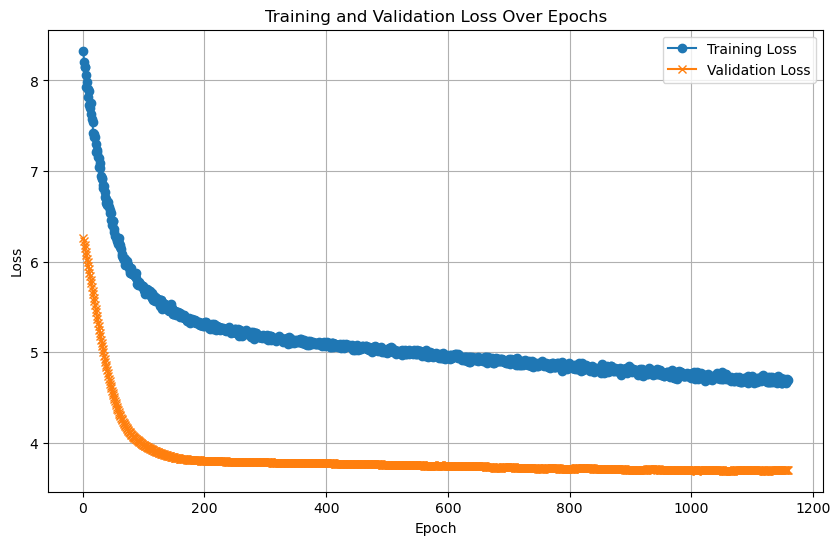

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/20], Loss: 4.6023
Test Batch [20/20], Loss: 4.7699

Test Loss: 5.0809


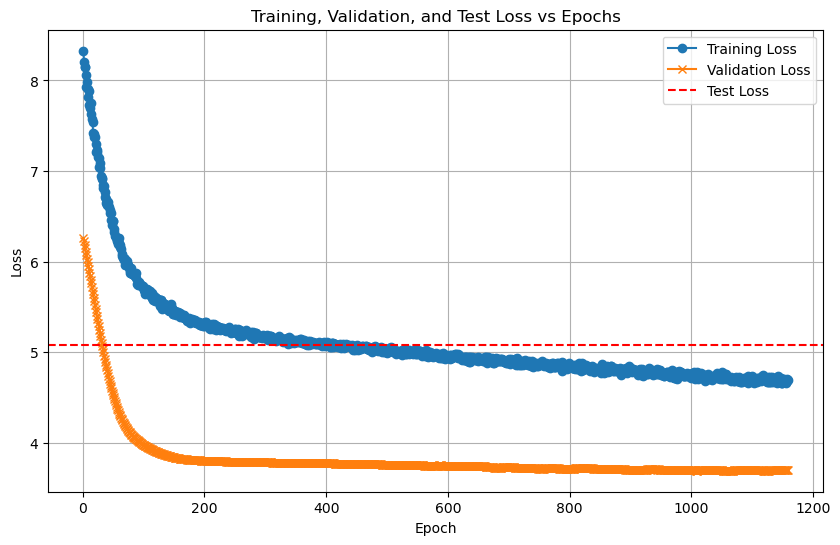

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (260, 128)
Train labels shape: (260,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4886, 128)
Test labels shape: (4886,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 43.08%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.80      0.62         5
           1       0.33      0.20      0.25         5
           2       0.50      0.40      0.44         5
           3       0.00      0.00      0.00         5
           4       0.75      0.60      0.67         5
           5       0.00      0.00      0.00         5
           6       0.56      1.00      0.71         5
           7       0.00      0.00      0.00         5
           8       0.27      0.80      0.40         5
           9       0.00      0.00      0.00         5
          10       1.00      0.80      0.89         5
          11       0.25      0.20      0.22         5
          12       0.57      0.80      0.67         5

    accuracy         

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (260, 128)
Train labels shape: (260,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4886, 128)
Test labels shape: (4886,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5887  |  Val Loss: 2.5729
Validation loss improved from inf to 2.5729.
[Epoch 2/1000] Train Loss: 2.5729  |  Val Loss: 2.5691
Validation loss improved from 2.5729 to 2.5691.
[Epoch 3/1000] Train Loss: 2.5628  |  Val Loss: 2.5671
Validation loss improved from 2.5691 to 2.5671.
[Epoch 4/1000] Train Loss: 2.5549  |  Val Loss: 2.5656
Validation loss improved from 2.5671 to 2.5656.
[Epoch 5/1000] Train Loss: 2.5469  |  Val Loss: 2.5647
Validation loss improved from 2.5656 to 2.5647.
[Epoch 6/1000] Train Loss: 2.5390  |  Val Loss: 2.5635
Validation loss improved from 2.5647 to 2.5635.
[Epoch 7/1000] Train Loss: 2.5299  |  Val Loss: 2.5632
Validation loss improved from 2.5635 to 2.5632.
[Epoch 8/1000] Train Loss: 2.5222  |  Val Loss: 2.5628
Validation loss improved from 2.5632 to 2.5628.
[Epoch 9/1000] Train Loss: 2.5160  |  Val Loss: 2.5629
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 10/1000] Train Loss: 2.5093  |  Val Loss: 2.5623
Validation loss improved from 2.5628 to 2.5623.
[Epoch 11/1000] Train Loss: 2.5020  |  Val Loss: 2.5609
Validation loss improved from 2.5623 to 2.5609.
[Epoch 12/1000] Train Loss: 2.4957  |  Val Loss: 2.5590
Validation loss improved from 2.5609 to 2.5590.
[Epoch 13/1000] Train Loss: 2.4882  |  Val Loss: 2.5556
Validation loss improved from 2.5590 to 2.5556.
[Epoch 14/1000] Train Loss: 2.4848  |  Val Loss: 2.5536
Validation loss improved from 2.5556 to 2.5536.
[Epoch 15/1000] Train Loss: 2.4797  |  Val Loss: 2.5528
Validation loss improved from 2.5536 to 2.5528.
[Epoch 16/1000] Train Loss: 2.4749  |  Val Loss: 2.5526
Validation loss improved from 2.5528 to 2.5526.
[Epoch 17/1000] Train Loss: 2.4699  |  Val Loss: 2.5542
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 18/1000] Train Loss: 2.4649  |  Val Loss: 2.5557
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 19/1000] Train Loss: 2.4609  |  Val Loss: 2.5571
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 20/1000] Train Loss: 2.4575  |  Val Loss: 2.5576
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 21/1000] Train Loss: 2.4539  |  Val Loss: 2.5563
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 22/1000] Train Loss: 2.4505  |  Val Loss: 2.5559
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 23/1000] Train Loss: 2.4480  |  Val Loss: 2.5551
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 24/1000] Train Loss: 2.4450  |  Val Loss: 2.5542
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 25/1000] Train Loss: 2.4420  |  Val Loss: 2.5564
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 26/1000] Train Loss: 2.4389  |  Val Loss: 2.5577
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 27/1000] Train Loss: 2.4360  |  Val Loss: 2.5573
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 2

[Epoch 30/1000] Train Loss: 2.4277  |  Val Loss: 2.5517
Validation loss improved from 2.5526 to 2.5517.
[Epoch 31/1000] Train Loss: 2.4244  |  Val Loss: 2.5465
Validation loss improved from 2.5517 to 2.5465.
[Epoch 32/1000] Train Loss: 2.4223  |  Val Loss: 2.5423
Validation loss improved from 2.5465 to 2.5423.
[Epoch 33/1000] Train Loss: 2.4189  |  Val Loss: 2.5412
Validation loss improved from 2.5423 to 2.5412.
[Epoch 34/1000] Train Loss: 2.4158  |  Val Loss: 2.5398
Validation loss improved from 2.5412 to 2.5398.
[Epoch 35/1000] Train Loss: 2.4132  |  Val Loss: 2.5389
Validation loss improved from 2.5398 to 2.5389.
[Epoch 36/1000] Train Loss: 2.4107  |  Val Loss: 2.5396
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 37/1000] Train Loss: 2.4077  |  Val Loss: 2.5385
Validation loss improved from 2.5389 to 2.5385.
[Epoch 38/1000] Train Loss: 2.4048  |  Val Loss: 2.5377
Validation loss improved from 2.5385 to 2.5377.
[Epoch 39/1000] Train Loss: 2.4014  |  Val Loss: 2.5355
Va

[Epoch 40/1000] Train Loss: 2.3975  |  Val Loss: 2.5243
Validation loss improved from 2.5355 to 2.5243.
[Epoch 41/1000] Train Loss: 2.3937  |  Val Loss: 2.5177
Validation loss improved from 2.5243 to 2.5177.
[Epoch 42/1000] Train Loss: 2.3914  |  Val Loss: 2.5144
Validation loss improved from 2.5177 to 2.5144.
[Epoch 43/1000] Train Loss: 2.3881  |  Val Loss: 2.5134
Validation loss improved from 2.5144 to 2.5134.
[Epoch 44/1000] Train Loss: 2.3855  |  Val Loss: 2.5168
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 45/1000] Train Loss: 2.3820  |  Val Loss: 2.5184
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 46/1000] Train Loss: 2.3777  |  Val Loss: 2.5182
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 47/1000] Train Loss: 2.3745  |  Val Loss: 2.5165
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 48/1000] Train Loss: 2.3715  |  Val Loss: 2.5152
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 49/1000] Train Loss: 2.3683

[Epoch 50/1000] Train Loss: 2.3660  |  Val Loss: 2.5138
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 51/1000] Train Loss: 2.3629  |  Val Loss: 2.5117
Validation loss improved from 2.5134 to 2.5117.
[Epoch 52/1000] Train Loss: 2.3601  |  Val Loss: 2.5089
Validation loss improved from 2.5117 to 2.5089.
[Epoch 53/1000] Train Loss: 2.3574  |  Val Loss: 2.5058
Validation loss improved from 2.5089 to 2.5058.
[Epoch 54/1000] Train Loss: 2.3547  |  Val Loss: 2.5044
Validation loss improved from 2.5058 to 2.5044.
[Epoch 55/1000] Train Loss: 2.3518  |  Val Loss: 2.5042
Validation loss improved from 2.5044 to 2.5042.
[Epoch 56/1000] Train Loss: 2.3493  |  Val Loss: 2.5023
Validation loss improved from 2.5042 to 2.5023.
[Epoch 57/1000] Train Loss: 2.3468  |  Val Loss: 2.5014
Validation loss improved from 2.5023 to 2.5014.
[Epoch 58/1000] Train Loss: 2.3437  |  Val Loss: 2.4999
Validation loss improved from 2.5014 to 2.4999.


[Epoch 59/1000] Train Loss: 2.3410  |  Val Loss: 2.5011
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 60/1000] Train Loss: 2.3388  |  Val Loss: 2.4999
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 61/1000] Train Loss: 2.3356  |  Val Loss: 2.4961
Validation loss improved from 2.4999 to 2.4961.
[Epoch 62/1000] Train Loss: 2.3322  |  Val Loss: 2.4921
Validation loss improved from 2.4961 to 2.4921.
[Epoch 63/1000] Train Loss: 2.3283  |  Val Loss: 2.4879
Validation loss improved from 2.4921 to 2.4879.
[Epoch 64/1000] Train Loss: 2.3249  |  Val Loss: 2.4825
Validation loss improved from 2.4879 to 2.4825.
[Epoch 65/1000] Train Loss: 2.3219  |  Val Loss: 2.4795
Validation loss improved from 2.4825 to 2.4795.
[Epoch 66/1000] Train Loss: 2.3204  |  Val Loss: 2.4742
Validation loss improved from 2.4795 to 2.4742.
[Epoch 67/1000] Train Loss: 2.3187  |  Val Loss: 2.4684
Validation loss improved from 2.4742 to 2.4684.
[Epoch 68/1000] Train Loss: 2.3164  |  Val Loss: 2.4

[Epoch 69/1000] Train Loss: 2.3140  |  Val Loss: 2.4502
Validation loss improved from 2.4556 to 2.4502.
[Epoch 70/1000] Train Loss: 2.3094  |  Val Loss: 2.4487
Validation loss improved from 2.4502 to 2.4487.
[Epoch 71/1000] Train Loss: 2.3055  |  Val Loss: 2.4517
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 72/1000] Train Loss: 2.3007  |  Val Loss: 2.4555
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 73/1000] Train Loss: 2.2963  |  Val Loss: 2.4602
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 74/1000] Train Loss: 2.2929  |  Val Loss: 2.4683
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 75/1000] Train Loss: 2.2905  |  Val Loss: 2.4713
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 76/1000] Train Loss: 2.2870  |  Val Loss: 2.4681
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 77/1000] Train Loss: 2.2825  |  Val Loss: 2.4633
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 78/1000] Train Loss: 2.2785  |  Val Loss: 2.4588
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 79/1000] Train Loss: 2.2755  |  Val Loss: 2.4524
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 80/1000] Train Loss: 2.2714  |  Val Loss: 2.4486
Validation loss improved from 2.4487 to 2.4486.
[Epoch 81/1000] Train Loss: 2.2679  |  Val Loss: 2.4468
Validation loss improved from 2.4486 to 2.4468.
[Epoch 82/1000] Train Loss: 2.2644  |  Val Loss: 2.4488
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 83/1000] Train Loss: 2.2615  |  Val Loss: 2.4499
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 84/1000] Train Loss: 2.2577  |  Val Loss: 2.4508
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 85/1000] Train Loss: 2.2545  |  Val Loss: 2.4533
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 86/1000] Train Loss: 2.2510  |  Val Loss: 2.4522
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 87/1000] Train 

[Epoch 88/1000] Train Loss: 2.2435  |  Val Loss: 2.4438
Validation loss improved from 2.4468 to 2.4438.
[Epoch 89/1000] Train Loss: 2.2402  |  Val Loss: 2.4362
Validation loss improved from 2.4438 to 2.4362.
[Epoch 90/1000] Train Loss: 2.2352  |  Val Loss: 2.4219
Validation loss improved from 2.4362 to 2.4219.
[Epoch 91/1000] Train Loss: 2.2336  |  Val Loss: 2.4182
Validation loss improved from 2.4219 to 2.4182.
[Epoch 92/1000] Train Loss: 2.2298  |  Val Loss: 2.4392
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 93/1000] Train Loss: 2.2284  |  Val Loss: 2.4496
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 94/1000] Train Loss: 2.2267  |  Val Loss: 2.4519
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 95/1000] Train Loss: 2.2239  |  Val Loss: 2.4525
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 96/1000] Train Loss: 2.2197  |  Val Loss: 2.4461
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 97/1000] Train Loss: 2.2143

[Epoch 98/1000] Train Loss: 2.2085  |  Val Loss: 2.4295
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 99/1000] Train Loss: 2.2045  |  Val Loss: 2.4156
Validation loss improved from 2.4182 to 2.4156.
[Epoch 100/1000] Train Loss: 2.2012  |  Val Loss: 2.4089
Validation loss improved from 2.4156 to 2.4089.
[Epoch 101/1000] Train Loss: 2.1987  |  Val Loss: 2.4036
Validation loss improved from 2.4089 to 2.4036.
[Epoch 102/1000] Train Loss: 2.1942  |  Val Loss: 2.4055
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 103/1000] Train Loss: 2.1898  |  Val Loss: 2.4281
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 104/1000] Train Loss: 2.1872  |  Val Loss: 2.4380
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 105/1000] Train Loss: 2.1870  |  Val Loss: 2.4393
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 106/1000] Train Loss: 2.1825  |  Val Loss: 2.4330
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 107/1000] Trai

[Epoch 108/1000] Train Loss: 2.1711  |  Val Loss: 2.4135
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 109/1000] Train Loss: 2.1665  |  Val Loss: 2.4063
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 110/1000] Train Loss: 2.1623  |  Val Loss: 2.4033
Validation loss improved from 2.4036 to 2.4033.
[Epoch 111/1000] Train Loss: 2.1590  |  Val Loss: 2.3983
Validation loss improved from 2.4033 to 2.3983.
[Epoch 112/1000] Train Loss: 2.1554  |  Val Loss: 2.3949
Validation loss improved from 2.3983 to 2.3949.
[Epoch 113/1000] Train Loss: 2.1516  |  Val Loss: 2.3965
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 114/1000] Train Loss: 2.1479  |  Val Loss: 2.3947
Validation loss improved from 2.3949 to 2.3947.
[Epoch 115/1000] Train Loss: 2.1440  |  Val Loss: 2.3909
Validation loss improved from 2.3947 to 2.3909.
[Epoch 116/1000] Train Loss: 2.1389  |  Val Loss: 2.3875
Validation loss improved from 2.3909 to 2.3875.


[Epoch 117/1000] Train Loss: 2.1342  |  Val Loss: 2.3840
Validation loss improved from 2.3875 to 2.3840.
[Epoch 118/1000] Train Loss: 2.1299  |  Val Loss: 2.3841
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 119/1000] Train Loss: 2.1272  |  Val Loss: 2.4012
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 120/1000] Train Loss: 2.1240  |  Val Loss: 2.4056
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 121/1000] Train Loss: 2.1212  |  Val Loss: 2.4011
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 122/1000] Train Loss: 2.1164  |  Val Loss: 2.3936
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 123/1000] Train Loss: 2.1117  |  Val Loss: 2.3810
Validation loss improved from 2.3840 to 2.3810.
[Epoch 124/1000] Train Loss: 2.1071  |  Val Loss: 2.3596
Validation loss improved from 2.3810 to 2.3596.
[Epoch 125/1000] Train Loss: 2.1025  |  Val Loss: 2.3480
Validation loss improved from 2.3596 to 2.3480.


[Epoch 126/1000] Train Loss: 2.0988  |  Val Loss: 2.3408
Validation loss improved from 2.3480 to 2.3408.
[Epoch 127/1000] Train Loss: 2.0939  |  Val Loss: 2.3385
Validation loss improved from 2.3408 to 2.3385.
[Epoch 128/1000] Train Loss: 2.0894  |  Val Loss: 2.3400
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 129/1000] Train Loss: 2.0849  |  Val Loss: 2.3407
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 130/1000] Train Loss: 2.0806  |  Val Loss: 2.3382
Validation loss improved from 2.3385 to 2.3382.
[Epoch 131/1000] Train Loss: 2.0777  |  Val Loss: 2.3277
Validation loss improved from 2.3382 to 2.3277.
[Epoch 132/1000] Train Loss: 2.0751  |  Val Loss: 2.3267
Validation loss improved from 2.3277 to 2.3267.
[Epoch 133/1000] Train Loss: 2.0710  |  Val Loss: 2.3290
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 134/1000] Train Loss: 2.0664  |  Val Loss: 2.3283
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 135/1000] Train Loss: 2.

[Epoch 136/1000] Train Loss: 2.0584  |  Val Loss: 2.3241
Validation loss improved from 2.3267 to 2.3241.
[Epoch 137/1000] Train Loss: 2.0545  |  Val Loss: 2.2998
Validation loss improved from 2.3241 to 2.2998.
[Epoch 138/1000] Train Loss: 2.0558  |  Val Loss: 2.2933
Validation loss improved from 2.2998 to 2.2933.
[Epoch 139/1000] Train Loss: 2.0523  |  Val Loss: 2.3003
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 140/1000] Train Loss: 2.0458  |  Val Loss: 2.3132
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 141/1000] Train Loss: 2.0402  |  Val Loss: 2.3238
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 142/1000] Train Loss: 2.0336  |  Val Loss: 2.3282
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 143/1000] Train Loss: 2.0287  |  Val Loss: 2.3325
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 144/1000] Train Loss: 2.0244  |  Val Loss: 2.3367
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 145/1000] Tr

[Epoch 146/1000] Train Loss: 2.0203  |  Val Loss: 2.3588
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 147/1000] Train Loss: 2.0155  |  Val Loss: 2.3533
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 148/1000] Train Loss: 2.0101  |  Val Loss: 2.3411
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 149/1000] Train Loss: 2.0042  |  Val Loss: 2.3326
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 150/1000] Train Loss: 2.0001  |  Val Loss: 2.3250
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 151/1000] Train Loss: 1.9950  |  Val Loss: 2.3187
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 152/1000] Train Loss: 1.9899  |  Val Loss: 2.3159
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 153/1000] Train Loss: 1.9852  |  Val Loss: 2.3116
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 154/1000] Train Loss: 1.9812  |  Val Loss: 2.3082
!! Validation loss did NOT improve !! Patience: 1

[Epoch 156/1000] Train Loss: 1.9733  |  Val Loss: 2.3104
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 157/1000] Train Loss: 1.9698  |  Val Loss: 2.3063
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 158/1000] Train Loss: 1.9658  |  Val Loss: 2.3029
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 159/1000] Train Loss: 1.9612  |  Val Loss: 2.2996
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 160/1000] Train Loss: 1.9573  |  Val Loss: 2.2955
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 161/1000] Train Loss: 1.9520  |  Val Loss: 2.2950
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 162/1000] Train Loss: 1.9478  |  Val Loss: 2.2898
Validation loss improved from 2.2933 to 2.2898.


[Epoch 163/1000] Train Loss: 1.9437  |  Val Loss: 2.2848
Validation loss improved from 2.2898 to 2.2848.
[Epoch 164/1000] Train Loss: 1.9401  |  Val Loss: 2.2814
Validation loss improved from 2.2848 to 2.2814.
[Epoch 165/1000] Train Loss: 1.9364  |  Val Loss: 2.2796
Validation loss improved from 2.2814 to 2.2796.
[Epoch 166/1000] Train Loss: 1.9325  |  Val Loss: 2.2795
Validation loss improved from 2.2796 to 2.2795.
[Epoch 167/1000] Train Loss: 1.9293  |  Val Loss: 2.2814
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 168/1000] Train Loss: 1.9286  |  Val Loss: 2.2806
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 169/1000] Train Loss: 1.9217  |  Val Loss: 2.2827
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 170/1000] Train Loss: 1.9155  |  Val Loss: 2.2864
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 171/1000] Train Loss: 1.9136  |  Val Loss: 2.2842
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 172/1000] Train Lo

[Epoch 174/1000] Train Loss: 1.8981  |  Val Loss: 2.2584
Validation loss improved from 2.2692 to 2.2584.
[Epoch 175/1000] Train Loss: 1.8969  |  Val Loss: 2.2346
Validation loss improved from 2.2584 to 2.2346.
[Epoch 176/1000] Train Loss: 1.8984  |  Val Loss: 2.2329
Validation loss improved from 2.2346 to 2.2329.
[Epoch 177/1000] Train Loss: 1.8927  |  Val Loss: 2.2402
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 178/1000] Train Loss: 1.8835  |  Val Loss: 2.2508
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 179/1000] Train Loss: 1.8770  |  Val Loss: 2.2615
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 180/1000] Train Loss: 1.8722  |  Val Loss: 2.2686
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 181/1000] Train Loss: 1.8692  |  Val Loss: 2.2716
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 182/1000] Train Loss: 1.8651  |  Val Loss: 2.2679
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 183/1000] Tr

[Epoch 184/1000] Train Loss: 1.8565  |  Val Loss: 2.2601
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 185/1000] Train Loss: 1.8527  |  Val Loss: 2.2593
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 186/1000] Train Loss: 1.8511  |  Val Loss: 2.2573
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 187/1000] Train Loss: 1.8469  |  Val Loss: 2.2511
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 188/1000] Train Loss: 1.8421  |  Val Loss: 2.2467
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 189/1000] Train Loss: 1.8376  |  Val Loss: 2.2532
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 190/1000] Train Loss: 1.8326  |  Val Loss: 2.2514
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 191/1000] Train Loss: 1.8285  |  Val Loss: 2.2442
!! Validation loss did NOT improve !! Patience: 15/100


[Epoch 192/1000] Train Loss: 1.8234  |  Val Loss: 2.2401
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 193/1000] Train Loss: 1.8194  |  Val Loss: 2.2362
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 194/1000] Train Loss: 1.8150  |  Val Loss: 2.2327
Validation loss improved from 2.2329 to 2.2327.
[Epoch 195/1000] Train Loss: 1.8112  |  Val Loss: 2.2290
Validation loss improved from 2.2327 to 2.2290.
[Epoch 196/1000] Train Loss: 1.8071  |  Val Loss: 2.2325
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 197/1000] Train Loss: 1.8039  |  Val Loss: 2.2393
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 198/1000] Train Loss: 1.8036  |  Val Loss: 2.2420
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 199/1000] Train Loss: 1.7999  |  Val Loss: 2.2386
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 200/1000] Train Loss: 1.7927  |  Val Loss: 2.2369
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 201/

[Epoch 204/1000] Train Loss: 1.7769  |  Val Loss: 2.2029
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 205/1000] Train Loss: 1.7719  |  Val Loss: 2.2096
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 206/1000] Train Loss: 1.7675  |  Val Loss: 2.2169
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 207/1000] Train Loss: 1.7631  |  Val Loss: 2.2165
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 208/1000] Train Loss: 1.7590  |  Val Loss: 2.2125
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 209/1000] Train Loss: 1.7549  |  Val Loss: 2.2093
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 210/1000] Train Loss: 1.7511  |  Val Loss: 2.2070
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 211/1000] Train Loss: 1.7473  |  Val Loss: 2.2021
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 212/1000] Train Loss: 1.7428  |  Val Loss: 2.2012
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 213/1000] Train Loss: 1.7389  |  Val Loss: 2.2028
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 214/1000] Train Loss: 1.7352  |  Val Loss: 2.2062
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 215/1000] Train Loss: 1.7318  |  Val Loss: 2.2054
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 216/1000] Train Loss: 1.7276  |  Val Loss: 2.2168
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 217/1000] Train Loss: 1.7264  |  Val Loss: 2.2567
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 218/1000] Train Loss: 1.7312  |  Val Loss: 2.2687
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 219/1000] Train Loss: 1.7277  |  Val Loss: 2.2559
!! Validation loss did NOT improve !! Patience: 1

[Epoch 223/1000] Train Loss: 1.7045  |  Val Loss: 2.2008
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 224/1000] Train Loss: 1.6997  |  Val Loss: 2.2016
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 225/1000] Train Loss: 1.6937  |  Val Loss: 2.2032
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 226/1000] Train Loss: 1.6906  |  Val Loss: 2.2036
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 227/1000] Train Loss: 1.6870  |  Val Loss: 2.2029
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 228/1000] Train Loss: 1.6837  |  Val Loss: 2.1982
Validation loss improved from 2.2008 to 2.1982.
[Epoch 229/1000] Train Loss: 1.6793  |  Val Loss: 2.1942
Validation loss improved from 2.1982 to 2.1942.
[Epoch 230/1000] Train Loss: 1.6748  |  Val Loss: 2.1926
Validation loss improved from 2.1942 to 2.1926.
[Epoch 231/1000] Train Loss: 1.6703  |  Val Loss: 2.1964
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 232/1000] Train Loss: 1.6688  |  Val Loss: 2.2020
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 233/1000] Train Loss: 1.6653  |  Val Loss: 2.2092
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 234/1000] Train Loss: 1.6603  |  Val Loss: 2.2069
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 235/1000] Train Loss: 1.6563  |  Val Loss: 2.1841
Validation loss improved from 2.1926 to 2.1841.
[Epoch 236/1000] Train Loss: 1.6578  |  Val Loss: 2.1238
Validation loss improved from 2.1841 to 2.1238.
[Epoch 237/1000] Train Loss: 1.6755  |  Val Loss: 2.1150
Validation loss improved from 2.1238 to 2.1150.
[Epoch 238/1000] Train Loss: 1.6719  |  Val Loss: 2.1321
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 239/1000] Train Loss: 1.6501  |  Val Loss: 2.1618
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 240/1000] Train Loss: 1.6391  |  Val Loss: 2.1898
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 241/1000] Tr

[Epoch 242/1000] Train Loss: 1.6328  |  Val Loss: 2.2127
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 243/1000] Train Loss: 1.6304  |  Val Loss: 2.2107
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 244/1000] Train Loss: 1.6267  |  Val Loss: 2.2023
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 245/1000] Train Loss: 1.6233  |  Val Loss: 2.1977
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 246/1000] Train Loss: 1.6204  |  Val Loss: 2.1901
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 247/1000] Train Loss: 1.6159  |  Val Loss: 2.1800
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 248/1000] Train Loss: 1.6112  |  Val Loss: 2.1743
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 249/1000] Train Loss: 1.6085  |  Val Loss: 2.1740
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 250/1000] Train Loss: 1.6057  |  Val Loss: 2.1775
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 251/1000] Train Loss: 1.6015  |  Val Loss: 2.1920
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 252/1000] Train Loss: 1.6017  |  Val Loss: 2.1982
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 253/1000] Train Loss: 1.6000  |  Val Loss: 2.1932
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 254/1000] Train Loss: 1.5957  |  Val Loss: 2.1841
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 255/1000] Train Loss: 1.5906  |  Val Loss: 2.1713
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 256/1000] Train Loss: 1.5862  |  Val Loss: 2.1744
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 257/1000] Train Loss: 1.5862  |  Val Loss: 2.2201
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 258/1000] Train Loss: 1.5894  |  Val Loss: 2.2367
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 259/1000] Train Loss: 1.5871  |  Val Loss: 2.2300
!! Validation loss did NOT improve !! Patience:

[Epoch 262/1000] Train Loss: 1.5647  |  Val Loss: 2.1715
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 263/1000] Train Loss: 1.5603  |  Val Loss: 2.1625
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 264/1000] Train Loss: 1.5578  |  Val Loss: 2.1524
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 265/1000] Train Loss: 1.5547  |  Val Loss: 2.1407
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 266/1000] Train Loss: 1.5519  |  Val Loss: 2.1465
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 267/1000] Train Loss: 1.5542  |  Val Loss: 2.1572
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 268/1000] Train Loss: 1.5515  |  Val Loss: 2.1662
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 269/1000] Train Loss: 1.5475  |  Val Loss: 2.1749
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 270/1000] Train Loss: 1.5429  |  Val Loss: 2.1759
!! Validation loss did NOT improve !! Patience:

[Epoch 271/1000] Train Loss: 1.5378  |  Val Loss: 2.1702
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 272/1000] Train Loss: 1.5331  |  Val Loss: 2.1678
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 273/1000] Train Loss: 1.5310  |  Val Loss: 2.1565
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 274/1000] Train Loss: 1.5293  |  Val Loss: 2.1284
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 275/1000] Train Loss: 1.5268  |  Val Loss: 2.1220
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 276/1000] Train Loss: 1.5226  |  Val Loss: 2.1296
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 277/1000] Train Loss: 1.5165  |  Val Loss: 2.1432
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 278/1000] Train Loss: 1.5124  |  Val Loss: 2.1594
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 279/1000] Train Loss: 1.5109  |  Val Loss: 2.1731
!! Validation loss did NOT improve !! Patience:

[Epoch 280/1000] Train Loss: 1.5086  |  Val Loss: 2.1709
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 281/1000] Train Loss: 1.5045  |  Val Loss: 2.1669
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 282/1000] Train Loss: 1.5021  |  Val Loss: 2.1573
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 283/1000] Train Loss: 1.4980  |  Val Loss: 2.1396
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 284/1000] Train Loss: 1.4942  |  Val Loss: 2.1349
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 285/1000] Train Loss: 1.4916  |  Val Loss: 2.1405
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 286/1000] Train Loss: 1.4890  |  Val Loss: 2.1635
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 287/1000] Train Loss: 1.4875  |  Val Loss: 2.1751
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 288/1000] Train Loss: 1.4864  |  Val Loss: 2.1815
!! Validation loss did NOT improve !! Patience:

[Epoch 293/1000] Train Loss: 1.4680  |  Val Loss: 2.1389
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 294/1000] Train Loss: 1.4651  |  Val Loss: 2.1412
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 295/1000] Train Loss: 1.4627  |  Val Loss: 2.1410
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 296/1000] Train Loss: 1.4598  |  Val Loss: 2.1412
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 297/1000] Train Loss: 1.4553  |  Val Loss: 2.1536
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 298/1000] Train Loss: 1.4536  |  Val Loss: 2.1636
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 299/1000] Train Loss: 1.4512  |  Val Loss: 2.1656
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 300/1000] Train Loss: 1.4486  |  Val Loss: 2.1617
!! Validation loss did NOT improve !! Patience: 63/100


[Epoch 301/1000] Train Loss: 1.4463  |  Val Loss: 2.1457
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 302/1000] Train Loss: 1.4425  |  Val Loss: 2.1386
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 303/1000] Train Loss: 1.4399  |  Val Loss: 2.1365
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 304/1000] Train Loss: 1.4372  |  Val Loss: 2.1373
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 305/1000] Train Loss: 1.4342  |  Val Loss: 2.1394
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 306/1000] Train Loss: 1.4315  |  Val Loss: 2.1444
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 307/1000] Train Loss: 1.4293  |  Val Loss: 2.1472
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 308/1000] Train Loss: 1.4260  |  Val Loss: 2.1505
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 309/1000] Train Loss: 1.4230  |  Val Loss: 2.1529
!! Validation loss did NOT improve !! Patience:

[Epoch 312/1000] Train Loss: 1.4160  |  Val Loss: 2.1566
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 313/1000] Train Loss: 1.4130  |  Val Loss: 2.1619
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 314/1000] Train Loss: 1.4102  |  Val Loss: 2.1612
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 315/1000] Train Loss: 1.4082  |  Val Loss: 2.1601
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 316/1000] Train Loss: 1.4056  |  Val Loss: 2.1532
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 317/1000] Train Loss: 1.4027  |  Val Loss: 2.1504
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 318/1000] Train Loss: 1.4008  |  Val Loss: 2.1485
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 319/1000] Train Loss: 1.3972  |  Val Loss: 2.1525
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 320/1000] Train Loss: 1.3952  |  Val Loss: 2.1583
!! Validation loss did NOT improve !! Patience:

[Epoch 322/1000] Train Loss: 1.3895  |  Val Loss: 2.1489
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 323/1000] Train Loss: 1.3873  |  Val Loss: 2.1311
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 324/1000] Train Loss: 1.3875  |  Val Loss: 2.1300
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 325/1000] Train Loss: 1.3839  |  Val Loss: 2.1315
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 326/1000] Train Loss: 1.3817  |  Val Loss: 2.1088
Validation loss improved from 2.1150 to 2.1088.
[Epoch 327/1000] Train Loss: 1.3904  |  Val Loss: 2.1315
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 328/1000] Train Loss: 1.3755  |  Val Loss: 2.2907
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 329/1000] Train Loss: 1.4248  |  Val Loss: 2.3735
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 330/1000] Train Loss: 1.4455  |  Val Loss: 2.3941
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 334/1000] Train Loss: 1.3901  |  Val Loss: 2.2724
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 335/1000] Train Loss: 1.3810  |  Val Loss: 2.2447
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 336/1000] Train Loss: 1.3726  |  Val Loss: 2.2201
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 337/1000] Train Loss: 1.3652  |  Val Loss: 2.2010
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 338/1000] Train Loss: 1.3593  |  Val Loss: 2.1845
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 339/1000] Train Loss: 1.3541  |  Val Loss: 2.1710
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 340/1000] Train Loss: 1.3510  |  Val Loss: 2.1602
!! Validation loss did NOT improve !! Patience: 14/100


[Epoch 341/1000] Train Loss: 1.3478  |  Val Loss: 2.1554
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 342/1000] Train Loss: 1.3452  |  Val Loss: 2.1528
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 343/1000] Train Loss: 1.3436  |  Val Loss: 2.1519
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 344/1000] Train Loss: 1.3407  |  Val Loss: 2.1538
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 345/1000] Train Loss: 1.3380  |  Val Loss: 2.1569
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 346/1000] Train Loss: 1.3359  |  Val Loss: 2.1589
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 347/1000] Train Loss: 1.3339  |  Val Loss: 2.1514
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 348/1000] Train Loss: 1.3340  |  Val Loss: 2.1232
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 349/1000] Train Loss: 1.3365  |  Val Loss: 2.1249
!! Validation loss did NOT improve !! Patience:

[Epoch 351/1000] Train Loss: 1.3245  |  Val Loss: 2.1786
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 352/1000] Train Loss: 1.3251  |  Val Loss: 2.2011
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 353/1000] Train Loss: 1.3308  |  Val Loss: 2.2081
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 354/1000] Train Loss: 1.3289  |  Val Loss: 2.1988
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 355/1000] Train Loss: 1.3217  |  Val Loss: 2.1882
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 356/1000] Train Loss: 1.3167  |  Val Loss: 2.1765
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 357/1000] Train Loss: 1.3140  |  Val Loss: 2.1715
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 358/1000] Train Loss: 1.3123  |  Val Loss: 2.1696
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 359/1000] Train Loss: 1.3120  |  Val Loss: 2.1675
!! Validation loss did NOT improve !! Patience:

[Epoch 360/1000] Train Loss: 1.3107  |  Val Loss: 2.1724
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 361/1000] Train Loss: 1.3096  |  Val Loss: 2.1780
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 362/1000] Train Loss: 1.3071  |  Val Loss: 2.1785
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 363/1000] Train Loss: 1.3049  |  Val Loss: 2.1785
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 364/1000] Train Loss: 1.3024  |  Val Loss: 2.1753
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 365/1000] Train Loss: 1.2995  |  Val Loss: 2.1739
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 366/1000] Train Loss: 1.2970  |  Val Loss: 2.1765
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 367/1000] Train Loss: 1.2963  |  Val Loss: 2.1941
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 368/1000] Train Loss: 1.2955  |  Val Loss: 2.2032
!! Validation loss did NOT improve !! Patience:

[Epoch 369/1000] Train Loss: 1.2937  |  Val Loss: 2.1979
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 370/1000] Train Loss: 1.2907  |  Val Loss: 2.1899
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 371/1000] Train Loss: 1.2878  |  Val Loss: 2.1805
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 372/1000] Train Loss: 1.2857  |  Val Loss: 2.1745
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 373/1000] Train Loss: 1.2840  |  Val Loss: 2.1672
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 374/1000] Train Loss: 1.2832  |  Val Loss: 2.1531
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 375/1000] Train Loss: 1.2850  |  Val Loss: 2.1556
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 376/1000] Train Loss: 1.2832  |  Val Loss: 2.1612
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 377/1000] Train Loss: 1.2798  |  Val Loss: 2.1701
!! Validation loss did NOT improve !! Patience:

[Epoch 380/1000] Train Loss: 1.2753  |  Val Loss: 2.1722
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 381/1000] Train Loss: 1.2723  |  Val Loss: 2.1668
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 382/1000] Train Loss: 1.2687  |  Val Loss: 2.1600
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 383/1000] Train Loss: 1.2680  |  Val Loss: 2.1597
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 384/1000] Train Loss: 1.2678  |  Val Loss: 2.1624
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 385/1000] Train Loss: 1.2658  |  Val Loss: 2.1630
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 386/1000] Train Loss: 1.2637  |  Val Loss: 2.1679
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 387/1000] Train Loss: 1.2616  |  Val Loss: 2.1719
!! Validation loss did NOT improve !! Patience: 61/100


[Epoch 388/1000] Train Loss: 1.2592  |  Val Loss: 2.1754
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 389/1000] Train Loss: 1.2597  |  Val Loss: 2.1812
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 390/1000] Train Loss: 1.2615  |  Val Loss: 2.1882
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 391/1000] Train Loss: 1.2611  |  Val Loss: 2.1910
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 392/1000] Train Loss: 1.2571  |  Val Loss: 2.1889
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 393/1000] Train Loss: 1.2524  |  Val Loss: 2.1828
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 394/1000] Train Loss: 1.2501  |  Val Loss: 2.1790
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 395/1000] Train Loss: 1.2493  |  Val Loss: 2.1746
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 396/1000] Train Loss: 1.2477  |  Val Loss: 2.1773
!! Validation loss did NOT improve !! Patience:

[Epoch 398/1000] Train Loss: 1.2439  |  Val Loss: 2.1857
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 399/1000] Train Loss: 1.2429  |  Val Loss: 2.1836
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 400/1000] Train Loss: 1.2419  |  Val Loss: 2.1689
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 401/1000] Train Loss: 1.2414  |  Val Loss: 2.1699
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 402/1000] Train Loss: 1.2408  |  Val Loss: 2.1814
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 403/1000] Train Loss: 1.2402  |  Val Loss: 2.1906
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 404/1000] Train Loss: 1.2374  |  Val Loss: 2.1948
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 405/1000] Train Loss: 1.2335  |  Val Loss: 2.1939
!! Validation loss did NOT improve !! Patience: 79/100


[Epoch 406/1000] Train Loss: 1.2321  |  Val Loss: 2.1921
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 407/1000] Train Loss: 1.2292  |  Val Loss: 2.1902
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 408/1000] Train Loss: 1.2277  |  Val Loss: 2.1869
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 409/1000] Train Loss: 1.2262  |  Val Loss: 2.1847
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 410/1000] Train Loss: 1.2247  |  Val Loss: 2.1875
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 411/1000] Train Loss: 1.2233  |  Val Loss: 2.1856
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 412/1000] Train Loss: 1.2215  |  Val Loss: 2.1860
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 413/1000] Train Loss: 1.2203  |  Val Loss: 2.1888
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 414/1000] Train Loss: 1.2203  |  Val Loss: 2.1831
!! Validation loss did NOT improve !! Patience:

[Epoch 418/1000] Train Loss: 1.2160  |  Val Loss: 2.1966
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 419/1000] Train Loss: 1.2133  |  Val Loss: 2.2140
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 420/1000] Train Loss: 1.2122  |  Val Loss: 2.2239
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 421/1000] Train Loss: 1.2118  |  Val Loss: 2.2269
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 422/1000] Train Loss: 1.2103  |  Val Loss: 2.2169
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 423/1000] Train Loss: 1.2088  |  Val Loss: 2.1756
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 424/1000] Train Loss: 1.2129  |  Val Loss: 2.1662
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 425/1000] Train Loss: 1.2129  |  Val Loss: 2.1896
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 426/1000] Train Loss: 1.2063  |  Val Loss: 2.2300
!! Validation loss did NOT improve !! Patience:

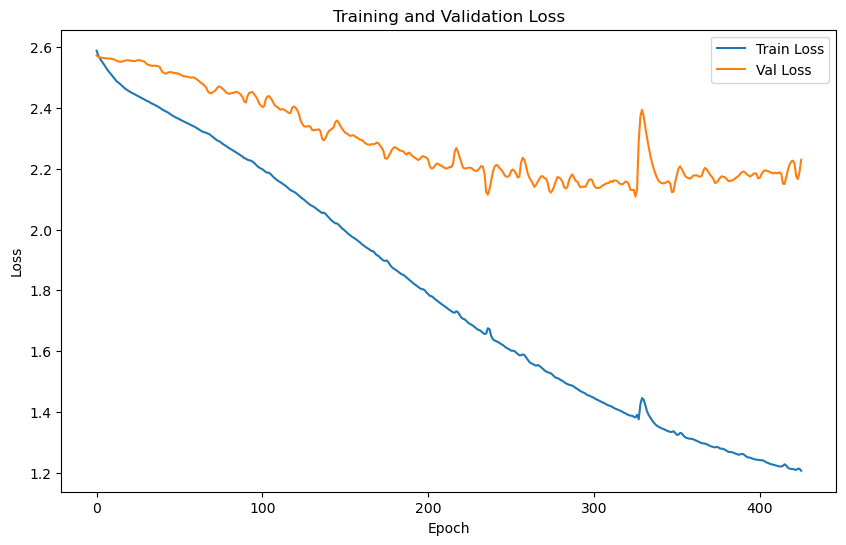

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.7817 | Test Accuracy: 45.27%


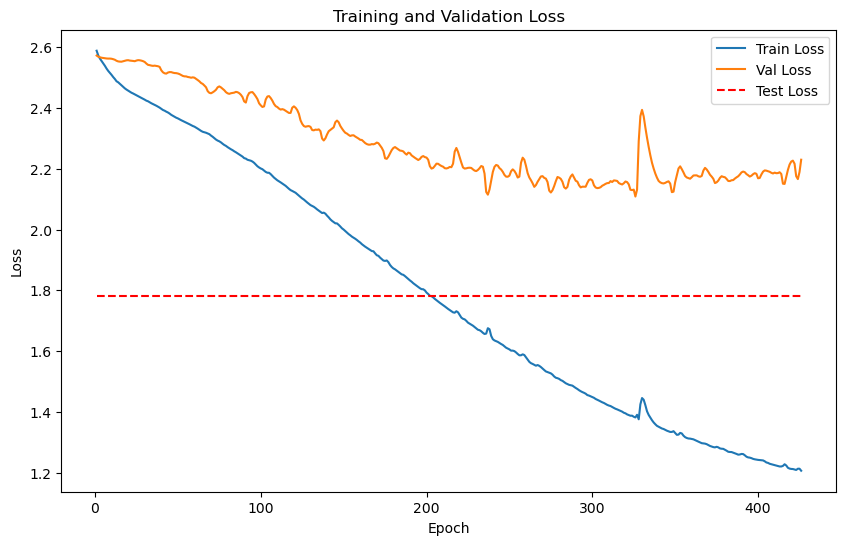

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 260 samples with 64 features each
LOG: Labels shape: (260,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4886 samples with 64 features each
LOG: Labels shape: (4886,)


Train embeddings shape: (260, 64), 
Train labels shape: (260,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (4886, 64), 
Test labels shape: (4886,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}
Training batch size: 260


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5408
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.6150
    Batch [2/2], Val Loss: 0.5000
Epoch [1/2000], Avg Train Loss: 0.5408, Avg Val Loss: 0.5575

Validation loss improved from inf to 0.5575. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.5410
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.6148
    Batch [2/2], Val Loss: 0.5000
Epoch [2/2000], Avg Train Loss: 0.5410, Avg Val Loss: 0.5574

Validation loss improved from 0.5575 to 0.5574. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.5399
LOG: Epoch [3/2000] - Validation


    Batch [1/2], Val Loss: 0.6142
    Batch [2/2], Val Loss: 0.5000
Epoch [3/2000], Avg Train Loss: 0.5399, Avg Val Loss: 0.5571

Validation loss improved from 0.5574 to 0.5571. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.5385
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.6127
    Batch [2/2], Val Loss: 0.5000
Epoch [4/2000], Avg Train Loss: 0.5385, Avg Val Loss: 0.5564

Validation loss improved from 0.5571 to 0.5564. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.5397
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.6114
    Batch [2/2], Val Loss: 0.5000
Epoch [5/2000], Avg Train Loss: 0.5397, Avg Val Loss: 0.5557

Validation loss improved from 0.5564 to 0.5557. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.5354
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.6106
    Batch [2/2], Val Loss: 0.5000
Epoch [6/2000], Avg Train Loss: 0.5354, Avg Val Loss: 0.5553

Validation loss improved from 0.5557 to 0.5553. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.5348
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.6094
    Batch [2/2], Val Loss: 0.5000
Epoch [7/2000], Avg Train Loss: 0.5348, Avg Val Loss: 0.5547

Validation loss improved from 0.5553 to 0.5547. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.5352
LOG: Epoch [8/2000] - Validation


    Batch [1/2], Val Loss: 0.6085
    Batch [2/2], Val Loss: 0.5000
Epoch [8/2000], Avg Train Loss: 0.5352, Avg Val Loss: 0.5543

Validation loss improved from 0.5547 to 0.5543. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.5380
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.6076
    Batch [2/2], Val Loss: 0.5000
Epoch [9/2000], Avg Train Loss: 0.5380, Avg Val Loss: 0.5538

Validation loss improved from 0.5543 to 0.5538. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.5345
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.6062
    Batch [2/2], Val Loss: 0.5000
Epoch [10/2000], Avg Train Loss: 0.5345, Avg Val Loss: 0.5531

Validation loss improved from 0.5538 to 0.5531. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.5323
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.6050
    Batch [2/2], Val Loss: 0.5000
Epoch [11/2000], Avg Train Loss: 0.5323, Avg Val Loss: 0.5525

Validation loss improved from 0.5531 to 0.5525. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.5349
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.6030
    Batch [2/2], Val Loss: 0.5000
Epoch [12/2000], Avg Train Loss: 0.5349, Avg Val Loss: 0.5515

Validation loss improved from 0.5525 to 0.5515. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.5319
LOG: Epoch [13/2000] - Validation


    Batch [1/2], Val Loss: 0.6009
    Batch [2/2], Val Loss: 0.5000
Epoch [13/2000], Avg Train Loss: 0.5319, Avg Val Loss: 0.5505

Validation loss improved from 0.5515 to 0.5505. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.5305
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5992
    Batch [2/2], Val Loss: 0.5000
Epoch [14/2000], Avg Train Loss: 0.5305, Avg Val Loss: 0.5496

Validation loss improved from 0.5505 to 0.5496. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.5309
LOG: Epoch [15/2000] - Validation


    Batch [1/2], Val Loss: 0.5977
    Batch [2/2], Val Loss: 0.5000
Epoch [15/2000], Avg Train Loss: 0.5309, Avg Val Loss: 0.5488

Validation loss improved from 0.5496 to 0.5488. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.5278
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5954
    Batch [2/2], Val Loss: 0.5000
Epoch [16/2000], Avg Train Loss: 0.5278, Avg Val Loss: 0.5477

Validation loss improved from 0.5488 to 0.5477. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.5261
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5928
    Batch [2/2], Val Loss: 0.5000
Epoch [17/2000], Avg Train Loss: 0.5261, Avg Val Loss: 0.5464

Validation loss improved from 0.5477 to 0.5464. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.5266
LOG: Epoch [18/2000] - Validation


    Batch [1/2], Val Loss: 0.5901
    Batch [2/2], Val Loss: 0.5000
Epoch [18/2000], Avg Train Loss: 0.5266, Avg Val Loss: 0.5450

Validation loss improved from 0.5464 to 0.5450. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.5250
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5875
    Batch [2/2], Val Loss: 0.5000
Epoch [19/2000], Avg Train Loss: 0.5250, Avg Val Loss: 0.5437

Validation loss improved from 0.5450 to 0.5437. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.5232
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5852
    Batch [2/2], Val Loss: 0.5000
Epoch [20/2000], Avg Train Loss: 0.5232, Avg Val Loss: 0.5426

Validation loss improved from 0.5437 to 0.5426. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.5256
LOG: Epoch [21/2000] - Validation


    Batch [1/2], Val Loss: 0.5831
    Batch [2/2], Val Loss: 0.5000
Epoch [21/2000], Avg Train Loss: 0.5256, Avg Val Loss: 0.5416

Validation loss improved from 0.5426 to 0.5416. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.5242
LOG: Epoch [22/2000] - Validation


    Batch [1/2], Val Loss: 0.5810
    Batch [2/2], Val Loss: 0.5000
Epoch [22/2000], Avg Train Loss: 0.5242, Avg Val Loss: 0.5405

Validation loss improved from 0.5416 to 0.5405. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.5251
LOG: Epoch [23/2000] - Validation


    Batch [1/2], Val Loss: 0.5788
    Batch [2/2], Val Loss: 0.5000
Epoch [23/2000], Avg Train Loss: 0.5251, Avg Val Loss: 0.5394

Validation loss improved from 0.5405 to 0.5394. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.5215
LOG: Epoch [24/2000] - Validation


    Batch [1/2], Val Loss: 0.5754
    Batch [2/2], Val Loss: 0.5000
Epoch [24/2000], Avg Train Loss: 0.5215, Avg Val Loss: 0.5377

Validation loss improved from 0.5394 to 0.5377. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.5221
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.5718
    Batch [2/2], Val Loss: 0.5000
Epoch [25/2000], Avg Train Loss: 0.5221, Avg Val Loss: 0.5359

Validation loss improved from 0.5377 to 0.5359. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.5200
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.5686
    Batch [2/2], Val Loss: 0.5000
Epoch [26/2000], Avg Train Loss: 0.5200, Avg Val Loss: 0.5343

Validation loss improved from 0.5359 to 0.5343. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.5204
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5662
    Batch [2/2], Val Loss: 0.5000
Epoch [27/2000], Avg Train Loss: 0.5204, Avg Val Loss: 0.5331

Validation loss improved from 0.5343 to 0.5331. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.5193
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5642
    Batch [2/2], Val Loss: 0.5000
Epoch [28/2000], Avg Train Loss: 0.5193, Avg Val Loss: 0.5321

Validation loss improved from 0.5331 to 0.5321. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.5185
LOG: Epoch [29/2000] - Validation


    Batch [1/2], Val Loss: 0.5617
    Batch [2/2], Val Loss: 0.5000
Epoch [29/2000], Avg Train Loss: 0.5185, Avg Val Loss: 0.5309

Validation loss improved from 0.5321 to 0.5309. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.5190
LOG: Epoch [30/2000] - Validation


    Batch [1/2], Val Loss: 0.5589
    Batch [2/2], Val Loss: 0.5000
Epoch [30/2000], Avg Train Loss: 0.5190, Avg Val Loss: 0.5294

Validation loss improved from 0.5309 to 0.5294. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.5171
LOG: Epoch [31/2000] - Validation


    Batch [1/2], Val Loss: 0.5558
    Batch [2/2], Val Loss: 0.5000
Epoch [31/2000], Avg Train Loss: 0.5171, Avg Val Loss: 0.5279

Validation loss improved from 0.5294 to 0.5279. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.5182
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.5526
    Batch [2/2], Val Loss: 0.5000
Epoch [32/2000], Avg Train Loss: 0.5182, Avg Val Loss: 0.5263

Validation loss improved from 0.5279 to 0.5263. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.5169
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.5497
    Batch [2/2], Val Loss: 0.5000
Epoch [33/2000], Avg Train Loss: 0.5169, Avg Val Loss: 0.5249

Validation loss improved from 0.5263 to 0.5249. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.5155
LOG: Epoch [34/2000] - Validation


    Batch [1/2], Val Loss: 0.5470
    Batch [2/2], Val Loss: 0.5000
Epoch [34/2000], Avg Train Loss: 0.5155, Avg Val Loss: 0.5235

Validation loss improved from 0.5249 to 0.5235. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.5163
LOG: Epoch [35/2000] - Validation


    Batch [1/2], Val Loss: 0.5443
    Batch [2/2], Val Loss: 0.5000
Epoch [35/2000], Avg Train Loss: 0.5163, Avg Val Loss: 0.5222

Validation loss improved from 0.5235 to 0.5222. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.5165
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.5419
    Batch [2/2], Val Loss: 0.5000
Epoch [36/2000], Avg Train Loss: 0.5165, Avg Val Loss: 0.5209

Validation loss improved from 0.5222 to 0.5209. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.5142
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.5397
    Batch [2/2], Val Loss: 0.5000
Epoch [37/2000], Avg Train Loss: 0.5142, Avg Val Loss: 0.5198

Validation loss improved from 0.5209 to 0.5198. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.5146
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.5376
    Batch [2/2], Val Loss: 0.5000
Epoch [38/2000], Avg Train Loss: 0.5146, Avg Val Loss: 0.5188

Validation loss improved from 0.5198 to 0.5188. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.5140
LOG: Epoch [39/2000] - Validation


    Batch [1/2], Val Loss: 0.5355
    Batch [2/2], Val Loss: 0.5000
Epoch [39/2000], Avg Train Loss: 0.5140, Avg Val Loss: 0.5178

Validation loss improved from 0.5188 to 0.5178. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.5142
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.5336
    Batch [2/2], Val Loss: 0.5000
Epoch [40/2000], Avg Train Loss: 0.5142, Avg Val Loss: 0.5168

Validation loss improved from 0.5178 to 0.5168. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.5129
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.5321
    Batch [2/2], Val Loss: 0.5000
Epoch [41/2000], Avg Train Loss: 0.5129, Avg Val Loss: 0.5160

Validation loss improved from 0.5168 to 0.5160. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.5150
LOG: Epoch [42/2000] - Validation


    Batch [1/2], Val Loss: 0.5306
    Batch [2/2], Val Loss: 0.5000
Epoch [42/2000], Avg Train Loss: 0.5150, Avg Val Loss: 0.5153

Validation loss improved from 0.5160 to 0.5153. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.5147
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.5293
    Batch [2/2], Val Loss: 0.5000
Epoch [43/2000], Avg Train Loss: 0.5147, Avg Val Loss: 0.5146

Validation loss improved from 0.5153 to 0.5146. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.5118
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.5281
    Batch [2/2], Val Loss: 0.5000
Epoch [44/2000], Avg Train Loss: 0.5118, Avg Val Loss: 0.5140

Validation loss improved from 0.5146 to 0.5140. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.5103
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.5270
    Batch [2/2], Val Loss: 0.5000
Epoch [45/2000], Avg Train Loss: 0.5103, Avg Val Loss: 0.5135

Validation loss improved from 0.5140 to 0.5135. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.5127
LOG: Epoch [46/2000] - Validation


    Batch [1/2], Val Loss: 0.5260
    Batch [2/2], Val Loss: 0.5000
Epoch [46/2000], Avg Train Loss: 0.5127, Avg Val Loss: 0.5130

Validation loss improved from 0.5135 to 0.5130. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.5108
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.5251
    Batch [2/2], Val Loss: 0.5000
Epoch [47/2000], Avg Train Loss: 0.5108, Avg Val Loss: 0.5125

Validation loss improved from 0.5130 to 0.5125. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.5106
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5242
    Batch [2/2], Val Loss: 0.5000
Epoch [48/2000], Avg Train Loss: 0.5106, Avg Val Loss: 0.5121

Validation loss improved from 0.5125 to 0.5121. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.5093
LOG: Epoch [49/2000] - Validation


    Batch [1/2], Val Loss: 0.5233
    Batch [2/2], Val Loss: 0.5000
Epoch [49/2000], Avg Train Loss: 0.5093, Avg Val Loss: 0.5116

Validation loss improved from 0.5121 to 0.5116. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.5092
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.5224
    Batch [2/2], Val Loss: 0.5000
Epoch [50/2000], Avg Train Loss: 0.5092, Avg Val Loss: 0.5112

Validation loss improved from 0.5116 to 0.5112. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.5095
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5216
    Batch [2/2], Val Loss: 0.5000
Epoch [51/2000], Avg Train Loss: 0.5095, Avg Val Loss: 0.5108

Validation loss improved from 0.5112 to 0.5108. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.5099
LOG: Epoch [52/2000] - Validation


    Batch [1/2], Val Loss: 0.5207
    Batch [2/2], Val Loss: 0.5000
Epoch [52/2000], Avg Train Loss: 0.5099, Avg Val Loss: 0.5104

Validation loss improved from 0.5108 to 0.5104. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.5097
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.5199
    Batch [2/2], Val Loss: 0.5000
Epoch [53/2000], Avg Train Loss: 0.5097, Avg Val Loss: 0.5100

Validation loss improved from 0.5104 to 0.5100. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.5097
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.5192
    Batch [2/2], Val Loss: 0.5000
Epoch [54/2000], Avg Train Loss: 0.5097, Avg Val Loss: 0.5096

Validation loss improved from 0.5100 to 0.5096. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.5097
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.5185
    Batch [2/2], Val Loss: 0.5000
Epoch [55/2000], Avg Train Loss: 0.5097, Avg Val Loss: 0.5093

Validation loss improved from 0.5096 to 0.5093. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.5061
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.5180
    Batch [2/2], Val Loss: 0.5000
Epoch [56/2000], Avg Train Loss: 0.5061, Avg Val Loss: 0.5090

Validation loss improved from 0.5093 to 0.5090. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.5056
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.5175
    Batch [2/2], Val Loss: 0.5000
Epoch [57/2000], Avg Train Loss: 0.5056, Avg Val Loss: 0.5087

Validation loss improved from 0.5090 to 0.5087. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.5072
LOG: Epoch [58/2000] - Validation


    Batch [1/2], Val Loss: 0.5171
    Batch [2/2], Val Loss: 0.5000
Epoch [58/2000], Avg Train Loss: 0.5072, Avg Val Loss: 0.5085

Validation loss improved from 0.5087 to 0.5085. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.5079
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.5168
    Batch [2/2], Val Loss: 0.5000
Epoch [59/2000], Avg Train Loss: 0.5079, Avg Val Loss: 0.5084

Validation loss improved from 0.5085 to 0.5084. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.5057
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [60/2000], Avg Train Loss: 0.5057, Avg Val Loss: 0.5082

Validation loss improved from 0.5084 to 0.5082. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.5072
LOG: Epoch [61/2000] - Validation


    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.5000
Epoch [61/2000], Avg Train Loss: 0.5072, Avg Val Loss: 0.5081

Validation loss improved from 0.5082 to 0.5081. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.5075
LOG: Epoch [62/2000] - Validation


    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [62/2000], Avg Train Loss: 0.5075, Avg Val Loss: 0.5080

Validation loss improved from 0.5081 to 0.5080. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.5070
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.5156
    Batch [2/2], Val Loss: 0.5000
Epoch [63/2000], Avg Train Loss: 0.5070, Avg Val Loss: 0.5078

Validation loss improved from 0.5080 to 0.5078. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.5080
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.5153
    Batch [2/2], Val Loss: 0.5000
Epoch [64/2000], Avg Train Loss: 0.5080, Avg Val Loss: 0.5077

Validation loss improved from 0.5078 to 0.5077. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.5051
LOG: Epoch [65/2000] - Validation


    Batch [1/2], Val Loss: 0.5151
    Batch [2/2], Val Loss: 0.5000
Epoch [65/2000], Avg Train Loss: 0.5051, Avg Val Loss: 0.5075

Validation loss improved from 0.5077 to 0.5075. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.5061
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [66/2000], Avg Train Loss: 0.5061, Avg Val Loss: 0.5074

Validation loss improved from 0.5075 to 0.5074. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.5076
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.5145
    Batch [2/2], Val Loss: 0.5000
Epoch [67/2000], Avg Train Loss: 0.5076, Avg Val Loss: 0.5073

Validation loss improved from 0.5074 to 0.5073. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.5070
LOG: Epoch [68/2000] - Validation


    Batch [1/2], Val Loss: 0.5143
    Batch [2/2], Val Loss: 0.5000
Epoch [68/2000], Avg Train Loss: 0.5070, Avg Val Loss: 0.5072

Validation loss improved from 0.5073 to 0.5072. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.5045
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.5141
    Batch [2/2], Val Loss: 0.5000
Epoch [69/2000], Avg Train Loss: 0.5045, Avg Val Loss: 0.5071

Validation loss improved from 0.5072 to 0.5071. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.5071
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.5139
    Batch [2/2], Val Loss: 0.5000
Epoch [70/2000], Avg Train Loss: 0.5071, Avg Val Loss: 0.5070

Validation loss improved from 0.5071 to 0.5070. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.5047
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.5138
    Batch [2/2], Val Loss: 0.5000
Epoch [71/2000], Avg Train Loss: 0.5047, Avg Val Loss: 0.5069

Validation loss improved from 0.5070 to 0.5069. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.5060
LOG: Epoch [72/2000] - Validation


    Batch [1/2], Val Loss: 0.5136
    Batch [2/2], Val Loss: 0.5000
Epoch [72/2000], Avg Train Loss: 0.5060, Avg Val Loss: 0.5068

Validation loss improved from 0.5069 to 0.5068. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.5041
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [73/2000], Avg Train Loss: 0.5041, Avg Val Loss: 0.5066

Validation loss improved from 0.5068 to 0.5066. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.5042
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.5131
    Batch [2/2], Val Loss: 0.5000
Epoch [74/2000], Avg Train Loss: 0.5042, Avg Val Loss: 0.5065

Validation loss improved from 0.5066 to 0.5065. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.5036
LOG: Epoch [75/2000] - Validation


    Batch [1/2], Val Loss: 0.5127
    Batch [2/2], Val Loss: 0.5000
Epoch [75/2000], Avg Train Loss: 0.5036, Avg Val Loss: 0.5064

Validation loss improved from 0.5065 to 0.5064. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.5048
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.5123
    Batch [2/2], Val Loss: 0.5000
Epoch [76/2000], Avg Train Loss: 0.5048, Avg Val Loss: 0.5062

Validation loss improved from 0.5064 to 0.5062. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.5042
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.5119
    Batch [2/2], Val Loss: 0.5000
Epoch [77/2000], Avg Train Loss: 0.5042, Avg Val Loss: 0.5060

Validation loss improved from 0.5062 to 0.5060. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.5032
LOG: Epoch [78/2000] - Validation


    Batch [1/2], Val Loss: 0.5115
    Batch [2/2], Val Loss: 0.5000
Epoch [78/2000], Avg Train Loss: 0.5032, Avg Val Loss: 0.5058

Validation loss improved from 0.5060 to 0.5058. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.5045
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.5111
    Batch [2/2], Val Loss: 0.5000
Epoch [79/2000], Avg Train Loss: 0.5045, Avg Val Loss: 0.5055

Validation loss improved from 0.5058 to 0.5055. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.5037
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.5107
    Batch [2/2], Val Loss: 0.5000
Epoch [80/2000], Avg Train Loss: 0.5037, Avg Val Loss: 0.5053

Validation loss improved from 0.5055 to 0.5053. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.5038
LOG: Epoch [81/2000] - Validation


    Batch [1/2], Val Loss: 0.5103
    Batch [2/2], Val Loss: 0.5000
Epoch [81/2000], Avg Train Loss: 0.5038, Avg Val Loss: 0.5052

Validation loss improved from 0.5053 to 0.5052. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.5014
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.5100
    Batch [2/2], Val Loss: 0.5000
Epoch [82/2000], Avg Train Loss: 0.5014, Avg Val Loss: 0.5050

Validation loss improved from 0.5052 to 0.5050. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.5023
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.5099
    Batch [2/2], Val Loss: 0.5000
Epoch [83/2000], Avg Train Loss: 0.5023, Avg Val Loss: 0.5049

Validation loss improved from 0.5050 to 0.5049. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.5032
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.5098
    Batch [2/2], Val Loss: 0.5000
Epoch [84/2000], Avg Train Loss: 0.5032, Avg Val Loss: 0.5049

Validation loss improved from 0.5049 to 0.5049. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.5030
LOG: Epoch [85/2000] - Validation


    Batch [1/2], Val Loss: 0.5097
    Batch [2/2], Val Loss: 0.5000
Epoch [85/2000], Avg Train Loss: 0.5030, Avg Val Loss: 0.5048

Validation loss improved from 0.5049 to 0.5048. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.5012
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.5096
    Batch [2/2], Val Loss: 0.5000
Epoch [86/2000], Avg Train Loss: 0.5012, Avg Val Loss: 0.5048

Validation loss improved from 0.5048 to 0.5048. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.5030
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.5095
    Batch [2/2], Val Loss: 0.5000
Epoch [87/2000], Avg Train Loss: 0.5030, Avg Val Loss: 0.5048

Validation loss improved from 0.5048 to 0.5048. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.5010
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.5095
    Batch [2/2], Val Loss: 0.5000
Epoch [88/2000], Avg Train Loss: 0.5010, Avg Val Loss: 0.5047

Validation loss improved from 0.5048 to 0.5047. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.5035
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.5095
    Batch [2/2], Val Loss: 0.5000
Epoch [89/2000], Avg Train Loss: 0.5035, Avg Val Loss: 0.5047

Validation loss improved from 0.5047 to 0.5047. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.5032
LOG: Epoch [90/2000] - Validation


    Batch [1/2], Val Loss: 0.5095
    Batch [2/2], Val Loss: 0.5000
Epoch [90/2000], Avg Train Loss: 0.5032, Avg Val Loss: 0.5047

Validation loss improved from 0.5047 to 0.5047. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.5030
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.5095
    Batch [2/2], Val Loss: 0.5000
Epoch [91/2000], Avg Train Loss: 0.5030, Avg Val Loss: 0.5047

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.5024
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.5095
    Batch [2/2], Val Loss: 0.5000
Epoch [92/2000], Avg Train Loss: 0.5024, Avg Val Loss: 0.5047

Validation loss improved from 0.5047 to 0.5047. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.5028
LOG: Epoch [93/2000] - Validation


    Batch [1/2], Val Loss: 0.5094
    Batch [2/2], Val Loss: 0.5000
Epoch [93/2000], Avg Train Loss: 0.5028, Avg Val Loss: 0.5047

Validation loss improved from 0.5047 to 0.5047. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.5021
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.5091
    Batch [2/2], Val Loss: 0.5000
Epoch [94/2000], Avg Train Loss: 0.5021, Avg Val Loss: 0.5046

Validation loss improved from 0.5047 to 0.5046. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.5025
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.5088
    Batch [2/2], Val Loss: 0.5000
Epoch [95/2000], Avg Train Loss: 0.5025, Avg Val Loss: 0.5044

Validation loss improved from 0.5046 to 0.5044. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.5046
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.5085
    Batch [2/2], Val Loss: 0.5000
Epoch [96/2000], Avg Train Loss: 0.5046, Avg Val Loss: 0.5043

Validation loss improved from 0.5044 to 0.5043. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.5026
LOG: Epoch [97/2000] - Validation


    Batch [1/2], Val Loss: 0.5082
    Batch [2/2], Val Loss: 0.5000
Epoch [97/2000], Avg Train Loss: 0.5026, Avg Val Loss: 0.5041

Validation loss improved from 0.5043 to 0.5041. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.5024
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.5080
    Batch [2/2], Val Loss: 0.5000
Epoch [98/2000], Avg Train Loss: 0.5024, Avg Val Loss: 0.5040

Validation loss improved from 0.5041 to 0.5040. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.5021
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.5079
    Batch [2/2], Val Loss: 0.5000
Epoch [99/2000], Avg Train Loss: 0.5021, Avg Val Loss: 0.5040

Validation loss improved from 0.5040 to 0.5040. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.5007
LOG: Epoch [100/2000] - Validation


    Batch [1/2], Val Loss: 0.5079
    Batch [2/2], Val Loss: 0.5000
Epoch [100/2000], Avg Train Loss: 0.5007, Avg Val Loss: 0.5040

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.5027
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.5080
    Batch [2/2], Val Loss: 0.5000
Epoch [101/2000], Avg Train Loss: 0.5027, Avg Val Loss: 0.5040

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.5004
LOG: Epoch [102/2000] - Validation


    Batch [1/2], Val Loss: 0.5081
    Batch [2/2], Val Loss: 0.5000
Epoch [102/2000], Avg Train Loss: 0.5004, Avg Val Loss: 0.5040

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.5033
LOG: Epoch [103/2000] - Validation


    Batch [1/2], Val Loss: 0.5081
    Batch [2/2], Val Loss: 0.5000
Epoch [103/2000], Avg Train Loss: 0.5033, Avg Val Loss: 0.5041

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.4999
LOG: Epoch [104/2000] - Validation


    Batch [1/2], Val Loss: 0.5081
    Batch [2/2], Val Loss: 0.5000
Epoch [104/2000], Avg Train Loss: 0.4999, Avg Val Loss: 0.5040

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.5006
LOG: Epoch [105/2000] - Validation


    Batch [1/2], Val Loss: 0.5081
    Batch [2/2], Val Loss: 0.5000
Epoch [105/2000], Avg Train Loss: 0.5006, Avg Val Loss: 0.5040

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.5010
LOG: Epoch [106/2000] - Validation


    Batch [1/2], Val Loss: 0.5080
    Batch [2/2], Val Loss: 0.5000
Epoch [106/2000], Avg Train Loss: 0.5010, Avg Val Loss: 0.5040

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.5021
LOG: Epoch [107/2000] - Validation


    Batch [1/2], Val Loss: 0.5080
    Batch [2/2], Val Loss: 0.5000
Epoch [107/2000], Avg Train Loss: 0.5021, Avg Val Loss: 0.5040

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.5006
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.5078
    Batch [2/2], Val Loss: 0.5000
Epoch [108/2000], Avg Train Loss: 0.5006, Avg Val Loss: 0.5039

Validation loss improved from 0.5040 to 0.5039. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4996
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.5078
    Batch [2/2], Val Loss: 0.5000
Epoch [109/2000], Avg Train Loss: 0.4996, Avg Val Loss: 0.5039

Validation loss improved from 0.5039 to 0.5039. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.5013
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.5077
    Batch [2/2], Val Loss: 0.5000
Epoch [110/2000], Avg Train Loss: 0.5013, Avg Val Loss: 0.5039

Validation loss improved from 0.5039 to 0.5039. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.5018
LOG: Epoch [111/2000] - Validation


    Batch [1/2], Val Loss: 0.5075
    Batch [2/2], Val Loss: 0.5000
Epoch [111/2000], Avg Train Loss: 0.5018, Avg Val Loss: 0.5038

Validation loss improved from 0.5039 to 0.5038. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.4976
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.5074
    Batch [2/2], Val Loss: 0.5000
Epoch [112/2000], Avg Train Loss: 0.4976, Avg Val Loss: 0.5037

Validation loss improved from 0.5038 to 0.5037. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.5002
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.5073
    Batch [2/2], Val Loss: 0.5000
Epoch [113/2000], Avg Train Loss: 0.5002, Avg Val Loss: 0.5037

Validation loss improved from 0.5037 to 0.5037. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.4999
LOG: Epoch [114/2000] - Validation


    Batch [1/2], Val Loss: 0.5072
    Batch [2/2], Val Loss: 0.5000
Epoch [114/2000], Avg Train Loss: 0.4999, Avg Val Loss: 0.5036

Validation loss improved from 0.5037 to 0.5036. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.5004
LOG: Epoch [115/2000] - Validation


    Batch [1/2], Val Loss: 0.5072
    Batch [2/2], Val Loss: 0.5000
Epoch [115/2000], Avg Train Loss: 0.5004, Avg Val Loss: 0.5036

Validation loss improved from 0.5036 to 0.5036. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.4991
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [116/2000], Avg Train Loss: 0.4991, Avg Val Loss: 0.5035

Validation loss improved from 0.5036 to 0.5035. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.5002
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [117/2000], Avg Train Loss: 0.5002, Avg Val Loss: 0.5034

Validation loss improved from 0.5035 to 0.5034. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4999
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.5067
    Batch [2/2], Val Loss: 0.5000
Epoch [118/2000], Avg Train Loss: 0.4999, Avg Val Loss: 0.5033

Validation loss improved from 0.5034 to 0.5033. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.4995
LOG: Epoch [119/2000] - Validation


    Batch [1/2], Val Loss: 0.5066
    Batch [2/2], Val Loss: 0.5000
Epoch [119/2000], Avg Train Loss: 0.4995, Avg Val Loss: 0.5033

Validation loss improved from 0.5033 to 0.5033. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.5017
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.5065
    Batch [2/2], Val Loss: 0.5000
Epoch [120/2000], Avg Train Loss: 0.5017, Avg Val Loss: 0.5032

Validation loss improved from 0.5033 to 0.5032. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.5003
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.5063
    Batch [2/2], Val Loss: 0.5000
Epoch [121/2000], Avg Train Loss: 0.5003, Avg Val Loss: 0.5031

Validation loss improved from 0.5032 to 0.5031. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.5000
LOG: Epoch [122/2000] - Validation


    Batch [1/2], Val Loss: 0.5061
    Batch [2/2], Val Loss: 0.5000
Epoch [122/2000], Avg Train Loss: 0.5000, Avg Val Loss: 0.5030

Validation loss improved from 0.5031 to 0.5030. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.4996
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.5059
    Batch [2/2], Val Loss: 0.5000
Epoch [123/2000], Avg Train Loss: 0.4996, Avg Val Loss: 0.5029

Validation loss improved from 0.5030 to 0.5029. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4995
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.5057
    Batch [2/2], Val Loss: 0.5000
Epoch [124/2000], Avg Train Loss: 0.4995, Avg Val Loss: 0.5028

Validation loss improved from 0.5029 to 0.5028. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.4984
LOG: Epoch [125/2000] - Validation


    Batch [1/2], Val Loss: 0.5055
    Batch [2/2], Val Loss: 0.5000
Epoch [125/2000], Avg Train Loss: 0.4984, Avg Val Loss: 0.5028

Validation loss improved from 0.5028 to 0.5028. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.5006
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.5055
    Batch [2/2], Val Loss: 0.5000
Epoch [126/2000], Avg Train Loss: 0.5006, Avg Val Loss: 0.5027

Validation loss improved from 0.5028 to 0.5027. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4989
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.5054
    Batch [2/2], Val Loss: 0.5000
Epoch [127/2000], Avg Train Loss: 0.4989, Avg Val Loss: 0.5027

Validation loss improved from 0.5027 to 0.5027. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.4984
LOG: Epoch [128/2000] - Validation


    Batch [1/2], Val Loss: 0.5053
    Batch [2/2], Val Loss: 0.5000
Epoch [128/2000], Avg Train Loss: 0.4984, Avg Val Loss: 0.5027

Validation loss improved from 0.5027 to 0.5027. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.4993
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.5053
    Batch [2/2], Val Loss: 0.5000
Epoch [129/2000], Avg Train Loss: 0.4993, Avg Val Loss: 0.5026

Validation loss improved from 0.5027 to 0.5026. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4978
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.5052
    Batch [2/2], Val Loss: 0.5000
Epoch [130/2000], Avg Train Loss: 0.4978, Avg Val Loss: 0.5026

Validation loss improved from 0.5026 to 0.5026. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.4970
LOG: Epoch [131/2000] - Validation


    Batch [1/2], Val Loss: 0.5051
    Batch [2/2], Val Loss: 0.5000
Epoch [131/2000], Avg Train Loss: 0.4970, Avg Val Loss: 0.5025

Validation loss improved from 0.5026 to 0.5025. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.4997
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.5050
    Batch [2/2], Val Loss: 0.5000
Epoch [132/2000], Avg Train Loss: 0.4997, Avg Val Loss: 0.5025

Validation loss improved from 0.5025 to 0.5025. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4984
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.5049
    Batch [2/2], Val Loss: 0.5000
Epoch [133/2000], Avg Train Loss: 0.4984, Avg Val Loss: 0.5025

Validation loss improved from 0.5025 to 0.5025. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.4981
LOG: Epoch [134/2000] - Validation


    Batch [1/2], Val Loss: 0.5049
    Batch [2/2], Val Loss: 0.5000
Epoch [134/2000], Avg Train Loss: 0.4981, Avg Val Loss: 0.5024

Validation loss improved from 0.5025 to 0.5024. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.4969
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.5048
    Batch [2/2], Val Loss: 0.5000
Epoch [135/2000], Avg Train Loss: 0.4969, Avg Val Loss: 0.5024

Validation loss improved from 0.5024 to 0.5024. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4964
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.5047
    Batch [2/2], Val Loss: 0.5000
Epoch [136/2000], Avg Train Loss: 0.4964, Avg Val Loss: 0.5024

Validation loss improved from 0.5024 to 0.5024. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.4975
LOG: Epoch [137/2000] - Validation


    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [137/2000], Avg Train Loss: 0.4975, Avg Val Loss: 0.5022

Validation loss improved from 0.5024 to 0.5022. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.4981
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.5042
    Batch [2/2], Val Loss: 0.5000
Epoch [138/2000], Avg Train Loss: 0.4981, Avg Val Loss: 0.5021

Validation loss improved from 0.5022 to 0.5021. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4978
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [139/2000], Avg Train Loss: 0.4978, Avg Val Loss: 0.5020

Validation loss improved from 0.5021 to 0.5020. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.4984
LOG: Epoch [140/2000] - Validation


    Batch [1/2], Val Loss: 0.5037
    Batch [2/2], Val Loss: 0.5000
Epoch [140/2000], Avg Train Loss: 0.4984, Avg Val Loss: 0.5018

Validation loss improved from 0.5020 to 0.5018. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.4952
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.5034
    Batch [2/2], Val Loss: 0.5000
Epoch [141/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.5017

Validation loss improved from 0.5018 to 0.5017. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4983
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.5031
    Batch [2/2], Val Loss: 0.5000
Epoch [142/2000], Avg Train Loss: 0.4983, Avg Val Loss: 0.5015

Validation loss improved from 0.5017 to 0.5015. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.4959
LOG: Epoch [143/2000] - Validation


    Batch [1/2], Val Loss: 0.5028
    Batch [2/2], Val Loss: 0.5000
Epoch [143/2000], Avg Train Loss: 0.4959, Avg Val Loss: 0.5014

Validation loss improved from 0.5015 to 0.5014. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.4974
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [144/2000], Avg Train Loss: 0.4974, Avg Val Loss: 0.5012

Validation loss improved from 0.5014 to 0.5012. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4986
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [145/2000], Avg Train Loss: 0.4986, Avg Val Loss: 0.5011

Validation loss improved from 0.5012 to 0.5011. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.4971
LOG: Epoch [146/2000] - Validation


    Batch [1/2], Val Loss: 0.5020
    Batch [2/2], Val Loss: 0.5000
Epoch [146/2000], Avg Train Loss: 0.4971, Avg Val Loss: 0.5010

Validation loss improved from 0.5011 to 0.5010. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.4965
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.5018
    Batch [2/2], Val Loss: 0.5000
Epoch [147/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.5009

Validation loss improved from 0.5010 to 0.5009. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.5002
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.5016
    Batch [2/2], Val Loss: 0.5000
Epoch [148/2000], Avg Train Loss: 0.5002, Avg Val Loss: 0.5008

Validation loss improved from 0.5009 to 0.5008. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.4980
LOG: Epoch [149/2000] - Validation


    Batch [1/2], Val Loss: 0.5014
    Batch [2/2], Val Loss: 0.5000
Epoch [149/2000], Avg Train Loss: 0.4980, Avg Val Loss: 0.5007

Validation loss improved from 0.5008 to 0.5007. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.4976
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.5013
    Batch [2/2], Val Loss: 0.5000
Epoch [150/2000], Avg Train Loss: 0.4976, Avg Val Loss: 0.5007

Validation loss improved from 0.5007 to 0.5007. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4973
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.5000
Epoch [151/2000], Avg Train Loss: 0.4973, Avg Val Loss: 0.5006

Validation loss improved from 0.5007 to 0.5006. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.4954
LOG: Epoch [152/2000] - Validation


    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.5000
Epoch [152/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.5006

Validation loss improved from 0.5006 to 0.5006. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.4955
LOG: Epoch [153/2000] - Validation


    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.5000
Epoch [153/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.5006

Validation loss improved from 0.5006 to 0.5006. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.4960
LOG: Epoch [154/2000] - Validation


    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.5000
Epoch [154/2000], Avg Train Loss: 0.4960, Avg Val Loss: 0.5006

Validation loss improved from 0.5006 to 0.5006. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.4956
LOG: Epoch [155/2000] - Validation


    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.5000
Epoch [155/2000], Avg Train Loss: 0.4956, Avg Val Loss: 0.5005

Validation loss improved from 0.5006 to 0.5005. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.4958
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.5000
Epoch [156/2000], Avg Train Loss: 0.4958, Avg Val Loss: 0.5005

Validation loss improved from 0.5005 to 0.5005. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.5010
    Batch [2/2], Val Loss: 0.5000
Epoch [157/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.5005

Validation loss improved from 0.5005 to 0.5005. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.4954
LOG: Epoch [158/2000] - Validation


    Batch [1/2], Val Loss: 0.5010
    Batch [2/2], Val Loss: 0.5000
Epoch [158/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.5005

Validation loss improved from 0.5005 to 0.5005. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.4975
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.5010
    Batch [2/2], Val Loss: 0.5000
Epoch [159/2000], Avg Train Loss: 0.4975, Avg Val Loss: 0.5005

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4961
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.5010
    Batch [2/2], Val Loss: 0.5000
Epoch [160/2000], Avg Train Loss: 0.4961, Avg Val Loss: 0.5005

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [161/2000] - Validation


    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.5000
Epoch [161/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5006

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.4964
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.5000
Epoch [162/2000], Avg Train Loss: 0.4964, Avg Val Loss: 0.5006

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4962
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.5013
    Batch [2/2], Val Loss: 0.5000
Epoch [163/2000], Avg Train Loss: 0.4962, Avg Val Loss: 0.5007

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.5015
    Batch [2/2], Val Loss: 0.5000
Epoch [164/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5007

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.4956
LOG: Epoch [165/2000] - Validation


    Batch [1/2], Val Loss: 0.5016
    Batch [2/2], Val Loss: 0.5000
Epoch [165/2000], Avg Train Loss: 0.4956, Avg Val Loss: 0.5008

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.4964
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.5017
    Batch [2/2], Val Loss: 0.5000
Epoch [166/2000], Avg Train Loss: 0.4964, Avg Val Loss: 0.5009

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4945
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.5018
    Batch [2/2], Val Loss: 0.5000
Epoch [167/2000], Avg Train Loss: 0.4945, Avg Val Loss: 0.5009

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.5018
    Batch [2/2], Val Loss: 0.5000
Epoch [168/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.5009

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.4956
LOG: Epoch [169/2000] - Validation


    Batch [1/2], Val Loss: 0.5017
    Batch [2/2], Val Loss: 0.5000
Epoch [169/2000], Avg Train Loss: 0.4956, Avg Val Loss: 0.5009

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [170/2000] - Validation


    Batch [1/2], Val Loss: 0.5017
    Batch [2/2], Val Loss: 0.5000
Epoch [170/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5008

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.5016
    Batch [2/2], Val Loss: 0.5000
Epoch [171/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5008

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.5015
    Batch [2/2], Val Loss: 0.5000
Epoch [172/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5007

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.4961
LOG: Epoch [173/2000] - Validation


    Batch [1/2], Val Loss: 0.5014
    Batch [2/2], Val Loss: 0.5000
Epoch [173/2000], Avg Train Loss: 0.4961, Avg Val Loss: 0.5007

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.4959
LOG: Epoch [174/2000] - Validation


    Batch [1/2], Val Loss: 0.5013
    Batch [2/2], Val Loss: 0.5000
Epoch [174/2000], Avg Train Loss: 0.4959, Avg Val Loss: 0.5006

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.5000
Epoch [175/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5006

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.5000
Epoch [176/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5005

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [177/2000] - Validation


    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.5000
Epoch [177/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5005

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.5000
Epoch [178/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5005

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.5000
Epoch [179/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5005

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [180/2000] - Validation


    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.5000
Epoch [180/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5005

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.5000
Epoch [181/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5005

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.5000
Epoch [182/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5006

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [183/2000] - Validation


    Batch [1/2], Val Loss: 0.5013
    Batch [2/2], Val Loss: 0.5000
Epoch [183/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5006

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [184/2000] - Validation


    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.5000
Epoch [184/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5002

Validation loss improved from 0.5005 to 0.5002. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [185/2000] - Validation


    Batch [1/2], Val Loss: 0.4996
    Batch [2/2], Val Loss: 0.5000
Epoch [185/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.4998

Validation loss improved from 0.5002 to 0.4998. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4989
    Batch [2/2], Val Loss: 0.5000
Epoch [186/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.4995

Validation loss improved from 0.4998 to 0.4995. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4983
    Batch [2/2], Val Loss: 0.5000
Epoch [187/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.4992

Validation loss improved from 0.4995 to 0.4992. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [188/2000] - Validation


    Batch [1/2], Val Loss: 0.4978
    Batch [2/2], Val Loss: 0.5000
Epoch [188/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4989

Validation loss improved from 0.4992 to 0.4989. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4973
    Batch [2/2], Val Loss: 0.5000
Epoch [189/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.4987

Validation loss improved from 0.4989 to 0.4987. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.5000
Epoch [190/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.4984

Validation loss improved from 0.4987 to 0.4984. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [191/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.4982

Validation loss improved from 0.4984 to 0.4982. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [192/2000] - Validation


    Batch [1/2], Val Loss: 0.4962
    Batch [2/2], Val Loss: 0.5000
Epoch [192/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4981

Validation loss improved from 0.4982 to 0.4981. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4959
    Batch [2/2], Val Loss: 0.5000
Epoch [193/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.4979

Validation loss improved from 0.4981 to 0.4979. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4957
    Batch [2/2], Val Loss: 0.5000
Epoch [194/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4978

Validation loss improved from 0.4979 to 0.4978. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [195/2000] - Validation


    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.5000
Epoch [195/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.4978

Validation loss improved from 0.4978 to 0.4978. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [196/2000] - Validation


    Batch [1/2], Val Loss: 0.4954
    Batch [2/2], Val Loss: 0.5000
Epoch [196/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.4977

Validation loss improved from 0.4978 to 0.4977. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [197/2000] - Validation


    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [197/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.4976

Validation loss improved from 0.4977 to 0.4976. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [198/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4951
    Batch [2/2], Val Loss: 0.5000
Epoch [199/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.4975

Validation loss improved from 0.4976 to 0.4975. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4950
    Batch [2/2], Val Loss: 0.5000
Epoch [200/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.4975

Validation loss improved from 0.4975 to 0.4975. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [201/2000] - Validation


    Batch [1/2], Val Loss: 0.4948
    Batch [2/2], Val Loss: 0.5000
Epoch [201/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4974

Validation loss improved from 0.4975 to 0.4974. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [202/2000] - Validation


    Batch [1/2], Val Loss: 0.4947
    Batch [2/2], Val Loss: 0.5000
Epoch [202/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.4974

Validation loss improved from 0.4974 to 0.4974. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [203/2000] - Validation


    Batch [1/2], Val Loss: 0.4946
    Batch [2/2], Val Loss: 0.5000
Epoch [203/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.4973

Validation loss improved from 0.4974 to 0.4973. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4945
    Batch [2/2], Val Loss: 0.5000
Epoch [204/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.4973

Validation loss improved from 0.4973 to 0.4973. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4944
    Batch [2/2], Val Loss: 0.5000
Epoch [205/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.4972

Validation loss improved from 0.4973 to 0.4972. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [206/2000] - Validation


    Batch [1/2], Val Loss: 0.4944
    Batch [2/2], Val Loss: 0.5000
Epoch [206/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.4972

Validation loss improved from 0.4972 to 0.4972. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4943
    Batch [2/2], Val Loss: 0.5000
Epoch [207/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.4972

Validation loss improved from 0.4972 to 0.4972. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4942
    Batch [2/2], Val Loss: 0.5000
Epoch [208/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.4971

Validation loss improved from 0.4972 to 0.4971. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [209/2000] - Validation


    Batch [1/2], Val Loss: 0.4942
    Batch [2/2], Val Loss: 0.5000
Epoch [209/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.4971

Validation loss improved from 0.4971 to 0.4971. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [210/2000] - Validation


    Batch [1/2], Val Loss: 0.4941
    Batch [2/2], Val Loss: 0.5000
Epoch [210/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4971

Validation loss improved from 0.4971 to 0.4971. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [211/2000] - Validation


    Batch [1/2], Val Loss: 0.4941
    Batch [2/2], Val Loss: 0.5000
Epoch [211/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4970

Validation loss improved from 0.4971 to 0.4970. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4941
    Batch [2/2], Val Loss: 0.5000
Epoch [212/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4970

Validation loss improved from 0.4970 to 0.4970. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4940
    Batch [2/2], Val Loss: 0.5000
Epoch [213/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4970

Validation loss improved from 0.4970 to 0.4970. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [214/2000] - Validation


    Batch [1/2], Val Loss: 0.4940
    Batch [2/2], Val Loss: 0.5000
Epoch [214/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4970

Validation loss improved from 0.4970 to 0.4970. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [215/2000] - Validation


    Batch [1/2], Val Loss: 0.4940
    Batch [2/2], Val Loss: 0.5000
Epoch [215/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.4970

Validation loss improved from 0.4970 to 0.4970. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4940
    Batch [2/2], Val Loss: 0.5000
Epoch [216/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.4970

Validation loss improved from 0.4970 to 0.4970. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4940
    Batch [2/2], Val Loss: 0.5000
Epoch [217/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.4970

Validation loss improved from 0.4970 to 0.4970. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [218/2000] - Validation


    Batch [1/2], Val Loss: 0.4940
    Batch [2/2], Val Loss: 0.5000
Epoch [218/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.4970

Validation loss improved from 0.4970 to 0.4970. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4939
    Batch [2/2], Val Loss: 0.5000
Epoch [219/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4970

Validation loss improved from 0.4970 to 0.4970. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4939
    Batch [2/2], Val Loss: 0.5000
Epoch [220/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4970

Validation loss improved from 0.4970 to 0.4970. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [221/2000] - Validation


    Batch [1/2], Val Loss: 0.4939
    Batch [2/2], Val Loss: 0.5000
Epoch [221/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4970

Validation loss improved from 0.4970 to 0.4970. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [222/2000] - Validation


    Batch [1/2], Val Loss: 0.4939
    Batch [2/2], Val Loss: 0.5000
Epoch [222/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4969

Validation loss improved from 0.4970 to 0.4969. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4939
    Batch [2/2], Val Loss: 0.5000
Epoch [223/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.4969

Validation loss improved from 0.4969 to 0.4969. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4938
    Batch [2/2], Val Loss: 0.5000
Epoch [224/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.4969

Validation loss improved from 0.4969 to 0.4969. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [225/2000] - Validation


    Batch [1/2], Val Loss: 0.4938
    Batch [2/2], Val Loss: 0.5000
Epoch [225/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.4969

Validation loss improved from 0.4969 to 0.4969. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [226/2000] - Validation


    Batch [1/2], Val Loss: 0.4938
    Batch [2/2], Val Loss: 0.5000
Epoch [226/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4969

Validation loss improved from 0.4969 to 0.4969. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.5000
Epoch [227/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4969

Validation loss improved from 0.4969 to 0.4969. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.5000
Epoch [228/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4969

Validation loss improved from 0.4969 to 0.4969. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [229/2000] - Validation


    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.5000
Epoch [229/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4968

Validation loss improved from 0.4969 to 0.4968. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.5000
Epoch [230/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4968

Validation loss improved from 0.4968 to 0.4968. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4936
    Batch [2/2], Val Loss: 0.5000
Epoch [231/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4968

Validation loss improved from 0.4968 to 0.4968. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [232/2000] - Validation


    Batch [1/2], Val Loss: 0.4936
    Batch [2/2], Val Loss: 0.5000
Epoch [232/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.4968

Validation loss improved from 0.4968 to 0.4968. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [233/2000] - Validation


    Batch [1/2], Val Loss: 0.4935
    Batch [2/2], Val Loss: 0.5000
Epoch [233/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.4968

Validation loss improved from 0.4968 to 0.4968. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [234/2000] - Validation


    Batch [1/2], Val Loss: 0.4935
    Batch [2/2], Val Loss: 0.5000
Epoch [234/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.4968

Validation loss improved from 0.4968 to 0.4968. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4935
    Batch [2/2], Val Loss: 0.5000
Epoch [235/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4967

Validation loss improved from 0.4968 to 0.4967. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4934
    Batch [2/2], Val Loss: 0.5000
Epoch [236/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4967

Validation loss improved from 0.4967 to 0.4967. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [237/2000] - Validation


    Batch [1/2], Val Loss: 0.4934
    Batch [2/2], Val Loss: 0.5000
Epoch [237/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.4967

Validation loss improved from 0.4967 to 0.4967. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4934
    Batch [2/2], Val Loss: 0.5000
Epoch [238/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4967

Validation loss improved from 0.4967 to 0.4967. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4933
    Batch [2/2], Val Loss: 0.5000
Epoch [239/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.4967

Validation loss improved from 0.4967 to 0.4967. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [240/2000] - Validation


    Batch [1/2], Val Loss: 0.4933
    Batch [2/2], Val Loss: 0.5000
Epoch [240/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.4966

Validation loss improved from 0.4967 to 0.4966. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [241/2000] - Validation


    Batch [1/2], Val Loss: 0.4933
    Batch [2/2], Val Loss: 0.5000
Epoch [241/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.4966

Validation loss improved from 0.4966 to 0.4966. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4932
    Batch [2/2], Val Loss: 0.5000
Epoch [242/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4966

Validation loss improved from 0.4966 to 0.4966. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4932
    Batch [2/2], Val Loss: 0.5000
Epoch [243/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4966

Validation loss improved from 0.4966 to 0.4966. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [244/2000] - Validation


    Batch [1/2], Val Loss: 0.4932
    Batch [2/2], Val Loss: 0.5000
Epoch [244/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.4966

Validation loss improved from 0.4966 to 0.4966. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4931
    Batch [2/2], Val Loss: 0.5000
Epoch [245/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4966

Validation loss improved from 0.4966 to 0.4966. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4931
    Batch [2/2], Val Loss: 0.5000
Epoch [246/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4965

Validation loss improved from 0.4966 to 0.4965. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4931
    Batch [2/2], Val Loss: 0.5000
Epoch [247/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.4965

Validation loss improved from 0.4965 to 0.4965. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [248/2000] - Validation


    Batch [1/2], Val Loss: 0.4930
    Batch [2/2], Val Loss: 0.5000
Epoch [248/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.4965

Validation loss improved from 0.4965 to 0.4965. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4930
    Batch [2/2], Val Loss: 0.5000
Epoch [249/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4965

Validation loss improved from 0.4965 to 0.4965. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4930
    Batch [2/2], Val Loss: 0.5000
Epoch [250/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4965

Validation loss improved from 0.4965 to 0.4965. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [251/2000] - Validation


    Batch [1/2], Val Loss: 0.4929
    Batch [2/2], Val Loss: 0.5000
Epoch [251/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.4965

Validation loss improved from 0.4965 to 0.4965. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [252/2000] - Validation


    Batch [1/2], Val Loss: 0.4929
    Batch [2/2], Val Loss: 0.5000
Epoch [252/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4965

Validation loss improved from 0.4965 to 0.4965. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [253/2000] - Validation


    Batch [1/2], Val Loss: 0.4929
    Batch [2/2], Val Loss: 0.5000
Epoch [253/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4965

Validation loss improved from 0.4965 to 0.4965. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [254/2000] - Validation


    Batch [1/2], Val Loss: 0.4929
    Batch [2/2], Val Loss: 0.5000
Epoch [254/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4964

Validation loss improved from 0.4965 to 0.4964. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [255/2000] - Validation


    Batch [1/2], Val Loss: 0.4929
    Batch [2/2], Val Loss: 0.5000
Epoch [255/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4964

Validation loss improved from 0.4964 to 0.4964. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4929
    Batch [2/2], Val Loss: 0.5000
Epoch [256/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4964

Validation loss improved from 0.4964 to 0.4964. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.5000
Epoch [257/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4964

Validation loss improved from 0.4964 to 0.4964. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [258/2000] - Validation


    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.5000
Epoch [258/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4964

Validation loss improved from 0.4964 to 0.4964. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [259/2000] - Validation


    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.5000
Epoch [259/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.4964

Validation loss improved from 0.4964 to 0.4964. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.5000
Epoch [260/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4964

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.5000
Epoch [261/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4964

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [262/2000] - Validation


    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.5000
Epoch [262/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.4964

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.5000
Epoch [263/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4964

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.5000
Epoch [264/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.4964

Validation loss improved from 0.4964 to 0.4964. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [265/2000] - Validation


    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.5000
Epoch [265/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.4964

Validation loss improved from 0.4964 to 0.4964. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.5000
Epoch [266/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4964

Validation loss improved from 0.4964 to 0.4964. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.5000
Epoch [267/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.4964

Validation loss improved from 0.4964 to 0.4964. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [268/2000] - Validation


    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.5000
Epoch [268/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4964

Validation loss improved from 0.4964 to 0.4964. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [269/2000] - Validation


    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.5000
Epoch [269/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4964

Validation loss improved from 0.4964 to 0.4964. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.5000
Epoch [270/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4964

Validation loss improved from 0.4964 to 0.4964. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.5000
Epoch [271/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.4964

Validation loss improved from 0.4964 to 0.4964. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.5000
Epoch [272/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.4964

Validation loss improved from 0.4964 to 0.4964. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [273/2000] - Validation


    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.5000
Epoch [273/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.4964

Validation loss improved from 0.4964 to 0.4964. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.5000
Epoch [274/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4963

Validation loss improved from 0.4964 to 0.4963. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.5000
Epoch [275/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.4963

Validation loss improved from 0.4963 to 0.4963. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [276/2000] - Validation


    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.5000
Epoch [276/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.4963

Validation loss improved from 0.4963 to 0.4963. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.5000
Epoch [277/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.4963

Validation loss improved from 0.4963 to 0.4963. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4926
    Batch [2/2], Val Loss: 0.5000
Epoch [278/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.4963

Validation loss improved from 0.4963 to 0.4963. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [279/2000] - Validation


    Batch [1/2], Val Loss: 0.4926
    Batch [2/2], Val Loss: 0.5000
Epoch [279/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4963

Validation loss improved from 0.4963 to 0.4963. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4926
    Batch [2/2], Val Loss: 0.5000
Epoch [280/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4963

Validation loss improved from 0.4963 to 0.4963. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4926
    Batch [2/2], Val Loss: 0.5000
Epoch [281/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4963

Validation loss improved from 0.4963 to 0.4963. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [282/2000] - Validation


    Batch [1/2], Val Loss: 0.4926
    Batch [2/2], Val Loss: 0.5000
Epoch [282/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.4963

Validation loss improved from 0.4963 to 0.4963. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4925
    Batch [2/2], Val Loss: 0.5000
Epoch [283/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.4963

Validation loss improved from 0.4963 to 0.4963. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4925
    Batch [2/2], Val Loss: 0.5000
Epoch [284/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4963

Validation loss improved from 0.4963 to 0.4963. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [285/2000] - Validation


    Batch [1/2], Val Loss: 0.4925
    Batch [2/2], Val Loss: 0.5000
Epoch [285/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4963

Validation loss improved from 0.4963 to 0.4963. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4925
    Batch [2/2], Val Loss: 0.5000
Epoch [286/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4962

Validation loss improved from 0.4963 to 0.4962. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4925
    Batch [2/2], Val Loss: 0.5000
Epoch [287/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.4962

Validation loss improved from 0.4962 to 0.4962. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [288/2000] - Validation


    Batch [1/2], Val Loss: 0.4925
    Batch [2/2], Val Loss: 0.5000
Epoch [288/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.4962

Validation loss improved from 0.4962 to 0.4962. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4925
    Batch [2/2], Val Loss: 0.5000
Epoch [289/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.4962

Validation loss improved from 0.4962 to 0.4962. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.5000
Epoch [290/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4962

Validation loss improved from 0.4962 to 0.4962. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [291/2000] - Validation


    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.5000
Epoch [291/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4962

Validation loss improved from 0.4962 to 0.4962. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4924


    Batch [2/2], Val Loss: 0.5000
Epoch [292/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4962

Validation loss improved from 0.4962 to 0.4962. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.5000
Epoch [293/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4962

Validation loss improved from 0.4962 to 0.4962. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.5000
Epoch [294/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.4962

Validation loss improved from 0.4962 to 0.4962. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [295/2000] - Validation


    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.5000
Epoch [295/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4962

Validation loss improved from 0.4962 to 0.4962. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [296/2000] - Validation


    Batch [1/2], Val Loss: 0.4923
    Batch [2/2], Val Loss: 0.5000
Epoch [296/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4962

Validation loss improved from 0.4962 to 0.4962. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4923
    Batch [2/2], Val Loss: 0.5000
Epoch [297/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.4961

Validation loss improved from 0.4962 to 0.4961. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4923
    Batch [2/2], Val Loss: 0.5000
Epoch [298/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4961

Validation loss improved from 0.4961 to 0.4961. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [299/2000] - Validation


    Batch [1/2], Val Loss: 0.4922
    Batch [2/2], Val Loss: 0.5000
Epoch [299/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4961

Validation loss improved from 0.4961 to 0.4961. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4922
    Batch [2/2], Val Loss: 0.5000
Epoch [300/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4961

Validation loss improved from 0.4961 to 0.4961. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4922
    Batch [2/2], Val Loss: 0.5000
Epoch [301/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4961

Validation loss improved from 0.4961 to 0.4961. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4921
    Batch [2/2], Val Loss: 0.5000
Epoch [302/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4961

Validation loss improved from 0.4961 to 0.4961. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [303/2000] - Validation


    Batch [1/2], Val Loss: 0.4921
    Batch [2/2], Val Loss: 0.5000
Epoch [303/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4961

Validation loss improved from 0.4961 to 0.4961. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [304/2000] - Validation


    Batch [1/2], Val Loss: 0.4921
    Batch [2/2], Val Loss: 0.5000
Epoch [304/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4960

Validation loss improved from 0.4961 to 0.4960. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4921
    Batch [2/2], Val Loss: 0.5000
Epoch [305/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.4960

Validation loss improved from 0.4960 to 0.4960. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4920
    Batch [2/2], Val Loss: 0.5000
Epoch [306/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4960

Validation loss improved from 0.4960 to 0.4960. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [307/2000] - Validation


    Batch [1/2], Val Loss: 0.4920
    Batch [2/2], Val Loss: 0.5000
Epoch [307/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.4960

Validation loss improved from 0.4960 to 0.4960. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4920
    Batch [2/2], Val Loss: 0.5000
Epoch [308/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.4960

Validation loss improved from 0.4960 to 0.4960. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4920
    Batch [2/2], Val Loss: 0.5000
Epoch [309/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4960

Validation loss improved from 0.4960 to 0.4960. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [310/2000] - Validation


    Batch [1/2], Val Loss: 0.4920
    Batch [2/2], Val Loss: 0.5000
Epoch [310/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4960

Validation loss improved from 0.4960 to 0.4960. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [311/2000] - Validation


    Batch [1/2], Val Loss: 0.4920
    Batch [2/2], Val Loss: 0.5000
Epoch [311/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.4960

Validation loss improved from 0.4960 to 0.4960. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4919
    Batch [2/2], Val Loss: 0.5000
Epoch [312/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4960

Validation loss improved from 0.4960 to 0.4960. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4919
    Batch [2/2], Val Loss: 0.5000
Epoch [313/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4960

Validation loss improved from 0.4960 to 0.4960. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4919
    Batch [2/2], Val Loss: 0.5000
Epoch [314/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4960

Validation loss improved from 0.4960 to 0.4960. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [315/2000] - Validation


    Batch [1/2], Val Loss: 0.4919
    Batch [2/2], Val Loss: 0.5000
Epoch [315/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.4959

Validation loss improved from 0.4960 to 0.4959. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4919
    Batch [2/2], Val Loss: 0.5000
Epoch [316/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4959

Validation loss improved from 0.4959 to 0.4959. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4918
    Batch [2/2], Val Loss: 0.5000
Epoch [317/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4959

Validation loss improved from 0.4959 to 0.4959. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [318/2000] - Validation


    Batch [1/2], Val Loss: 0.4918
    Batch [2/2], Val Loss: 0.5000
Epoch [318/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4959

Validation loss improved from 0.4959 to 0.4959. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4918
    Batch [2/2], Val Loss: 0.5000
Epoch [319/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4959

Validation loss improved from 0.4959 to 0.4959. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4918
    Batch [2/2], Val Loss: 0.5000
Epoch [320/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4959

Validation loss improved from 0.4959 to 0.4959. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [321/2000] - Validation


    Batch [1/2], Val Loss: 0.4917
    Batch [2/2], Val Loss: 0.5000
Epoch [321/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4959

Validation loss improved from 0.4959 to 0.4959. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [322/2000] - Validation


    Batch [1/2], Val Loss: 0.4917
    Batch [2/2], Val Loss: 0.5000
Epoch [322/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4958

Validation loss improved from 0.4959 to 0.4958. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4916
    Batch [2/2], Val Loss: 0.5000
Epoch [323/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4958

Validation loss improved from 0.4958 to 0.4958. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4916
    Batch [2/2], Val Loss: 0.5000
Epoch [324/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4958

Validation loss improved from 0.4958 to 0.4958. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [325/2000] - Validation


    Batch [1/2], Val Loss: 0.4916
    Batch [2/2], Val Loss: 0.5000
Epoch [325/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4958

Validation loss improved from 0.4958 to 0.4958. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4915
    Batch [2/2], Val Loss: 0.5000
Epoch [326/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.4958

Validation loss improved from 0.4958 to 0.4958. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4915
    Batch [2/2], Val Loss: 0.5000
Epoch [327/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4957

Validation loss improved from 0.4958 to 0.4957. Saving model...
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [328/2000] - Validation


    Batch [1/2], Val Loss: 0.4915
    Batch [2/2], Val Loss: 0.5000
Epoch [328/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4957

Validation loss improved from 0.4957 to 0.4957. Saving model...
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4914
    Batch [2/2], Val Loss: 0.5000
Epoch [329/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4957

Validation loss improved from 0.4957 to 0.4957. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4914
    Batch [2/2], Val Loss: 0.5000
Epoch [330/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4957

Validation loss improved from 0.4957 to 0.4957. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4914
    Batch [2/2], Val Loss: 0.5000
Epoch [331/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4957

Validation loss improved from 0.4957 to 0.4957. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [332/2000] - Validation


    Batch [1/2], Val Loss: 0.4913
    Batch [2/2], Val Loss: 0.5000
Epoch [332/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4957

Validation loss improved from 0.4957 to 0.4957. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4913
    Batch [2/2], Val Loss: 0.5000
Epoch [333/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4957

Validation loss improved from 0.4957 to 0.4957. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4913
    Batch [2/2], Val Loss: 0.5000
Epoch [334/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4956

Validation loss improved from 0.4957 to 0.4956. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [335/2000] - Validation


    Batch [1/2], Val Loss: 0.4913
    Batch [2/2], Val Loss: 0.5000
Epoch [335/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4956

Validation loss improved from 0.4956 to 0.4956. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4912
    Batch [2/2], Val Loss: 0.5000
Epoch [336/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4956

Validation loss improved from 0.4956 to 0.4956. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4912
    Batch [2/2], Val Loss: 0.5000
Epoch [337/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4956

Validation loss improved from 0.4956 to 0.4956. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4912
    Batch [2/2], Val Loss: 0.5000
Epoch [338/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.4956

Validation loss improved from 0.4956 to 0.4956. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [339/2000] - Validation


    Batch [1/2], Val Loss: 0.4912
    Batch [2/2], Val Loss: 0.5000
Epoch [339/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4956

Validation loss improved from 0.4956 to 0.4956. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [340/2000] - Validation


    Batch [1/2], Val Loss: 0.4911
    Batch [2/2], Val Loss: 0.5000
Epoch [340/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4956

Validation loss improved from 0.4956 to 0.4956. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4911
    Batch [2/2], Val Loss: 0.5000
Epoch [341/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4956

Validation loss improved from 0.4956 to 0.4956. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4911
    Batch [2/2], Val Loss: 0.5000
Epoch [342/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4955

Validation loss improved from 0.4956 to 0.4955. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4911
    Batch [2/2], Val Loss: 0.5000
Epoch [343/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4955

Validation loss improved from 0.4955 to 0.4955. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [344/2000] - Validation


    Batch [1/2], Val Loss: 0.4910
    Batch [2/2], Val Loss: 0.5000
Epoch [344/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4955

Validation loss improved from 0.4955 to 0.4955. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4910
    Batch [2/2], Val Loss: 0.5000
Epoch [345/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4955

Validation loss improved from 0.4955 to 0.4955. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4910
    Batch [2/2], Val Loss: 0.5000
Epoch [346/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4955

Validation loss improved from 0.4955 to 0.4955. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [347/2000] - Validation


    Batch [1/2], Val Loss: 0.4910
    Batch [2/2], Val Loss: 0.5000
Epoch [347/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4955

Validation loss improved from 0.4955 to 0.4955. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [348/2000] - Validation


    Batch [1/2], Val Loss: 0.4909
    Batch [2/2], Val Loss: 0.5000
Epoch [348/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4955

Validation loss improved from 0.4955 to 0.4955. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4909
    Batch [2/2], Val Loss: 0.5000
Epoch [349/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4954

Validation loss improved from 0.4955 to 0.4954. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4909
    Batch [2/2], Val Loss: 0.5000
Epoch [350/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4954

Validation loss improved from 0.4954 to 0.4954. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.5000
Epoch [351/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.4954

Validation loss improved from 0.4954 to 0.4954. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [352/2000] - Validation


    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.5000
Epoch [352/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4954

Validation loss improved from 0.4954 to 0.4954. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.5000
Epoch [353/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4954

Validation loss improved from 0.4954 to 0.4954. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.5000
Epoch [354/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4954

Validation loss improved from 0.4954 to 0.4954. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.5000
Epoch [355/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4954

Validation loss improved from 0.4954 to 0.4954. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [356/2000] - Validation


    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.5000
Epoch [356/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4954

Validation loss improved from 0.4954 to 0.4954. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.5000
Epoch [357/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4954

Validation loss improved from 0.4954 to 0.4954. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.5000
Epoch [358/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4954

Validation loss improved from 0.4954 to 0.4954. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [359/2000] - Validation


    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.5000
Epoch [359/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4954

Validation loss improved from 0.4954 to 0.4954. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [360/2000] - Validation


    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.5000
Epoch [360/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4954

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.5000
Epoch [361/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4954

Validation loss improved from 0.4954 to 0.4954. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.5000
Epoch [362/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4954

Validation loss improved from 0.4954 to 0.4954. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [363/2000] - Validation


    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.5000
Epoch [363/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.4954

Validation loss improved from 0.4954 to 0.4954. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.5000
Epoch [364/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4954

Validation loss improved from 0.4954 to 0.4954. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4907
    Batch [2/2], Val Loss: 0.5000
Epoch [365/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4954

Validation loss improved from 0.4954 to 0.4954. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [366/2000] - Validation


    Batch [1/2], Val Loss: 0.4907
    Batch [2/2], Val Loss: 0.5000
Epoch [366/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.4954

Validation loss improved from 0.4954 to 0.4954. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4907
    Batch [2/2], Val Loss: 0.5000
Epoch [367/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4954

Validation loss improved from 0.4954 to 0.4954. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4907
    Batch [2/2], Val Loss: 0.5000
Epoch [368/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4953

Validation loss improved from 0.4954 to 0.4953. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [369/2000] - Validation


    Batch [1/2], Val Loss: 0.4907
    Batch [2/2], Val Loss: 0.5000
Epoch [369/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4953

Validation loss improved from 0.4953 to 0.4953. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4907
    Batch [2/2], Val Loss: 0.5000
Epoch [370/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4953

Validation loss improved from 0.4953 to 0.4953. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4906
    Batch [2/2], Val Loss: 0.5000
Epoch [371/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.4953

Validation loss improved from 0.4953 to 0.4953. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [372/2000] - Validation


    Batch [1/2], Val Loss: 0.4906
    Batch [2/2], Val Loss: 0.5000
Epoch [372/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4953

Validation loss improved from 0.4953 to 0.4953. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [373/2000] - Validation


    Batch [1/2], Val Loss: 0.4906
    Batch [2/2], Val Loss: 0.5000
Epoch [373/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.4953

Validation loss improved from 0.4953 to 0.4953. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [374/2000] - Validation


    Batch [1/2], Val Loss: 0.4906
    Batch [2/2], Val Loss: 0.5000
Epoch [374/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4953

Validation loss improved from 0.4953 to 0.4953. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4906
    Batch [2/2], Val Loss: 0.5000
Epoch [375/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4953

Validation loss improved from 0.4953 to 0.4953. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4906
    Batch [2/2], Val Loss: 0.5000
Epoch [376/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4953

Validation loss improved from 0.4953 to 0.4953. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4906
    Batch [2/2], Val Loss: 0.5000
Epoch [377/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4953

Validation loss improved from 0.4953 to 0.4953. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [378/2000] - Validation


    Batch [1/2], Val Loss: 0.4905
    Batch [2/2], Val Loss: 0.5000
Epoch [378/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4953

Validation loss improved from 0.4953 to 0.4953. Saving model...
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [379/2000] - Validation


    Batch [1/2], Val Loss: 0.4905
    Batch [2/2], Val Loss: 0.5000
Epoch [379/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4953

Validation loss improved from 0.4953 to 0.4953. Saving model...
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4905
    Batch [2/2], Val Loss: 0.5000
Epoch [380/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4952

Validation loss improved from 0.4953 to 0.4952. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4905
    Batch [2/2], Val Loss: 0.5000
Epoch [381/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [382/2000] - Validation


    Batch [1/2], Val Loss: 0.4905
    Batch [2/2], Val Loss: 0.5000
Epoch [382/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [383/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [384/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [385/2000] - Validation


    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [385/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [386/2000] - Validation


    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [386/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [387/2000] - Validation


    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [387/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [388/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [389/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [390/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [391/2000] - Validation


    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [391/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [392/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [393/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [394/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [395/2000] - Validation


    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [395/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [396/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [397/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [398/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [399/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [399/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [400/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [400/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [401/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [401/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [402/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [403/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [404/2000] - Validation


    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [404/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [405/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [406/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [407/2000] - Validation


    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [407/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [408/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [409/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [410/2000] - Validation


    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [410/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [411/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [412/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [413/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [414/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [415/2000] - Validation


    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [415/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [416/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4905
    Batch [2/2], Val Loss: 0.5000
Epoch [417/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [418/2000] - Validation


    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [418/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [419/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [420/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [421/2000] - Validation


    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [421/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [422/2000] - Validation


    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [422/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [423/2000] - Validation


    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [423/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [424/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [425/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [426/2000] - Validation


    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [426/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [427/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [428/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [429/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [430/2000] - Validation


    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [430/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [431/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [432/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [433/2000] - Validation


    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [433/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [434/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [435/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [436/2000] - Validation


    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [436/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [437/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [438/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [439/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [440/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [440/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [441/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [442/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [443/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [443/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [444/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [445/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [446/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [447/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [447/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [448/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [449/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [450/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [451/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [451/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [452/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [453/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [454/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [455/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [455/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [456/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [456/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [457/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [458/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [459/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [460/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [461/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [462/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [462/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [463/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [463/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [464/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [464/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [465/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [466/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [467/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [468/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [468/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [469/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [470/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [471/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [471/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [472/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [473/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [474/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [474/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [475/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [476/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [477/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [478/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [479/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [479/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [480/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [481/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [482/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [482/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [483/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [484/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [485/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [485/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [486/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [487/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [488/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [489/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [489/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [490/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [491/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [492/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [492/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [493/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [494/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [495/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [495/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [496/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [497/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [498/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [499/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [499/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [500/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [501/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [502/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [502/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [503/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [504/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [505/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [505/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [506/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [506/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [507/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [508/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [509/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [509/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [510/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [511/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [512/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [512/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [513/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [514/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [515/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [515/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [516/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [517/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [518/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [518/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [519/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [520/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [521/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [521/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [522/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [523/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [524/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [525/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [525/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [526/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [526/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [527/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [528/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [529/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [530/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [530/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [531/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [531/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [532/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [533/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [534/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [534/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [535/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [536/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [537/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [538/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [539/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [540/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [540/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [541/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [541/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [542/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [543/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [544/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [545/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [546/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [546/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [547/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [548/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [549/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [549/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [550/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [551/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [552/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [552/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [553/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [554/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [555/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [555/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [556/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [557/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [558/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [558/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [559/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [559/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [560/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [561/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [562/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [562/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [563/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [564/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [565/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [565/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [566/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [566/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [567/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [568/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [569/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [570/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [570/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [571/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [571/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [572/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [573/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [574/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [575/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [576/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [576/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [577/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [578/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [579/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [579/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [580/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [580/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [581/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [582/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [583/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [584/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [584/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [585/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [585/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [586/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [586/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [587/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [588/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [589/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [589/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [590/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [590/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [591/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [591/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [592/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [593/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [594/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [595/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [596/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [596/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4952 to 0.4951. Saving model...
LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [597/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [598/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [599/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [600/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [600/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [601/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [602/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [603/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [603/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [604/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [605/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [606/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [606/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [607/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [608/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [609/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [609/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [610/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [611/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [612/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [613/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [614/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [614/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [615/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [615/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [616/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [617/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [618/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [618/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [619/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [620/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [621/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [622/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [622/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [623/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [624/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [625/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [625/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [626/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [626/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [627/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [628/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [629/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [629/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [630/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [631/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [632/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [632/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [633/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [633/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [634/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [635/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [636/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [636/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [637/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [637/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [638/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [639/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [640/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [641/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [642/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [642/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [643/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [644/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [645/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [646/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [646/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [647/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [648/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [649/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [649/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [650/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [651/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [652/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [652/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [653/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [653/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [654/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [655/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [656/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [656/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [657/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [658/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [659/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [660/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [661/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [661/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [662/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [663/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [664/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [664/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [665/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [665/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [666/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [667/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [668/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [668/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [669/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [669/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [670/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [670/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [671/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [672/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [673/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [673/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [674/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [674/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [675/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [676/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [677/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [677/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [678/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [679/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [680/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [681/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [682/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [683/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [684/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [684/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [685/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [686/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [687/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [688/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [688/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [689/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [689/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [690/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [691/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [692/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [693/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [693/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [694/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [695/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [696/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [697/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [697/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [698/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [698/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [699/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [699/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [700/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [701/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [702/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [703/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [703/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [704/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [705/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [706/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [707/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [707/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [708/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [708/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [709/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [709/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [710/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [710/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [711/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [712/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [713/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [713/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [714/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [715/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [716/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [716/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [717/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [718/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [719/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [720/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [720/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [721/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [722/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [723/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [723/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [724/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [725/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [726/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [726/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [727/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [727/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [728/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [729/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [730/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [730/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [731/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [732/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [733/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [734/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [734/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [735/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [736/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [737/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [737/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [738/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [739/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [740/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [741/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [742/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [742/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [743/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [743/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [744/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [744/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [745/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [746/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [747/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [748/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [748/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [749/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [750/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [751/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [751/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [752/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [753/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [754/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [755/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [756/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [756/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [757/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [758/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [759/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [759/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [760/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [761/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [762/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [762/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [763/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [763/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [764/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [765/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [766/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [767/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [767/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [768/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [769/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [770/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [770/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [771/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [772/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [773/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [774/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [774/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [775/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [775/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [776/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [777/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [777/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [778/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [779/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [780/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [780/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [781/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [782/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [783/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [783/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [784/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [785/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [786/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [786/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [787/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [787/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [788/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [788/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [789/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [790/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [791/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [791/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [792/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [793/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [794/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [795/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [795/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [796/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [797/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [798/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [798/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [799/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [800/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [801/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [801/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [802/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [803/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [803/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [804/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [804/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [805/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [805/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [806/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [807/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [808/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [808/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [809/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [809/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [810/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [810/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [811/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [811/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [812/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [813/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [813/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [814/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [814/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [815/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [816/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [817/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [817/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [818/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [819/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [819/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [820/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [820/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [821/2000] - Training
    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [821/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [822/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [822/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [823/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [824/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [824/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [824/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [825/2000] - Training
    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [825/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [826/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [826/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [827/2000] - Training
    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [827/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [827/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [828/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [829/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [830/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [830/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [831/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [831/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [832/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [833/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [834/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [834/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [835/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [835/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [836/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [836/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [837/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [838/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [839/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [840/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [840/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [841/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [842/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [843/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [843/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [844/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [844/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [845/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [846/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [846/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [846/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [847/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [848/2000] - Training


    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [848/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [849/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [849/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [850/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [850/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [851/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [852/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [853/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [853/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [854/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [855/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [856/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [856/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [857/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [857/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [858/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [859/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [860/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [860/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [861/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [861/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [862/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [862/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [863/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [864/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [864/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [864/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [865/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [865/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [866/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [866/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [866/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [867/2000] - Training


    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [867/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [867/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [868/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [868/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [869/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [869/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [870/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [870/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [871/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [871/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [871/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [872/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [872/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [873/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [874/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [874/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [875/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [875/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [876/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [876/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [877/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [877/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [877/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [878/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [878/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [878/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [879/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [879/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [879/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [880/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [880/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [881/2000] - Training
    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [881/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [881/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [882/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [882/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [882/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [883/2000] - Training
    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [883/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [883/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [884/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [884/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [885/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [885/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [885/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [886/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [886/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [887/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [887/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [888/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [888/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [889/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [889/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [889/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [890/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [890/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [891/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [891/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [891/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [892/2000] - Training
    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [892/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [892/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [893/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [893/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [894/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [894/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [895/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [895/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [896/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [896/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [897/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [897/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [898/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [899/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [899/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [900/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [900/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [900/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [901/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [901/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [901/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [902/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [902/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [903/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [903/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [904/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [905/2000] - Training


    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [905/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [905/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [906/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [907/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [907/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [907/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [908/2000] - Training
    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [908/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [908/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [909/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [909/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [909/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [910/2000] - Training


    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [910/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [910/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [911/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [912/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [912/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 0.4857
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [913/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [914/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [915/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [915/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [916/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [916/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [917/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [917/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [918/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [918/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [918/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [919/2000] - Training
    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [919/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [919/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [920/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [920/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [920/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [921/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [921/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [922/2000] - Training


    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [922/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [922/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [923/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [923/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [923/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [924/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [924/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [925/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [925/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [926/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [926/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [926/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [927/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [927/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [928/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [928/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [928/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [929/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [929/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [929/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [930/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [930/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [931/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [931/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [931/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [932/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [932/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [933/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [933/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [933/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [934/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [934/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [935/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [935/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [936/2000] - Training


    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [936/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [936/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [937/2000] - Training
    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [937/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [937/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [938/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [938/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [938/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [939/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [939/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [939/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [940/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [940/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [940/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [941/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [941/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [942/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [942/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [943/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [943/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [944/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [944/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [945/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [945/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [945/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [946/2000] - Training


    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [946/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [946/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [947/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [947/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [947/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [948/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [948/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [948/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [949/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [949/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [949/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [950/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [950/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [951/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [951/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [952/2000] - Training


    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [952/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [952/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [953/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [953/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [953/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [954/2000] - Training
    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [954/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [954/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [955/2000] - Training


    Batch [1/1], Train Loss: 0.4857
LOG: Epoch [955/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [955/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [956/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [956/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [956/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [957/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [957/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [957/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [958/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [958/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [958/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [959/2000] - Training


    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [959/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [959/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [960/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [960/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [960/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [961/2000] - Training
    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [961/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [961/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [962/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [962/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [962/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [963/2000] - Training


    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [963/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [963/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [964/2000] - Training
    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [964/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [964/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [965/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [965/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [965/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [966/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [966/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [966/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [967/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [967/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [967/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [968/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [968/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [968/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [969/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [969/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [969/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [970/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [970/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [970/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [971/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [971/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [972/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [972/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [972/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [973/2000] - Training
    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [973/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [973/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [974/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [974/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [974/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [975/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [975/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [975/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [976/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [976/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [976/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [977/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [977/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [978/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [978/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [979/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [979/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [979/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [980/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [980/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [980/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [981/2000] - Training
    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [981/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [981/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [982/2000] - Training


    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [982/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [982/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [983/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [983/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [984/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [984/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [984/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [985/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [985/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [985/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [986/2000] - Training


    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [986/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [986/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [987/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [987/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [988/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [988/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [989/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [989/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [989/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [990/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [990/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [990/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [991/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [991/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [991/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [992/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [992/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [992/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [993/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [993/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [993/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [994/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [994/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [994/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [995/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [995/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [995/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [996/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [996/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [996/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [997/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [997/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [997/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [998/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [998/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [998/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [999/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [999/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [999/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1000/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1000/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1000/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1001/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1001/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1001/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1002/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1002/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1002/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1003/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1003/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1003/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1004/2000] - Training
    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [1004/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1004/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1005/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1005/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1005/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1006/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1006/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1006/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1007/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1007/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1007/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1008/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1008/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1008/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1009/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1009/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1009/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1010/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1010/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1010/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1011/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1011/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1011/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1012/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1012/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1012/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1013/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1013/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1013/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1014/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1014/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1014/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1015/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1015/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1015/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1016/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1016/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1016/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1017/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1017/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [1017/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1018/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1018/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1018/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1019/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1019/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1019/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1020/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1020/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1020/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1021/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1021/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1021/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1022/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1022/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1022/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1023/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1023/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1023/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1024/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1024/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1024/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1025/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1025/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1025/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1026/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1026/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1027/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1027/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1027/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1028/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1028/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1028/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1029/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1029/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1029/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1030/2000] - Training
    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [1030/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1030/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1031/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1031/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1031/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1032/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1032/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1032/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1033/2000] - Training
    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [1033/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1033/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1034/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1034/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1034/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1035/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1035/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1035/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1036/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1036/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1036/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1037/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1037/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1037/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1038/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1038/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1038/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1039/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1039/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1039/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1040/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1040/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1040/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1041/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1041/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1041/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1042/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1042/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1042/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1043/2000] - Training


    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [1043/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1043/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1044/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1044/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1044/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1045/2000] - Training
    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [1045/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1045/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1046/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1046/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1046/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1047/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [1047/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1047/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1048/2000] - Training


    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1048/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1048/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1049/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1049/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1049/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1050/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1050/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1050/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1051/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1051/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1051/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1052/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1052/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1052/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1053/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [1053/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1053/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1054/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1054/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1054/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1055/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1055/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1055/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1056/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [1056/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1056/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1057/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1057/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [1057/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1058/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1058/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1058/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1059/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [1059/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1059/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1060/2000] - Training


    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1060/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1060/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1061/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1061/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1061/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1062/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1062/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1062/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1063/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1063/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1063/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1064/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1064/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1064/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1065/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1065/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1065/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1066/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1066/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1066/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1067/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1067/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1067/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1068/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1068/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1068/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1069/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1069/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1069/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1070/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1070/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1070/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1071/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1071/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1071/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1072/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1072/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1072/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1073/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1073/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1073/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1074/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1074/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1074/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1075/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [1075/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1075/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1076/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1076/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1076/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1077/2000] - Training


    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [1077/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1077/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1078/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1078/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1078/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1079/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1079/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1079/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1080/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1080/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1080/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1081/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1081/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1081/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1082/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1082/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1082/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1083/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1083/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1083/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1084/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1084/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1084/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1085/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1085/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1085/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1086/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1086/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1086/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1087/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1087/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1087/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1088/2000] - Training
    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [1088/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [1088/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1089/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [1089/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1089/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1090/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1090/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1090/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1091/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1091/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1091/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1092/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1092/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1092/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1093/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1093/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1093/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1094/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1094/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1094/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1095/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1095/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1095/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1096/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1096/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1096/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1097/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1097/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1097/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1098/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1098/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1098/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1099/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1099/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1099/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1100/2000] - Training
    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [1100/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1100/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1101/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1101/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1101/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1102/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1102/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1102/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1103/2000] - Training
    Batch [1/1], Train Loss: 0.4857
LOG: Epoch [1103/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1103/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1104/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1104/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1104/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1105/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1105/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1105/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1106/2000] - Training
    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [1106/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1106/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1107/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1107/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1107/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1108/2000] - Training


    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [1108/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1108/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1109/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1109/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1109/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1110/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1110/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1110/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1111/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1111/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1111/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1112/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1112/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1112/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1113/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1113/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1113/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1114/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1114/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1114/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1115/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1115/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1115/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1116/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1116/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1116/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1117/2000] - Training


    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [1117/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1117/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1118/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1118/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1118/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1119/2000] - Training
    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [1119/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1119/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1120/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1120/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1120/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1121/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1121/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1121/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1122/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1122/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1122/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1123/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1123/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1123/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1124/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1124/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1124/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1125/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1125/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1125/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1126/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1126/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1126/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1127/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1127/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1127/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1128/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1128/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1128/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1129/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [1129/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1129/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1130/2000] - Training


    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [1130/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1130/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1131/2000] - Training


    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [1131/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1131/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1132/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1132/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1132/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1133/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1133/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1133/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1134/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1134/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1134/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1135/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1135/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [1135/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1136/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1136/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1136/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1137/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1137/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1137/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1138/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1138/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1138/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1139/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1139/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1139/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1140/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1140/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1140/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1141/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1141/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1141/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1142/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1142/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1142/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1143/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1143/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1143/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1144/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1144/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1144/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1145/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1145/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1145/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1146/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1146/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1146/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1147/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1147/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1147/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1148/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1148/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1148/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1149/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [1149/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1149/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1150/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1150/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1150/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1151/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [1151/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1151/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1152/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1152/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1152/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1153/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1153/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1153/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1154/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1154/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1154/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1155/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1155/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1155/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1156/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1156/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1156/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1157/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1157/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1157/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1158/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1158/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1158/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1159/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1159/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1159/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1160/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1160/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1160/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1161/2000] - Training


    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [1161/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1161/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1162/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [1162/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1162/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1163/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1163/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1163/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1164/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1164/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1164/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1165/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1165/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1165/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1166/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1166/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1166/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1167/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1167/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1167/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1168/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1168/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1168/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1169/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1169/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1169/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1170/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1170/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1170/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1171/2000] - Training
    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [1171/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1171/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1172/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1172/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1172/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1173/2000] - Training


    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [1173/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1173/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1174/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1174/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1174/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1175/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1175/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1175/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1176/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1176/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1176/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1177/2000] - Training
    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [1177/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1177/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1178/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [1178/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1178/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1179/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1179/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1179/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1180/2000] - Training


    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1180/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1180/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1181/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1181/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1181/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1182/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1182/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1182/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1183/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1183/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1183/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1184/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1184/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1184/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1185/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1185/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1185/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1186/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1186/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1186/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1187/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1187/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1187/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1188/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [1188/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1188/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1189/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1189/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1189/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1190/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1190/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1190/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1191/2000] - Training
    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [1191/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1191/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1192/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1192/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1192/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1193/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1193/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1193/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1194/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1194/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1194/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1195/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1195/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1195/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1196/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1196/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1196/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1197/2000] - Training


    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [1197/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1197/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1198/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1198/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1198/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1199/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1199/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1199/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1200/2000] - Training


    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1200/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1200/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1201/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1201/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1201/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1202/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1202/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1202/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1203/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [1203/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1203/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1204/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1204/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1204/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1205/2000] - Training


    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [1205/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1205/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1206/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1206/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1206/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1207/2000] - Training


    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [1207/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1207/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1208/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1208/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1208/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1209/2000] - Training
    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [1209/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1209/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1210/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1210/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1210/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1211/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1211/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1211/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1212/2000] - Training


    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [1212/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1212/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1213/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1213/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1213/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1214/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1214/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1214/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1215/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1215/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1215/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1216/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1216/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1216/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1217/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1217/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1217/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1218/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1218/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1218/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1219/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1219/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1219/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1220/2000] - Training
    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [1220/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1220/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1221/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1221/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1221/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1222/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1222/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1222/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1223/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1223/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1223/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1224/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1224/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1224/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1225/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1225/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1225/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1226/2000] - Training


    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1226/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1226/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1227/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1227/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1227/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1228/2000] - Training
    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [1228/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1228/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1229/2000] - Training


    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [1229/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1229/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1230/2000] - Training


    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [1230/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1230/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1231/2000] - Training


    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [1231/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1231/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1232/2000] - Training
    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [1232/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1232/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1233/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1233/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1233/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1234/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1234/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1234/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1235/2000] - Training


    Batch [1/1], Train Loss: 0.4859
LOG: Epoch [1235/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1235/2000], Avg Train Loss: 0.4859, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1236/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1236/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1236/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1237/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1237/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1237/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1238/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1238/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1238/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1239/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1239/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1239/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1240/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1240/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1240/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1241/2000] - Training


    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1241/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1241/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1242/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [1242/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1242/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1243/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [1243/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1243/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1244/2000] - Training
    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [1244/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1244/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1245/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1245/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1245/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1246/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1246/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1246/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1247/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1247/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1247/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1248/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1248/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1248/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1249/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1249/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1249/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1250/2000] - Training
    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [1250/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1250/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1251/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1251/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1251/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1252/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [1252/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1252/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1253/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [1253/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1253/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1254/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1254/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [1254/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1255/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [1255/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1255/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1256/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1256/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1256/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1257/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1257/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1257/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1258/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1258/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1258/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1259/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1259/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1259/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1260/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [1260/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1260/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1261/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1261/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1261/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1262/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1262/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1262/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1263/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1263/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1263/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1264/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1264/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1264/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1265/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1265/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1265/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1266/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1266/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1266/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1267/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1267/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1267/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1268/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1268/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1268/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1269/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1269/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1269/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1270/2000] - Training


    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [1270/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1270/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1271/2000] - Training


    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [1271/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1271/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1272/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1272/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1272/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1273/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1273/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1273/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1274/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1274/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1274/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1275/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1275/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1275/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1276/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1276/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1276/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1277/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1277/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1277/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1278/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1278/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1278/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1279/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [1279/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1279/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1280/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1280/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1280/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1281/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1281/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1281/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1282/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1282/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1282/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1283/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1283/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1283/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1284/2000] - Training


    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1284/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1284/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1285/2000] - Training
    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [1285/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1285/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1286/2000] - Training
    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [1286/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1286/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1287/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1287/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1287/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1288/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1288/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1288/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1289/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1289/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1289/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1290/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1290/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1290/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1291/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [1291/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1291/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1292/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1292/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1292/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1293/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [1293/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1293/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1294/2000] - Training


    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1294/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1294/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1295/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1295/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1295/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1296/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1296/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1296/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1297/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1297/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1297/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1298/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [1298/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1298/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1299/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1299/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1299/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1300/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1300/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1300/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1301/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1301/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1301/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1302/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1302/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1302/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1303/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1303/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1303/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1304/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1304/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1304/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1305/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [1305/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1305/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1306/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1306/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1306/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1307/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1307/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1307/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1308/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1308/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1308/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1309/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1309/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1309/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1310/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [1310/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1310/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1311/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1311/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1311/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1312/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1312/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1312/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1313/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1313/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1313/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1314/2000] - Training
    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [1314/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1314/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1315/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [1315/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1315/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1316/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1316/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1316/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1317/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1317/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1317/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1318/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1318/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1318/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1319/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1319/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1319/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1320/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1320/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1320/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1321/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1321/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1321/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1322/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1322/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1322/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1323/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1323/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1323/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1324/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1324/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1324/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1325/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1325/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1325/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1326/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1326/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1326/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1327/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1327/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1327/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1328/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1328/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1328/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1329/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1329/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1329/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1330/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [1330/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1330/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1331/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1331/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1331/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1332/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1332/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1332/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1333/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1333/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1333/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1334/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1334/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1334/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1335/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1335/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1335/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1336/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1336/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1336/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1337/2000] - Training
    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [1337/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1337/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1338/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1338/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1338/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1339/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1339/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1339/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1340/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1340/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1340/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1341/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1341/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1341/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1342/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1342/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1342/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1343/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1343/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1343/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1344/2000] - Training
    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [1344/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1344/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1345/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1345/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1345/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1346/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1346/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1346/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1347/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1347/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1347/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1348/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1348/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1348/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1349/2000] - Training
    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [1349/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1349/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1350/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1350/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1350/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1351/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1351/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1351/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1352/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1352/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1352/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1353/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1353/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1353/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1354/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1354/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1354/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1355/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1355/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1355/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1356/2000] - Training
    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [1356/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1356/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1357/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1357/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1357/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1358/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1358/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1358/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1359/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [1359/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1359/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1360/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1360/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1360/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1361/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1361/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1361/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1362/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1362/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1362/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1363/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1363/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1363/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1364/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1364/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1364/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1365/2000] - Training
    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [1365/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1365/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1366/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1366/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1366/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1367/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1367/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1367/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1368/2000] - Training
    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [1368/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1368/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1369/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1369/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1369/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1370/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1370/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1370/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1371/2000] - Training


    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [1371/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1371/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1372/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1372/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1372/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1373/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1373/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1373/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1374/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1374/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1374/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1375/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1375/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1375/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1376/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1376/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1376/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1377/2000] - Training


    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1377/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1377/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1378/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1378/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1378/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1379/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1379/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1379/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1380/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [1380/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1380/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1381/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1381/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1381/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1382/2000] - Training


    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [1382/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1382/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1383/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1383/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1383/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1384/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1384/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1384/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1385/2000] - Training


    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [1385/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1385/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1386/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1386/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1386/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1387/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1387/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1387/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1388/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1388/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1388/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1389/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1389/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1389/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1390/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1390/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1390/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1391/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1391/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1391/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1392/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [1392/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1392/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1393/2000] - Training


    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [1393/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1393/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1394/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1394/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1394/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1395/2000] - Training
    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [1395/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1395/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1396/2000] - Training


    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1396/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1396/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1397/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1397/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1397/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1398/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1398/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1398/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1399/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1399/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1399/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1400/2000] - Training


    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [1400/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1400/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1401/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1401/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1401/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1402/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1402/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1402/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1403/2000] - Training


    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [1403/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1403/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1404/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1404/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1404/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1405/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1405/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1405/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1406/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [1406/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1406/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1407/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1407/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1407/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1408/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1408/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1408/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1409/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1409/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1409/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1410/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1410/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1410/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1411/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1411/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1411/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1412/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1412/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1412/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1413/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1413/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1413/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1414/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1414/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1414/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1415/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1415/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1415/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1416/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1416/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1416/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1417/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1417/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1417/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1418/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1418/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1418/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1419/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1419/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1419/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1420/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1420/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1420/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1421/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [1421/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1421/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1422/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1422/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1422/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1423/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1423/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1423/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1424/2000] - Training


    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [1424/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1424/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1425/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1425/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1425/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1426/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1426/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1426/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1427/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1427/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1427/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1428/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [1428/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1428/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1429/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1429/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1429/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1430/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1430/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1430/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1431/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1431/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1431/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1432/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1432/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1432/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1433/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1433/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1433/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1434/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1434/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1434/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1435/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [1435/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1435/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1436/2000] - Training
    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [1436/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1436/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1437/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1437/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1437/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1438/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1438/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1438/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1439/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1439/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1439/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1440/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1440/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1440/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1441/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1441/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1441/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1442/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1442/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1442/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1443/2000] - Training


    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [1443/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1443/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1444/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1444/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1444/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1445/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1445/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1445/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1446/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1446/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1446/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1447/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1447/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1447/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1448/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1448/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1448/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1449/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1449/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1449/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1450/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1450/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1450/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1451/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1451/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1451/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1452/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1452/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1452/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1453/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1453/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1453/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1454/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1454/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1454/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1455/2000] - Training
    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [1455/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1455/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1456/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [1456/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1456/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1457/2000] - Training


    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [1457/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1457/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1458/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1458/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1458/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1459/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1459/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1459/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1460/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1460/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1460/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1461/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1461/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1461/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1462/2000] - Training


    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [1462/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1462/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1463/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1463/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1463/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1464/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1464/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1464/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1465/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1465/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1465/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1466/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1466/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1466/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1467/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1467/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1467/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1468/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1468/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1468/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1469/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1469/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1469/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1470/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [1470/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1470/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1471/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1471/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1471/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1472/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1472/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1472/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1473/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1473/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1473/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1474/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [1474/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1474/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1475/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1475/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1475/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1476/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1476/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1476/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1477/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1477/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1477/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1478/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1478/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1478/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1479/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1479/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1479/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1480/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1480/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1480/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1481/2000] - Training


    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1481/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1481/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1482/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1482/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1482/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1483/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1483/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1483/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1484/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1484/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1484/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1485/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1485/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1485/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1486/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1486/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1486/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1487/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1487/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1487/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1488/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1488/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1488/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1489/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1489/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1489/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1490/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1490/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1490/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1491/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1491/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1491/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1492/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1492/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1492/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1493/2000] - Training


    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1493/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1493/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1494/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1494/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1494/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1495/2000] - Training
    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [1495/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1495/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1496/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1496/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1496/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1497/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1497/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1497/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1498/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1498/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1498/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1499/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [1499/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1499/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1500/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1500/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1500/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1501/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1501/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1501/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1502/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1502/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1502/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1503/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1503/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1503/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1504/2000] - Training
    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [1504/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1504/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1505/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1505/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1505/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1506/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1506/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1506/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1507/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1507/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1507/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1508/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1508/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1508/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1509/2000] - Training
    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [1509/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1509/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1510/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [1510/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1510/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1511/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1511/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1511/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1512/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1512/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1512/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1513/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1513/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1513/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1514/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1514/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1514/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1515/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1515/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1515/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1516/2000] - Training
    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [1516/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1516/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1517/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1517/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1517/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1518/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1518/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1518/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1519/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1519/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1519/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1520/2000] - Training
    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [1520/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1520/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1521/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [1521/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [1521/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1522/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [1522/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1522/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1523/2000] - Training
    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [1523/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1523/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1524/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1524/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1524/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1525/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1525/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1525/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1526/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1526/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1526/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1527/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1527/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1527/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1528/2000] - Training
    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [1528/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1528/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1529/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1529/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1529/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1530/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1530/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1530/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1531/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1531/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1531/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1532/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1532/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1532/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1533/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1533/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1533/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1534/2000] - Training


    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [1534/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1534/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1535/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1535/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1535/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1536/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1536/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1536/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1537/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1537/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1537/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1538/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1538/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1538/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1539/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1539/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1539/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1540/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1540/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1540/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1541/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1541/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1541/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1542/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [1542/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1542/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1543/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1543/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1543/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1544/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1544/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1544/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1545/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1545/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1545/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1546/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1546/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1546/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1547/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1547/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1547/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1548/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1548/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1548/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1549/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1549/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1549/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1550/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1550/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1550/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1551/2000] - Training


    Batch [1/1], Train Loss: 0.4859
LOG: Epoch [1551/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1551/2000], Avg Train Loss: 0.4859, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1552/2000] - Training
    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [1552/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1552/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1553/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1553/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1553/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1554/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1554/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1554/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1555/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1555/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1555/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1556/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1556/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1556/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1557/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1557/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1557/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1558/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1558/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1558/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1559/2000] - Training


    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1559/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1559/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1560/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1560/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1560/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1561/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1561/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1561/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1562/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1562/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1562/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1563/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1563/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1563/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1564/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1564/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1564/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1565/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1565/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1565/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1566/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1566/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1566/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1567/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1567/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1567/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1568/2000] - Training
    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [1568/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1568/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1569/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1569/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1569/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1570/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1570/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1570/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1571/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1571/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1571/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1572/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1572/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1572/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1573/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [1573/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1573/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1574/2000] - Training


    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1574/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1574/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1575/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1575/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1575/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1576/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1576/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1576/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1577/2000] - Training
    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [1577/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1577/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1578/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1578/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1578/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1579/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1579/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1579/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1580/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1580/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1580/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1581/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1581/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1581/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1582/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1582/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1582/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1583/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1583/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1583/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1584/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1584/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1584/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1585/2000] - Training
    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [1585/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1585/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1586/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1586/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1586/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1587/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1587/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1587/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1588/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1588/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1588/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1589/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1589/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1589/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1590/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1590/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1590/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1591/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1591/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1591/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1592/2000] - Training
    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [1592/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1592/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1593/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1593/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1593/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1594/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1594/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1594/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1595/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1595/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1595/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1596/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1596/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1596/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1597/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1597/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1597/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1598/2000] - Training


    Batch [1/1], Train Loss: 0.4859
LOG: Epoch [1598/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1598/2000], Avg Train Loss: 0.4859, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1599/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1599/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1599/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1600/2000] - Training


    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1600/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1600/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1601/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1601/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1601/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1602/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1602/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1602/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1603/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1603/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1603/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1604/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1604/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1604/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1605/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1605/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1605/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1606/2000] - Training


    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [1606/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1606/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1607/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1607/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1607/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1608/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1608/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1608/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1609/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1609/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1609/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1610/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1610/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1610/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1611/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1611/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1611/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1612/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1612/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1612/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1613/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1613/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1613/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1614/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1614/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1614/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1615/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1615/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1615/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1616/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1616/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1616/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1617/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1617/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1617/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1618/2000] - Training


    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1618/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1618/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1619/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1619/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1619/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1620/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1620/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1620/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1621/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1621/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1621/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1622/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1622/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1622/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1623/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1623/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1623/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1624/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1624/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1624/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1625/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1625/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1625/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1626/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1626/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1626/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1627/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1627/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1627/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1628/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1628/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1628/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1629/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1629/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1629/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1630/2000] - Training


    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [1630/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1630/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1631/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1631/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1631/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1632/2000] - Training
    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [1632/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1632/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1633/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1633/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1633/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1634/2000] - Training


    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [1634/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1634/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1635/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1635/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1635/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1636/2000] - Training


    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [1636/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1636/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1637/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1637/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1637/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1638/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1638/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1638/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1639/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1639/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1639/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1640/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1640/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1640/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1641/2000] - Training


    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [1641/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1641/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1642/2000] - Training


    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [1642/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1642/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1643/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1643/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1643/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1644/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1644/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1644/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1645/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1645/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1645/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1646/2000] - Training
    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [1646/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1646/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1647/2000] - Training


    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [1647/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1647/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1648/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1648/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1648/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1649/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1649/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1649/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1650/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1650/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1650/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1651/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1651/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1651/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1652/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1652/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1652/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1653/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1653/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1653/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1654/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1654/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1654/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1655/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1655/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1655/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1656/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1656/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1656/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1657/2000] - Training


    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1657/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1657/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1658/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1658/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1658/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1659/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1659/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1659/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1660/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1660/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1660/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1661/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1661/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1661/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1662/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1662/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1662/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1663/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1663/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1663/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1664/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1664/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1664/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1665/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1665/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1665/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1666/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [1666/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1666/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1667/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1667/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1667/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1668/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1668/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1668/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1669/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1669/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1669/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1670/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1670/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1670/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1671/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1671/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1671/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1672/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1672/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1672/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1673/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1673/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1673/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1674/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1674/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1674/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1675/2000] - Training


    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1675/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1675/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1676/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1676/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1676/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1677/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [1677/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1677/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1678/2000] - Training


    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1678/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1678/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1679/2000] - Training
    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [1679/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1679/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1680/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1680/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1680/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1681/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1681/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1681/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1682/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1682/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1682/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1683/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [1683/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1683/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1684/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1684/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1684/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1685/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1685/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1685/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1686/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1686/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1686/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1687/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1687/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1687/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1688/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1688/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1688/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1689/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1689/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1689/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1690/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1690/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1690/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1691/2000] - Training
    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [1691/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1691/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1692/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [1692/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1692/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1693/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1693/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1693/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1694/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1694/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1694/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1695/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [1695/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1695/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1696/2000] - Training


    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [1696/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1696/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1697/2000] - Training


    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [1697/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1697/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1698/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1698/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1698/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1699/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1699/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1699/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1700/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1700/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1700/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1701/2000] - Training


    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [1701/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1701/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1702/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [1702/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1702/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1703/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1703/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1703/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1704/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1704/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1704/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1705/2000] - Training
    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [1705/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1705/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1706/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1706/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1706/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1707/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1707/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1707/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1708/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1708/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1708/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1709/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1709/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1709/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1710/2000] - Training


    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1710/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1710/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1711/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1711/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1711/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1712/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1712/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1712/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1713/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1713/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [1713/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1714/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1714/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1714/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1715/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1715/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1715/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1716/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1716/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1716/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1717/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1717/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1717/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1718/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1718/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1718/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1719/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1719/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1719/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1720/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1720/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1720/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1721/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1721/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1721/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1722/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1722/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [1722/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1723/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1723/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1723/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1724/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [1724/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1724/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1725/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1725/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1725/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1726/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1726/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1726/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1727/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1727/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1727/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1728/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1728/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1728/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1729/2000] - Training


    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1729/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1729/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1730/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1730/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1730/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1731/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1731/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1731/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1732/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1732/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1732/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1733/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1733/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1733/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1734/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1734/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1734/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1735/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [1735/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1735/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1736/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1736/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1736/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1737/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1737/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1737/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1738/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1738/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1738/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1739/2000] - Training


    Batch [1/1], Train Loss: 0.4857
LOG: Epoch [1739/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1739/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1740/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1740/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1740/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1741/2000] - Training


    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [1741/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1741/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1742/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [1742/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1742/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1743/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1743/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1743/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1744/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1744/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1744/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1745/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1745/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1745/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1746/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1746/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1746/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1747/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1747/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1747/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1748/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1748/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1748/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1749/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1749/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1749/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1750/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1750/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1750/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1751/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1751/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1751/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1752/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1752/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1752/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1753/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1753/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1753/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1754/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1754/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [1754/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1755/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1755/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1755/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1756/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1756/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1756/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1757/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1757/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1757/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1758/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1758/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1758/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1759/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1759/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1759/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1760/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1760/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1760/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1761/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1761/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1761/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1762/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [1762/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1762/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1763/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1763/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1763/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1764/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1764/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1764/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1765/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1765/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1765/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1766/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1766/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1766/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1767/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1767/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1767/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1768/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1768/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1768/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1769/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1769/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1769/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1770/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1770/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1770/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1771/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [1771/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1771/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1772/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1772/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1772/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1773/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1773/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1773/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1774/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1774/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1774/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1775/2000] - Training


    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [1775/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1775/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1776/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1776/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1776/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1777/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1777/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1777/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1778/2000] - Training


    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [1778/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1778/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1779/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1779/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1779/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1780/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1780/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1780/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1781/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1781/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1781/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1782/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1782/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1782/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1783/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1783/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1783/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1784/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1784/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1784/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1785/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1785/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1785/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1786/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1786/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1786/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1787/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1787/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1787/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1788/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1788/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1788/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1789/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1789/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1789/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1790/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1790/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1790/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1791/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1791/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1791/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1792/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1792/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1792/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1793/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1793/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1793/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1794/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1794/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1794/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1795/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1795/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1795/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1796/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1796/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1796/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1797/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1797/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [1797/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1798/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1798/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1798/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1799/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1799/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [1799/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1800/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1800/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1800/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1801/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1801/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1801/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1802/2000] - Training
    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [1802/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1802/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1803/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1803/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1803/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1804/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1804/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1804/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1805/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1805/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1805/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1806/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1806/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [1806/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1807/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1807/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1807/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1808/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1808/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1808/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1809/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1809/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1809/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1810/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1810/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1810/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1811/2000] - Training
    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [1811/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1811/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1812/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1812/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1812/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1813/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1813/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1813/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1814/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1814/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1814/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1815/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1815/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1815/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1816/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1816/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1816/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1817/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1817/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1817/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1818/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1818/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1818/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1819/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1819/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1819/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1820/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1820/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1820/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1821/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1821/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1821/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1822/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1822/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1822/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1823/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1823/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1823/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1824/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1824/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1824/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1825/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1825/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1825/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1826/2000] - Training


    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [1826/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1826/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1827/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1827/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1827/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1828/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1828/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1828/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1829/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1829/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1829/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1830/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1830/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1830/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1831/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1831/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1831/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1832/2000] - Training
    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [1832/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1832/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1833/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [1833/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1833/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1834/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1834/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1834/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1835/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1835/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1835/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1836/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1836/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1836/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1837/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1837/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [1837/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1838/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1838/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1838/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1839/2000] - Training


    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [1839/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1839/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1840/2000] - Training
    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [1840/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1840/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1841/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1841/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1841/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1842/2000] - Training
    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [1842/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1842/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1843/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1843/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1843/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1844/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1844/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1844/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1845/2000] - Training
    Batch [1/1], Train Loss: 0.4857
LOG: Epoch [1845/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1845/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1846/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1846/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1846/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1847/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1847/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1847/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1848/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1848/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1848/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1849/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1849/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1849/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1850/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1850/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1850/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1851/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1851/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1851/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1852/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1852/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1852/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1853/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1853/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1853/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1854/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1854/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1854/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1855/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1855/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1855/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1856/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1856/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1856/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1857/2000] - Training
    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [1857/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1857/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1858/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1858/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1858/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1859/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1859/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1859/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1860/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1860/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1860/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1861/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1861/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1861/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1862/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1862/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1862/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1863/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1863/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1863/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1864/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1864/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1864/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1865/2000] - Training
    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [1865/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1865/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1866/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1866/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1866/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1867/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [1867/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1867/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1868/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1868/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1868/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1869/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1869/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1869/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1870/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1870/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1870/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1871/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [1871/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1871/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1872/2000] - Training
    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [1872/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1872/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1873/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1873/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1873/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1874/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1874/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1874/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1875/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1875/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1875/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1876/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1876/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1876/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1877/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1877/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1877/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1878/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1878/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1878/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1879/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1879/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1879/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1880/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [1880/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1880/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1881/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1881/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1881/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1882/2000] - Training


    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1882/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1882/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1883/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1883/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1883/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1884/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1884/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1884/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1885/2000] - Training


    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1885/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1885/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1886/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1886/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1886/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1887/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1887/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1887/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1888/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [1888/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1888/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1889/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [1889/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1889/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1890/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1890/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1890/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1891/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1891/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1891/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1892/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1892/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1892/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1893/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1893/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1893/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1894/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1894/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1894/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1895/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1895/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1895/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1896/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1896/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1896/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1897/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1897/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1897/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1898/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1898/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1898/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1899/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1899/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1899/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1900/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1900/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1900/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1901/2000] - Training
    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [1901/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1901/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1902/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [1902/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1902/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1903/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [1903/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1903/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1904/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1904/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1904/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1905/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1905/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1905/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1906/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1906/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1906/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1907/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1907/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1907/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1908/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1908/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1908/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1909/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1909/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1909/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1910/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1910/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1910/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1911/2000] - Training


    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [1911/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1911/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1912/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1912/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1912/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1913/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1913/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1913/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1914/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1914/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1914/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1915/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1915/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1915/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1916/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1916/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1916/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1917/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1917/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1917/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1918/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1918/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1918/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1919/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1919/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1919/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1920/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1920/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1920/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1921/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1921/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1921/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1922/2000] - Training
    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [1922/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1922/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1923/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1923/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1923/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1924/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1924/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1924/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1925/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1925/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1925/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1926/2000] - Training
    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [1926/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1926/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1927/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [1927/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1927/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1928/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1928/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1928/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1929/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1929/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1929/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1930/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1930/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1930/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1931/2000] - Training
    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [1931/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1931/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1932/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1932/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1932/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1933/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1933/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1933/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1934/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1934/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1934/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1935/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1935/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1935/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1936/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1936/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1936/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1937/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1937/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1937/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1938/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1938/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1938/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1939/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1939/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1939/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1940/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1940/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1940/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1941/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1941/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1941/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1942/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1942/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1942/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1943/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1943/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1943/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1944/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1944/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1944/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1945/2000] - Training


    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1945/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1945/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1946/2000] - Training


    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [1946/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1946/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1947/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1947/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1947/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1948/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [1948/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1948/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1949/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1949/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1949/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1950/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1950/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1950/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1951/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1951/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1951/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1952/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1952/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1952/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1953/2000] - Training


    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [1953/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1953/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1954/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1954/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1954/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1955/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1955/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1955/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1956/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1956/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1956/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1957/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1957/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1957/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1958/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1958/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1958/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1959/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1959/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1959/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1960/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1960/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1960/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1961/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1961/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1961/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1962/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1962/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1962/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1963/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1963/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1963/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1964/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1964/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1964/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1965/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1965/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1965/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1966/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1966/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1966/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1967/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1967/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1967/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1968/2000] - Training
    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [1968/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1968/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1969/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1969/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1969/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1970/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1970/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1970/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1971/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1971/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1971/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1972/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1972/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1972/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1973/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1973/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1973/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1974/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1974/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1974/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1975/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1975/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1975/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1976/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1976/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1976/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1977/2000] - Training


    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [1977/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1977/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1978/2000] - Training


    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [1978/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1978/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1979/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1979/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1979/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1980/2000] - Training
    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [1980/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1980/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1981/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1981/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1981/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1982/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1982/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1982/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1983/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1983/2000] - Validation
    Batch [1/2], Val Loss: 0.4903


    Batch [2/2], Val Loss: 0.5000
Epoch [1983/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1984/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [1984/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1984/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1985/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1985/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1985/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1986/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1986/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1986/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1987/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [1987/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1987/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1988/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1988/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1988/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1989/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1989/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1989/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1990/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1990/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1990/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1991/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1991/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1991/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1992/2000] - Training


    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [1992/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1992/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1993/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1993/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1993/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1994/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1994/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1994/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1995/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [1995/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1995/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1996/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1996/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1996/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...
LOG: Epoch [1997/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1997/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1997/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1998/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1998/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1998/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1999/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1999/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [1999/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4951

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [2000/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [2000/2000] - Validation


    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [2000/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4951

Validation loss improved from 0.4951 to 0.4951. Saving model...


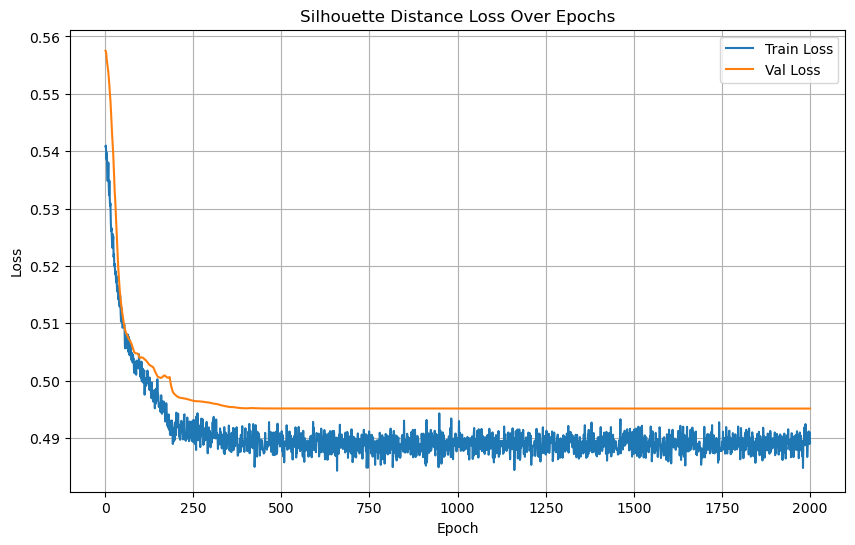

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/77], Loss: 0.3847
Test Batch [20/77], Loss: 0.0632


Test Batch [30/77], Loss: 0.1659
Test Batch [40/77], Loss: 0.5000
Test Batch [50/77], Loss: 0.2145
Test Batch [60/77], Loss: 0.3724


Test Batch [70/77], Loss: 0.5000

Test Loss: 0.3295


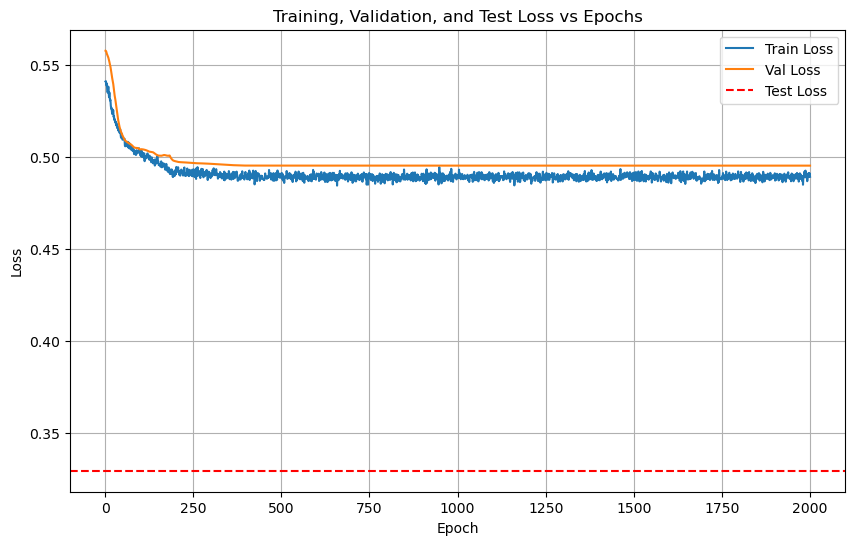

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/77 for test dataset.
  Processed batch 20/77 for test dataset.


  Processed batch 30/77 for test dataset.


  Processed batch 40/77 for test dataset.
  Processed batch 50/77 for test dataset.
  Processed batch 60/77 for test dataset.


  Processed batch 70/77 for test dataset.


Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (260, 128)
Train labels shape: (260,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4886, 128)
Test labels shape: (4886,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 46.15%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.40      0.36         5
           1       0.25      0.20      0.22         5
           2       0.25      0.20      0.22         5
           3       0.33      0.20      0.25         5
           4       0.60      0.60      0.60         5
           5       0.67      0.40      0.50         5
           6       0.56      1.00      0.71         5
           7       0.20      0.20      0.20         5
           8       0.31      0.80      0.44         5
           9       0.00      0.00      0.00         5
          10       1.00      0.80      0.89         5
          11       0.50      0.40      0.44         5
          12       0.80      0.80      0.80         5

    accuracy         

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (260, 128)
Train labels shape: (260,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4886, 128)
Test labels shape: (4886,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6325  |  Val Loss: 2.6039
Validation loss improved from inf to 2.6039.
[Epoch 2/1000] Train Loss: 2.6215  |  Val Loss: 2.5985
Validation loss improved from 2.6039 to 2.5985.
[Epoch 3/1000] Train Loss: 2.6105  |  Val Loss: 2.5936
Validation loss improved from 2.5985 to 2.5936.
[Epoch 4/1000] Train Loss: 2.6022  |  Val Loss: 2.5891
Validation loss improved from 2.5936 to 2.5891.
[Epoch 5/1000] Train Loss: 2.5935  |  Val Loss: 2.5849
Validation loss improved from 2.5891 to 2.5849.
[Epoch 6/1000] Train Loss: 2.5853  |  Val Loss: 2.5807
Validation loss improved from 2.5849 to 2.5807.
[Epoch 7/1000] Train Loss: 2.5780  |  Val Loss: 2.5770
Validation loss improved from 2.5807 to 2.5770.
[Epoch 8/1000] Train Loss: 2.5696  |  Val Loss: 2.5739
Validation loss improved from 2.5770 to 2.5739.
[Epoch 9/1000] Train Loss: 2.5629  |  Val Loss: 2.5711
Validation loss improved from 2.5739 to 2.5711.


[Epoch 10/1000] Train Loss: 2.5566  |  Val Loss: 2.5683
Validation loss improved from 2.5711 to 2.5683.
[Epoch 11/1000] Train Loss: 2.5512  |  Val Loss: 2.5656
Validation loss improved from 2.5683 to 2.5656.
[Epoch 12/1000] Train Loss: 2.5457  |  Val Loss: 2.5634
Validation loss improved from 2.5656 to 2.5634.
[Epoch 13/1000] Train Loss: 2.5405  |  Val Loss: 2.5616
Validation loss improved from 2.5634 to 2.5616.
[Epoch 14/1000] Train Loss: 2.5353  |  Val Loss: 2.5596
Validation loss improved from 2.5616 to 2.5596.
[Epoch 15/1000] Train Loss: 2.5303  |  Val Loss: 2.5573
Validation loss improved from 2.5596 to 2.5573.


[Epoch 16/1000] Train Loss: 2.5258  |  Val Loss: 2.5552
Validation loss improved from 2.5573 to 2.5552.
[Epoch 17/1000] Train Loss: 2.5212  |  Val Loss: 2.5533
Validation loss improved from 2.5552 to 2.5533.
[Epoch 18/1000] Train Loss: 2.5171  |  Val Loss: 2.5512
Validation loss improved from 2.5533 to 2.5512.
[Epoch 19/1000] Train Loss: 2.5126  |  Val Loss: 2.5487
Validation loss improved from 2.5512 to 2.5487.
[Epoch 20/1000] Train Loss: 2.5088  |  Val Loss: 2.5466
Validation loss improved from 2.5487 to 2.5466.


[Epoch 21/1000] Train Loss: 2.5045  |  Val Loss: 2.5449
Validation loss improved from 2.5466 to 2.5449.
[Epoch 22/1000] Train Loss: 2.5004  |  Val Loss: 2.5435
Validation loss improved from 2.5449 to 2.5435.
[Epoch 23/1000] Train Loss: 2.4964  |  Val Loss: 2.5421
Validation loss improved from 2.5435 to 2.5421.
[Epoch 24/1000] Train Loss: 2.4926  |  Val Loss: 2.5406
Validation loss improved from 2.5421 to 2.5406.
[Epoch 25/1000] Train Loss: 2.4891  |  Val Loss: 2.5390
Validation loss improved from 2.5406 to 2.5390.
[Epoch 26/1000] Train Loss: 2.4853  |  Val Loss: 2.5375
Validation loss improved from 2.5390 to 2.5375.
[Epoch 27/1000] Train Loss: 2.4816  |  Val Loss: 2.5353
Validation loss improved from 2.5375 to 2.5353.
[Epoch 28/1000] Train Loss: 2.4773  |  Val Loss: 2.5327
Validation loss improved from 2.5353 to 2.5327.
[Epoch 29/1000] Train Loss: 2.4735  |  Val Loss: 2.5305
Validation loss improved from 2.5327 to 2.5305.


[Epoch 30/1000] Train Loss: 2.4696  |  Val Loss: 2.5284
Validation loss improved from 2.5305 to 2.5284.
[Epoch 31/1000] Train Loss: 2.4654  |  Val Loss: 2.5264
Validation loss improved from 2.5284 to 2.5264.
[Epoch 32/1000] Train Loss: 2.4617  |  Val Loss: 2.5246
Validation loss improved from 2.5264 to 2.5246.
[Epoch 33/1000] Train Loss: 2.4573  |  Val Loss: 2.5229
Validation loss improved from 2.5246 to 2.5229.
[Epoch 34/1000] Train Loss: 2.4533  |  Val Loss: 2.5215
Validation loss improved from 2.5229 to 2.5215.
[Epoch 35/1000] Train Loss: 2.4484  |  Val Loss: 2.5200
Validation loss improved from 2.5215 to 2.5200.
[Epoch 36/1000] Train Loss: 2.4441  |  Val Loss: 2.5180
Validation loss improved from 2.5200 to 2.5180.
[Epoch 37/1000] Train Loss: 2.4401  |  Val Loss: 2.5159
Validation loss improved from 2.5180 to 2.5159.


[Epoch 38/1000] Train Loss: 2.4356  |  Val Loss: 2.5143
Validation loss improved from 2.5159 to 2.5143.
[Epoch 39/1000] Train Loss: 2.4315  |  Val Loss: 2.5131
Validation loss improved from 2.5143 to 2.5131.
[Epoch 40/1000] Train Loss: 2.4268  |  Val Loss: 2.5116
Validation loss improved from 2.5131 to 2.5116.
[Epoch 41/1000] Train Loss: 2.4224  |  Val Loss: 2.5094
Validation loss improved from 2.5116 to 2.5094.


[Epoch 42/1000] Train Loss: 2.4176  |  Val Loss: 2.5074
Validation loss improved from 2.5094 to 2.5074.
[Epoch 43/1000] Train Loss: 2.4127  |  Val Loss: 2.5057
Validation loss improved from 2.5074 to 2.5057.
[Epoch 44/1000] Train Loss: 2.4073  |  Val Loss: 2.5042
Validation loss improved from 2.5057 to 2.5042.
[Epoch 45/1000] Train Loss: 2.4025  |  Val Loss: 2.5027
Validation loss improved from 2.5042 to 2.5027.
[Epoch 46/1000] Train Loss: 2.3974  |  Val Loss: 2.5005
Validation loss improved from 2.5027 to 2.5005.
[Epoch 47/1000] Train Loss: 2.3927  |  Val Loss: 2.4993
Validation loss improved from 2.5005 to 2.4993.
[Epoch 48/1000] Train Loss: 2.3874  |  Val Loss: 2.4979
Validation loss improved from 2.4993 to 2.4979.
[Epoch 49/1000] Train Loss: 2.3827  |  Val Loss: 2.4966
Validation loss improved from 2.4979 to 2.4966.
[Epoch 50/1000] Train Loss: 2.3778  |  Val Loss: 2.4951
Validation loss improved from 2.4966 to 2.4951.


[Epoch 51/1000] Train Loss: 2.3725  |  Val Loss: 2.4938
Validation loss improved from 2.4951 to 2.4938.
[Epoch 52/1000] Train Loss: 2.3676  |  Val Loss: 2.4925
Validation loss improved from 2.4938 to 2.4925.
[Epoch 53/1000] Train Loss: 2.3627  |  Val Loss: 2.4915
Validation loss improved from 2.4925 to 2.4915.
[Epoch 54/1000] Train Loss: 2.3576  |  Val Loss: 2.4909
Validation loss improved from 2.4915 to 2.4909.
[Epoch 55/1000] Train Loss: 2.3518  |  Val Loss: 2.4901
Validation loss improved from 2.4909 to 2.4901.
[Epoch 56/1000] Train Loss: 2.3467  |  Val Loss: 2.4892
Validation loss improved from 2.4901 to 2.4892.
[Epoch 57/1000] Train Loss: 2.3416  |  Val Loss: 2.4877
Validation loss improved from 2.4892 to 2.4877.
[Epoch 58/1000] Train Loss: 2.3367  |  Val Loss: 2.4864
Validation loss improved from 2.4877 to 2.4864.


[Epoch 59/1000] Train Loss: 2.3320  |  Val Loss: 2.4851
Validation loss improved from 2.4864 to 2.4851.
[Epoch 60/1000] Train Loss: 2.3273  |  Val Loss: 2.4847
Validation loss improved from 2.4851 to 2.4847.
[Epoch 61/1000] Train Loss: 2.3225  |  Val Loss: 2.4850
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 62/1000] Train Loss: 2.3180  |  Val Loss: 2.4842
Validation loss improved from 2.4847 to 2.4842.
[Epoch 63/1000] Train Loss: 2.3131  |  Val Loss: 2.4824
Validation loss improved from 2.4842 to 2.4824.
[Epoch 64/1000] Train Loss: 2.3089  |  Val Loss: 2.4795
Validation loss improved from 2.4824 to 2.4795.
[Epoch 65/1000] Train Loss: 2.3040  |  Val Loss: 2.4768
Validation loss improved from 2.4795 to 2.4768.
[Epoch 66/1000] Train Loss: 2.2993  |  Val Loss: 2.4730
Validation loss improved from 2.4768 to 2.4730.
[Epoch 67/1000] Train Loss: 2.2949  |  Val Loss: 2.4701
Validation loss improved from 2.4730 to 2.4701.
[Epoch 68/1000] Train Loss: 2.2906  |  Val Loss: 2.4673
Va

[Epoch 69/1000] Train Loss: 2.2865  |  Val Loss: 2.4652
Validation loss improved from 2.4673 to 2.4652.
[Epoch 70/1000] Train Loss: 2.2820  |  Val Loss: 2.4633
Validation loss improved from 2.4652 to 2.4633.
[Epoch 71/1000] Train Loss: 2.2776  |  Val Loss: 2.4613
Validation loss improved from 2.4633 to 2.4613.
[Epoch 72/1000] Train Loss: 2.2730  |  Val Loss: 2.4599
Validation loss improved from 2.4613 to 2.4599.
[Epoch 73/1000] Train Loss: 2.2686  |  Val Loss: 2.4587
Validation loss improved from 2.4599 to 2.4587.
[Epoch 74/1000] Train Loss: 2.2642  |  Val Loss: 2.4573
Validation loss improved from 2.4587 to 2.4573.
[Epoch 75/1000] Train Loss: 2.2598  |  Val Loss: 2.4569
Validation loss improved from 2.4573 to 2.4569.
[Epoch 76/1000] Train Loss: 2.2550  |  Val Loss: 2.4566
Validation loss improved from 2.4569 to 2.4566.
[Epoch 77/1000] Train Loss: 2.2501  |  Val Loss: 2.4552
Validation loss improved from 2.4566 to 2.4552.


[Epoch 78/1000] Train Loss: 2.2459  |  Val Loss: 2.4533
Validation loss improved from 2.4552 to 2.4533.
[Epoch 79/1000] Train Loss: 2.2408  |  Val Loss: 2.4516
Validation loss improved from 2.4533 to 2.4516.
[Epoch 80/1000] Train Loss: 2.2361  |  Val Loss: 2.4509
Validation loss improved from 2.4516 to 2.4509.
[Epoch 81/1000] Train Loss: 2.2314  |  Val Loss: 2.4494
Validation loss improved from 2.4509 to 2.4494.
[Epoch 82/1000] Train Loss: 2.2264  |  Val Loss: 2.4474
Validation loss improved from 2.4494 to 2.4474.
[Epoch 83/1000] Train Loss: 2.2218  |  Val Loss: 2.4442
Validation loss improved from 2.4474 to 2.4442.
[Epoch 84/1000] Train Loss: 2.2167  |  Val Loss: 2.4414
Validation loss improved from 2.4442 to 2.4414.
[Epoch 85/1000] Train Loss: 2.2117  |  Val Loss: 2.4392
Validation loss improved from 2.4414 to 2.4392.


[Epoch 86/1000] Train Loss: 2.2066  |  Val Loss: 2.4386
Validation loss improved from 2.4392 to 2.4386.
[Epoch 87/1000] Train Loss: 2.2021  |  Val Loss: 2.4373
Validation loss improved from 2.4386 to 2.4373.
[Epoch 88/1000] Train Loss: 2.1973  |  Val Loss: 2.4350
Validation loss improved from 2.4373 to 2.4350.
[Epoch 89/1000] Train Loss: 2.1925  |  Val Loss: 2.4319
Validation loss improved from 2.4350 to 2.4319.
[Epoch 90/1000] Train Loss: 2.1874  |  Val Loss: 2.4287
Validation loss improved from 2.4319 to 2.4287.
[Epoch 91/1000] Train Loss: 2.1826  |  Val Loss: 2.4252
Validation loss improved from 2.4287 to 2.4252.
[Epoch 92/1000] Train Loss: 2.1772  |  Val Loss: 2.4215
Validation loss improved from 2.4252 to 2.4215.
[Epoch 93/1000] Train Loss: 2.1722  |  Val Loss: 2.4177
Validation loss improved from 2.4215 to 2.4177.
[Epoch 94/1000] Train Loss: 2.1670  |  Val Loss: 2.4142
Validation loss improved from 2.4177 to 2.4142.


[Epoch 95/1000] Train Loss: 2.1615  |  Val Loss: 2.4114
Validation loss improved from 2.4142 to 2.4114.
[Epoch 96/1000] Train Loss: 2.1559  |  Val Loss: 2.4070
Validation loss improved from 2.4114 to 2.4070.
[Epoch 97/1000] Train Loss: 2.1508  |  Val Loss: 2.4041
Validation loss improved from 2.4070 to 2.4041.
[Epoch 98/1000] Train Loss: 2.1454  |  Val Loss: 2.4015
Validation loss improved from 2.4041 to 2.4015.
[Epoch 99/1000] Train Loss: 2.1404  |  Val Loss: 2.4005
Validation loss improved from 2.4015 to 2.4005.
[Epoch 100/1000] Train Loss: 2.1351  |  Val Loss: 2.3982
Validation loss improved from 2.4005 to 2.3982.
[Epoch 101/1000] Train Loss: 2.1300  |  Val Loss: 2.3938
Validation loss improved from 2.3982 to 2.3938.
[Epoch 102/1000] Train Loss: 2.1257  |  Val Loss: 2.3903
Validation loss improved from 2.3938 to 2.3903.
[Epoch 103/1000] Train Loss: 2.1204  |  Val Loss: 2.3878
Validation loss improved from 2.3903 to 2.3878.
[Epoch 104/1000] Train Loss: 2.1154  |  Val Loss: 2.3847
Val

[Epoch 105/1000] Train Loss: 2.1099  |  Val Loss: 2.3819
Validation loss improved from 2.3847 to 2.3819.
[Epoch 106/1000] Train Loss: 2.1044  |  Val Loss: 2.3795
Validation loss improved from 2.3819 to 2.3795.
[Epoch 107/1000] Train Loss: 2.0990  |  Val Loss: 2.3774
Validation loss improved from 2.3795 to 2.3774.
[Epoch 108/1000] Train Loss: 2.0938  |  Val Loss: 2.3762
Validation loss improved from 2.3774 to 2.3762.
[Epoch 109/1000] Train Loss: 2.0883  |  Val Loss: 2.3735
Validation loss improved from 2.3762 to 2.3735.
[Epoch 110/1000] Train Loss: 2.0827  |  Val Loss: 2.3707
Validation loss improved from 2.3735 to 2.3707.
[Epoch 111/1000] Train Loss: 2.0772  |  Val Loss: 2.3677
Validation loss improved from 2.3707 to 2.3677.
[Epoch 112/1000] Train Loss: 2.0713  |  Val Loss: 2.3649
Validation loss improved from 2.3677 to 2.3649.
[Epoch 113/1000] Train Loss: 2.0652  |  Val Loss: 2.3620
Validation loss improved from 2.3649 to 2.3620.
[Epoch 114/1000] Train Loss: 2.0599  |  Val Loss: 2.361

[Epoch 115/1000] Train Loss: 2.0546  |  Val Loss: 2.3599
Validation loss improved from 2.3610 to 2.3599.
[Epoch 116/1000] Train Loss: 2.0493  |  Val Loss: 2.3576
Validation loss improved from 2.3599 to 2.3576.
[Epoch 117/1000] Train Loss: 2.0441  |  Val Loss: 2.3553
Validation loss improved from 2.3576 to 2.3553.
[Epoch 118/1000] Train Loss: 2.0390  |  Val Loss: 2.3522
Validation loss improved from 2.3553 to 2.3522.
[Epoch 119/1000] Train Loss: 2.0341  |  Val Loss: 2.3501
Validation loss improved from 2.3522 to 2.3501.
[Epoch 120/1000] Train Loss: 2.0292  |  Val Loss: 2.3485
Validation loss improved from 2.3501 to 2.3485.
[Epoch 121/1000] Train Loss: 2.0240  |  Val Loss: 2.3461
Validation loss improved from 2.3485 to 2.3461.
[Epoch 122/1000] Train Loss: 2.0185  |  Val Loss: 2.3437
Validation loss improved from 2.3461 to 2.3437.
[Epoch 123/1000] Train Loss: 2.0126  |  Val Loss: 2.3415
Validation loss improved from 2.3437 to 2.3415.
[Epoch 124/1000] Train Loss: 2.0072  |  Val Loss: 2.338

[Epoch 127/1000] Train Loss: 1.9917  |  Val Loss: 2.3331
Validation loss improved from 2.3341 to 2.3331.
[Epoch 128/1000] Train Loss: 1.9863  |  Val Loss: 2.3314
Validation loss improved from 2.3331 to 2.3314.
[Epoch 129/1000] Train Loss: 1.9810  |  Val Loss: 2.3303
Validation loss improved from 2.3314 to 2.3303.
[Epoch 130/1000] Train Loss: 1.9758  |  Val Loss: 2.3291
Validation loss improved from 2.3303 to 2.3291.
[Epoch 131/1000] Train Loss: 1.9709  |  Val Loss: 2.3276
Validation loss improved from 2.3291 to 2.3276.
[Epoch 132/1000] Train Loss: 1.9660  |  Val Loss: 2.3254
Validation loss improved from 2.3276 to 2.3254.
[Epoch 133/1000] Train Loss: 1.9611  |  Val Loss: 2.3244
Validation loss improved from 2.3254 to 2.3244.
[Epoch 134/1000] Train Loss: 1.9555  |  Val Loss: 2.3231
Validation loss improved from 2.3244 to 2.3231.


[Epoch 135/1000] Train Loss: 1.9507  |  Val Loss: 2.3217
Validation loss improved from 2.3231 to 2.3217.
[Epoch 136/1000] Train Loss: 1.9451  |  Val Loss: 2.3188
Validation loss improved from 2.3217 to 2.3188.
[Epoch 137/1000] Train Loss: 1.9396  |  Val Loss: 2.3162
Validation loss improved from 2.3188 to 2.3162.
[Epoch 138/1000] Train Loss: 1.9347  |  Val Loss: 2.3130
Validation loss improved from 2.3162 to 2.3130.
[Epoch 139/1000] Train Loss: 1.9295  |  Val Loss: 2.3048
Validation loss improved from 2.3130 to 2.3048.
[Epoch 140/1000] Train Loss: 1.9254  |  Val Loss: 2.2989
Validation loss improved from 2.3048 to 2.2989.
[Epoch 141/1000] Train Loss: 1.9210  |  Val Loss: 2.2952
Validation loss improved from 2.2989 to 2.2952.
[Epoch 142/1000] Train Loss: 1.9163  |  Val Loss: 2.2943
Validation loss improved from 2.2952 to 2.2943.
[Epoch 143/1000] Train Loss: 1.9111  |  Val Loss: 2.2980
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 144/1000] Train Loss: 1.9060  |  Val Loss:

[Epoch 146/1000] Train Loss: 1.8966  |  Val Loss: 2.2984
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 147/1000] Train Loss: 1.8921  |  Val Loss: 2.2957
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 148/1000] Train Loss: 1.8874  |  Val Loss: 2.2925
Validation loss improved from 2.2943 to 2.2925.
[Epoch 149/1000] Train Loss: 1.8826  |  Val Loss: 2.2889
Validation loss improved from 2.2925 to 2.2889.
[Epoch 150/1000] Train Loss: 1.8781  |  Val Loss: 2.2860
Validation loss improved from 2.2889 to 2.2860.
[Epoch 151/1000] Train Loss: 1.8738  |  Val Loss: 2.2835
Validation loss improved from 2.2860 to 2.2835.
[Epoch 152/1000] Train Loss: 1.8695  |  Val Loss: 2.2810
Validation loss improved from 2.2835 to 2.2810.
[Epoch 153/1000] Train Loss: 1.8651  |  Val Loss: 2.2791
Validation loss improved from 2.2810 to 2.2791.


[Epoch 154/1000] Train Loss: 1.8607  |  Val Loss: 2.2775
Validation loss improved from 2.2791 to 2.2775.
[Epoch 155/1000] Train Loss: 1.8561  |  Val Loss: 2.2765
Validation loss improved from 2.2775 to 2.2765.
[Epoch 156/1000] Train Loss: 1.8514  |  Val Loss: 2.2739
Validation loss improved from 2.2765 to 2.2739.
[Epoch 157/1000] Train Loss: 1.8466  |  Val Loss: 2.2713
Validation loss improved from 2.2739 to 2.2713.
[Epoch 158/1000] Train Loss: 1.8420  |  Val Loss: 2.2687
Validation loss improved from 2.2713 to 2.2687.
[Epoch 159/1000] Train Loss: 1.8372  |  Val Loss: 2.2661
Validation loss improved from 2.2687 to 2.2661.
[Epoch 160/1000] Train Loss: 1.8330  |  Val Loss: 2.2636
Validation loss improved from 2.2661 to 2.2636.
[Epoch 161/1000] Train Loss: 1.8285  |  Val Loss: 2.2606
Validation loss improved from 2.2636 to 2.2606.
[Epoch 162/1000] Train Loss: 1.8239  |  Val Loss: 2.2583
Validation loss improved from 2.2606 to 2.2583.
[Epoch 163/1000] Train Loss: 1.8197  |  Val Loss: 2.256

[Epoch 166/1000] Train Loss: 1.8071  |  Val Loss: 2.2515
Validation loss improved from 2.2525 to 2.2515.
[Epoch 167/1000] Train Loss: 1.8027  |  Val Loss: 2.2483
Validation loss improved from 2.2515 to 2.2483.
[Epoch 168/1000] Train Loss: 1.7987  |  Val Loss: 2.2451
Validation loss improved from 2.2483 to 2.2451.
[Epoch 169/1000] Train Loss: 1.7945  |  Val Loss: 2.2429
Validation loss improved from 2.2451 to 2.2429.
[Epoch 170/1000] Train Loss: 1.7902  |  Val Loss: 2.2438
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 171/1000] Train Loss: 1.7862  |  Val Loss: 2.2442
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 172/1000] Train Loss: 1.7820  |  Val Loss: 2.2430
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 173/1000] Train Loss: 1.7770  |  Val Loss: 2.2393
Validation loss improved from 2.2429 to 2.2393.
[Epoch 174/1000] Train Loss: 1.7724  |  Val Loss: 2.2355
Validation loss improved from 2.2393 to 2.2355.
[Epoch 175/1000] Train Loss: 1.7677  |  Val Loss: 2.2321
Validation loss improved from 2.2355 to 2.2321.
[Epoch 176/1000] Train Loss: 1.7637  |  Val Loss: 2.2223
Validation loss improved from 2.2321 to 2.2223.
[Epoch 177/1000] Train Loss: 1.7602  |  Val Loss: 2.2194
Validation loss improved from 2.2223 to 2.2194.
[Epoch 178/1000] Train Loss: 1.7574  |  Val Loss: 2.2212
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 179/1000] Train Loss: 1.7529  |  Val Loss: 2.2264
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 180/1000] Train Loss: 1.7491  |  Val Loss: 2.2312
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 181/1000] Train Loss: 1.7443  |  Val Loss: 2.2314
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 182/1000] Train Loss: 1.

[Epoch 184/1000] Train Loss: 1.7309  |  Val Loss: 2.2259
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 185/1000] Train Loss: 1.7265  |  Val Loss: 2.2259
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 186/1000] Train Loss: 1.7223  |  Val Loss: 2.2275
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 187/1000] Train Loss: 1.7188  |  Val Loss: 2.2283
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 188/1000] Train Loss: 1.7147  |  Val Loss: 2.2298
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 189/1000] Train Loss: 1.7106  |  Val Loss: 2.2295
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 190/1000] Train Loss: 1.7066  |  Val Loss: 2.2284
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 191/1000] Train Loss: 1.7027  |  Val Loss: 2.2267
!! Validation loss did NOT improve !! Patience: 14/100


[Epoch 192/1000] Train Loss: 1.6986  |  Val Loss: 2.2232
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 193/1000] Train Loss: 1.6944  |  Val Loss: 2.2131
Validation loss improved from 2.2194 to 2.2131.
[Epoch 194/1000] Train Loss: 1.6909  |  Val Loss: 2.2076
Validation loss improved from 2.2131 to 2.2076.
[Epoch 195/1000] Train Loss: 1.6876  |  Val Loss: 2.2052
Validation loss improved from 2.2076 to 2.2052.
[Epoch 196/1000] Train Loss: 1.6836  |  Val Loss: 2.2048
Validation loss improved from 2.2052 to 2.2048.
[Epoch 197/1000] Train Loss: 1.6795  |  Val Loss: 2.2053
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 198/1000] Train Loss: 1.6753  |  Val Loss: 2.2055
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 199/1000] Train Loss: 1.6713  |  Val Loss: 2.2070
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 200/1000] Train Loss: 1.6664  |  Val Loss: 2.2120
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 201/1000] Train L

[Epoch 206/1000] Train Loss: 1.6424  |  Val Loss: 2.2257
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 207/1000] Train Loss: 1.6387  |  Val Loss: 2.2267
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 208/1000] Train Loss: 1.6344  |  Val Loss: 2.2252
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 209/1000] Train Loss: 1.6307  |  Val Loss: 2.2235
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 210/1000] Train Loss: 1.6269  |  Val Loss: 2.2206
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 211/1000] Train Loss: 1.6225  |  Val Loss: 2.2174
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 212/1000] Train Loss: 1.6183  |  Val Loss: 2.2129
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 213/1000] Train Loss: 1.6141  |  Val Loss: 2.2095
!! Validation loss did NOT improve !! Patience: 17/100


[Epoch 214/1000] Train Loss: 1.6102  |  Val Loss: 2.2079
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 215/1000] Train Loss: 1.6061  |  Val Loss: 2.2087
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 216/1000] Train Loss: 1.6023  |  Val Loss: 2.2106
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 217/1000] Train Loss: 1.5982  |  Val Loss: 2.2122
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 218/1000] Train Loss: 1.5949  |  Val Loss: 2.2107
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 219/1000] Train Loss: 1.5913  |  Val Loss: 2.2094
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 220/1000] Train Loss: 1.5879  |  Val Loss: 2.2078
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 221/1000] Train Loss: 1.5834  |  Val Loss: 2.2065
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 222/1000] Train Loss: 1.5788  |  Val Loss: 2.2047
Validation loss improved from 2.2048 to 2.2047.

[Epoch 227/1000] Train Loss: 1.5582  |  Val Loss: 2.1980
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 228/1000] Train Loss: 1.5545  |  Val Loss: 2.2015
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 229/1000] Train Loss: 1.5507  |  Val Loss: 2.2015
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 230/1000] Train Loss: 1.5470  |  Val Loss: 2.2022
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 231/1000] Train Loss: 1.5430  |  Val Loss: 2.1998
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 232/1000] Train Loss: 1.5390  |  Val Loss: 2.1973
Validation loss improved from 2.1974 to 2.1973.
[Epoch 233/1000] Train Loss: 1.5353  |  Val Loss: 2.1971
Validation loss improved from 2.1973 to 2.1971.


[Epoch 234/1000] Train Loss: 1.5316  |  Val Loss: 2.1982
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 235/1000] Train Loss: 1.5279  |  Val Loss: 2.1992
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 236/1000] Train Loss: 1.5239  |  Val Loss: 2.2027
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 237/1000] Train Loss: 1.5204  |  Val Loss: 2.2041
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 238/1000] Train Loss: 1.5169  |  Val Loss: 2.2057
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 239/1000] Train Loss: 1.5130  |  Val Loss: 2.2050
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 240/1000] Train Loss: 1.5088  |  Val Loss: 2.2058
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 241/1000] Train Loss: 1.5048  |  Val Loss: 2.2047
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 242/1000] Train Loss: 1.5011  |  Val Loss: 2.2031
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 247/1000] Train Loss: 1.4830  |  Val Loss: 2.2041
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 248/1000] Train Loss: 1.4791  |  Val Loss: 2.2020
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 249/1000] Train Loss: 1.4750  |  Val Loss: 2.1999
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 250/1000] Train Loss: 1.4710  |  Val Loss: 2.2001
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 251/1000] Train Loss: 1.4675  |  Val Loss: 2.2015
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 252/1000] Train Loss: 1.4638  |  Val Loss: 2.2017
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 253/1000] Train Loss: 1.4603  |  Val Loss: 2.2031
!! Validation loss did NOT improve !! Patience: 20/100


[Epoch 254/1000] Train Loss: 1.4573  |  Val Loss: 2.2060
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 255/1000] Train Loss: 1.4543  |  Val Loss: 2.2094
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 256/1000] Train Loss: 1.4512  |  Val Loss: 2.2155
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 257/1000] Train Loss: 1.4476  |  Val Loss: 2.2179
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 258/1000] Train Loss: 1.4447  |  Val Loss: 2.2206
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 259/1000] Train Loss: 1.4412  |  Val Loss: 2.2198
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 260/1000] Train Loss: 1.4379  |  Val Loss: 2.2201
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 261/1000] Train Loss: 1.4351  |  Val Loss: 2.2206
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 262/1000] Train Loss: 1.4313  |  Val Loss: 2.2200
!! Validation loss did NOT improve !! Patience:

[Epoch 265/1000] Train Loss: 1.4199  |  Val Loss: 2.2152
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 266/1000] Train Loss: 1.4170  |  Val Loss: 2.2175
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 267/1000] Train Loss: 1.4136  |  Val Loss: 2.2162
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 268/1000] Train Loss: 1.4106  |  Val Loss: 2.2198
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 269/1000] Train Loss: 1.4076  |  Val Loss: 2.2218
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 270/1000] Train Loss: 1.4042  |  Val Loss: 2.2237
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 271/1000] Train Loss: 1.4010  |  Val Loss: 2.2285
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 272/1000] Train Loss: 1.3985  |  Val Loss: 2.2367
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 273/1000] Train Loss: 1.3959  |  Val Loss: 2.2243
!! Validation loss did NOT improve !! Patience:

[Epoch 274/1000] Train Loss: 1.3917  |  Val Loss: 2.2068
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 275/1000] Train Loss: 1.3893  |  Val Loss: 2.2032
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 276/1000] Train Loss: 1.3877  |  Val Loss: 2.2087
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 277/1000] Train Loss: 1.3842  |  Val Loss: 2.2145
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 278/1000] Train Loss: 1.3802  |  Val Loss: 2.2193
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 279/1000] Train Loss: 1.3757  |  Val Loss: 2.2237
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 280/1000] Train Loss: 1.3722  |  Val Loss: 2.2282
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 281/1000] Train Loss: 1.3690  |  Val Loss: 2.2326
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 282/1000] Train Loss: 1.3662  |  Val Loss: 2.2380
!! Validation loss did NOT improve !! Patience:

[Epoch 283/1000] Train Loss: 1.3634  |  Val Loss: 2.2406
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 284/1000] Train Loss: 1.3600  |  Val Loss: 2.2374
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 285/1000] Train Loss: 1.3567  |  Val Loss: 2.2327
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 286/1000] Train Loss: 1.3535  |  Val Loss: 2.2275
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 287/1000] Train Loss: 1.3510  |  Val Loss: 2.2240
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 288/1000] Train Loss: 1.3481  |  Val Loss: 2.2218
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 289/1000] Train Loss: 1.3456  |  Val Loss: 2.2230
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 290/1000] Train Loss: 1.3422  |  Val Loss: 2.2272
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 291/1000] Train Loss: 1.3391  |  Val Loss: 2.2284
!! Validation loss did NOT improve !! Patience:

[Epoch 295/1000] Train Loss: 1.3290  |  Val Loss: 2.2246
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 296/1000] Train Loss: 1.3263  |  Val Loss: 2.2271
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 297/1000] Train Loss: 1.3233  |  Val Loss: 2.2319
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 298/1000] Train Loss: 1.3205  |  Val Loss: 2.2381
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 299/1000] Train Loss: 1.3179  |  Val Loss: 2.2450
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 300/1000] Train Loss: 1.3159  |  Val Loss: 2.2486
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 301/1000] Train Loss: 1.3134  |  Val Loss: 2.2481
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 302/1000] Train Loss: 1.3110  |  Val Loss: 2.2487
!! Validation loss did NOT improve !! Patience: 69/100


[Epoch 303/1000] Train Loss: 1.3086  |  Val Loss: 2.2477
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 304/1000] Train Loss: 1.3055  |  Val Loss: 2.2426
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 305/1000] Train Loss: 1.3022  |  Val Loss: 2.2379
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 306/1000] Train Loss: 1.2996  |  Val Loss: 2.2350
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 307/1000] Train Loss: 1.2970  |  Val Loss: 2.2330
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 308/1000] Train Loss: 1.2940  |  Val Loss: 2.2331
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 309/1000] Train Loss: 1.2913  |  Val Loss: 2.2348
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 310/1000] Train Loss: 1.2886  |  Val Loss: 2.2373
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 311/1000] Train Loss: 1.2857  |  Val Loss: 2.2421
!! Validation loss did NOT improve !! Patience:

[Epoch 316/1000] Train Loss: 1.2732  |  Val Loss: 2.2478
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 317/1000] Train Loss: 1.2707  |  Val Loss: 2.2489
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 318/1000] Train Loss: 1.2683  |  Val Loss: 2.2492
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 319/1000] Train Loss: 1.2657  |  Val Loss: 2.2490
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 320/1000] Train Loss: 1.2633  |  Val Loss: 2.2488
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 321/1000] Train Loss: 1.2617  |  Val Loss: 2.2507
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 322/1000] Train Loss: 1.2597  |  Val Loss: 2.2506
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 323/1000] Train Loss: 1.2568  |  Val Loss: 2.2492
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 324/1000] Train Loss: 1.2542  |  Val Loss: 2.2522
!! Validation loss did NOT improve !! Patience:

[Epoch 325/1000] Train Loss: 1.2510  |  Val Loss: 2.2653
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 326/1000] Train Loss: 1.2498  |  Val Loss: 2.2754
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 327/1000] Train Loss: 1.2488  |  Val Loss: 2.2774
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 328/1000] Train Loss: 1.2464  |  Val Loss: 2.2732
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 329/1000] Train Loss: 1.2436  |  Val Loss: 2.2651
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 330/1000] Train Loss: 1.2407  |  Val Loss: 2.2631
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 331/1000] Train Loss: 1.2377  |  Val Loss: 2.2618
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 332/1000] Train Loss: 1.2352  |  Val Loss: 2.2608
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 333/1000] Train Loss: 1.2326  |  Val Loss: 2.2592
!! Validation loss did NOT improve !! Patience:

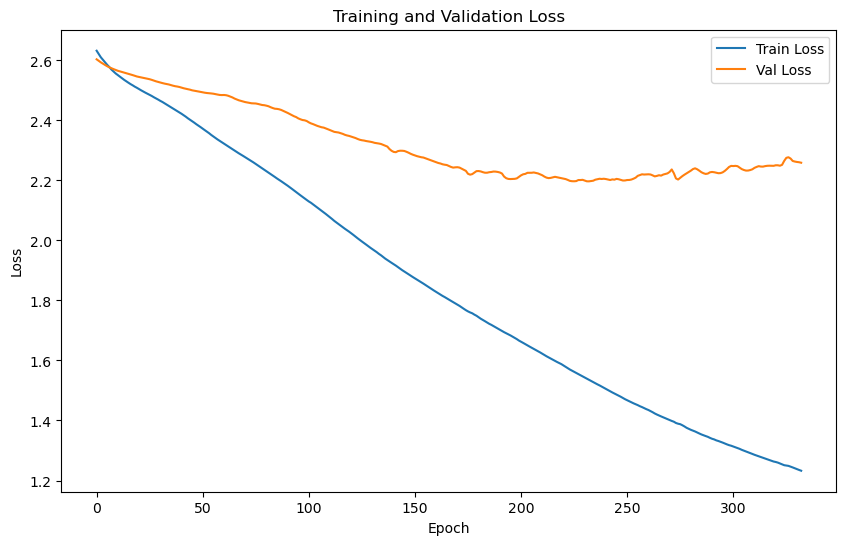

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.7148 | Test Accuracy: 52.17%


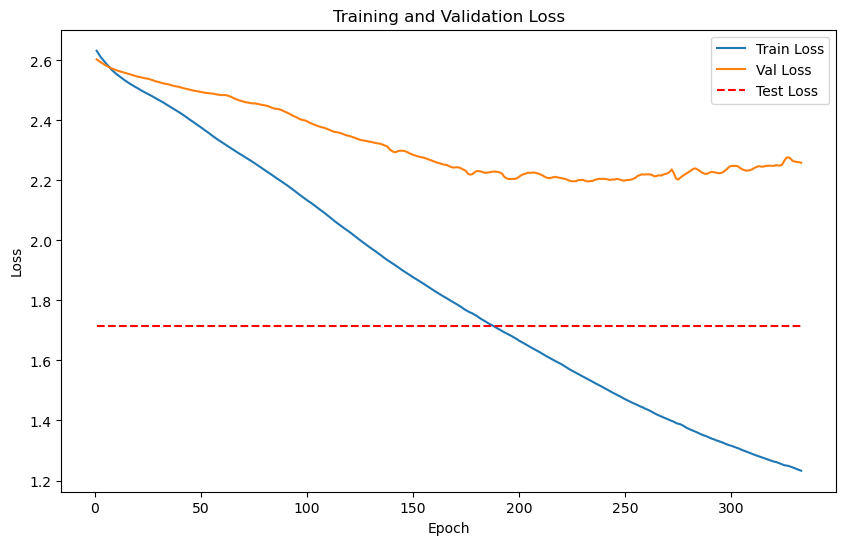

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


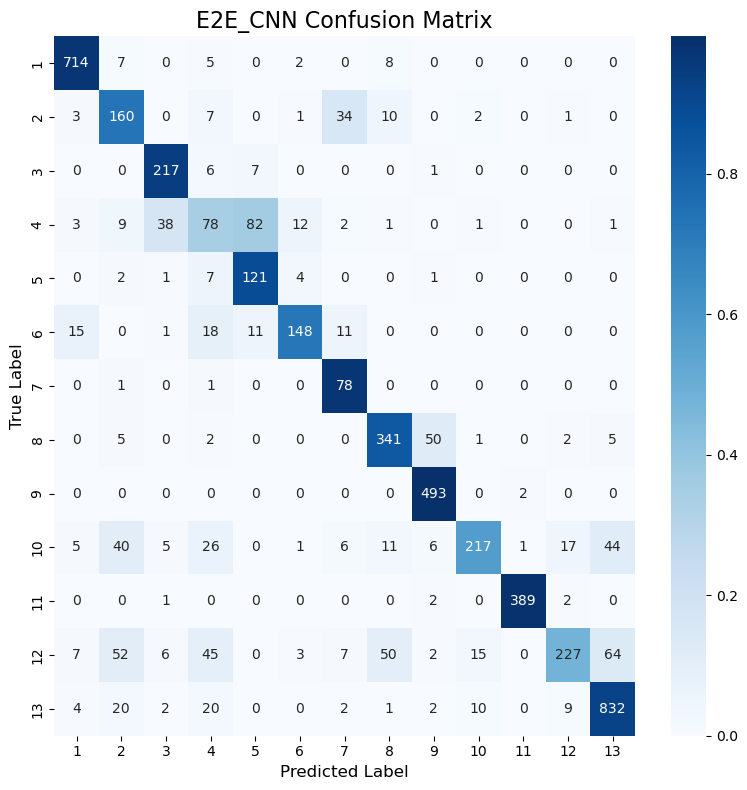

Classification Accuracy: 82.17%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


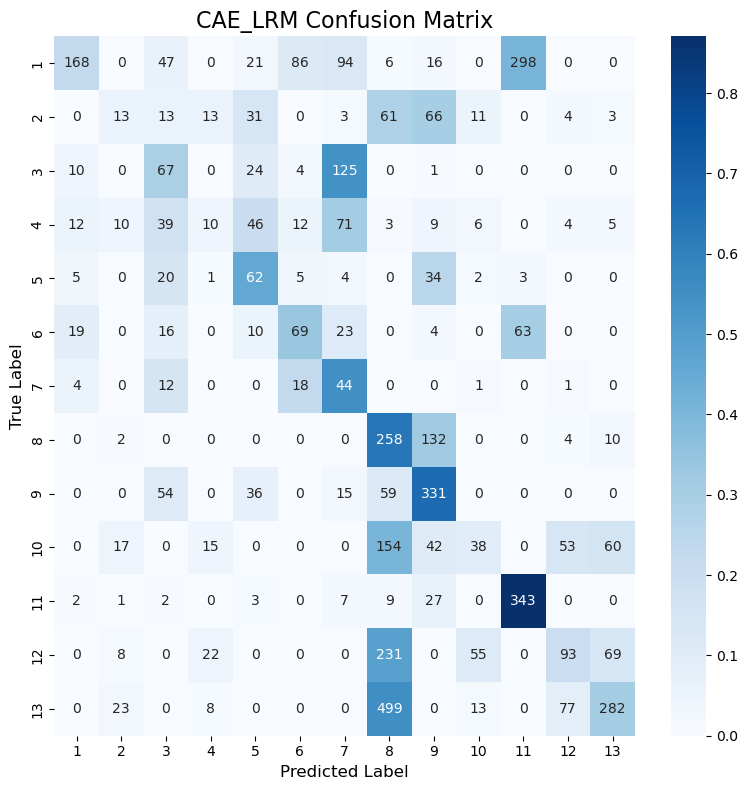

Classification Accuracy: 36.39%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


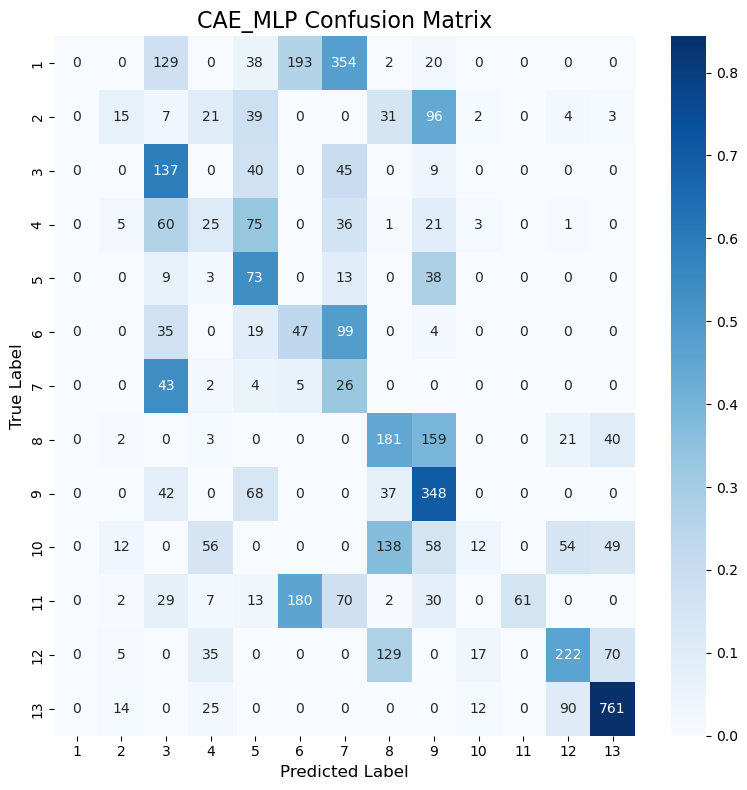

Classification Accuracy: 39.05%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


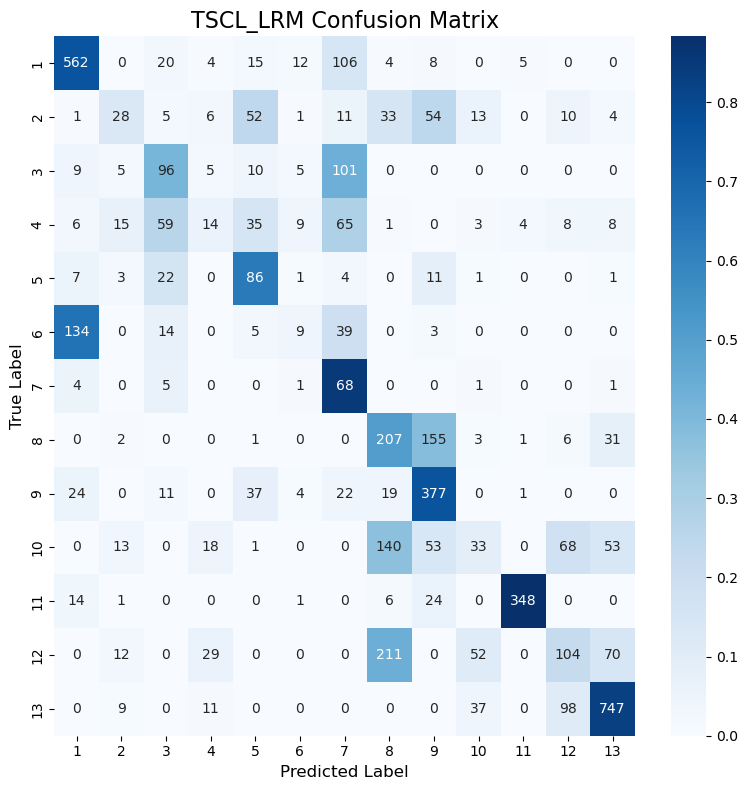

Classification Accuracy: 54.83%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


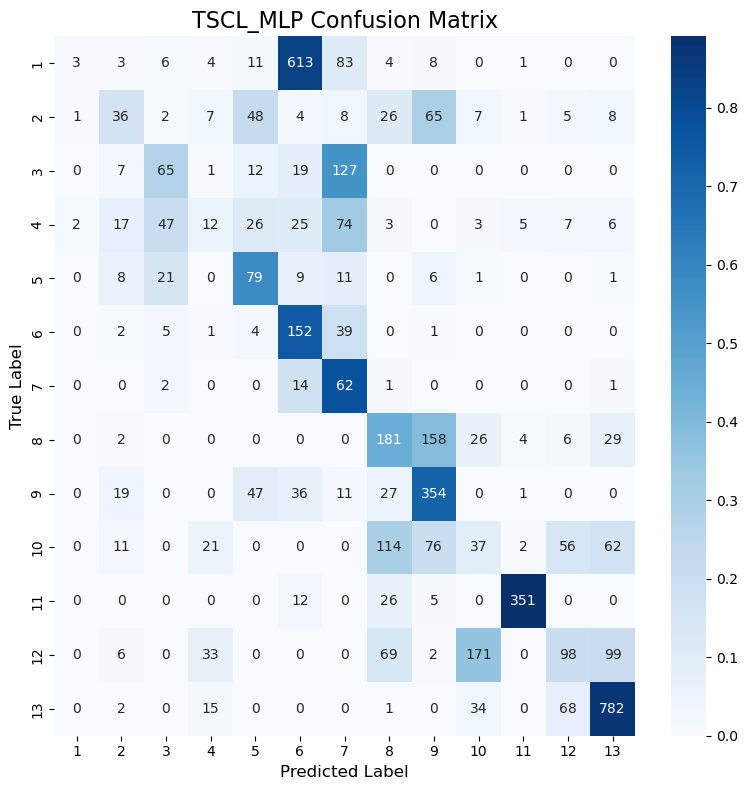

Classification Accuracy: 45.27%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


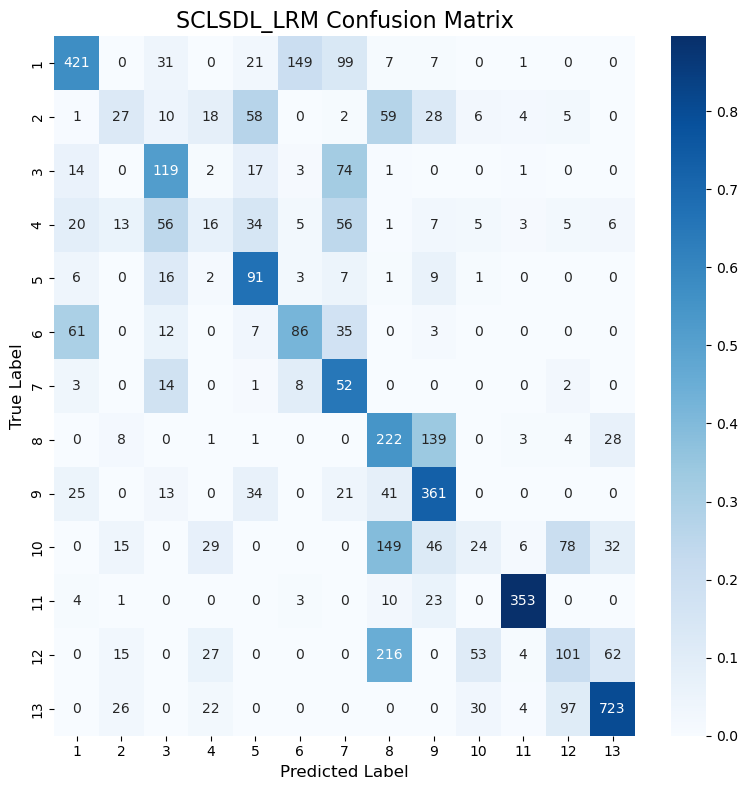

Classification Accuracy: 53.13%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


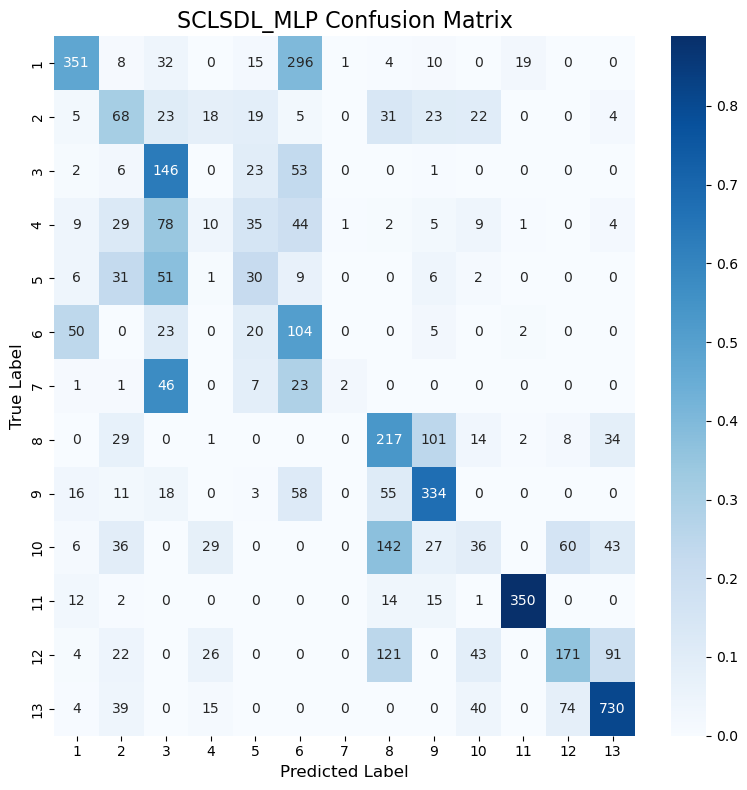

Classification Accuracy: 52.17%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          82.17
1    LRM (CAE)          36.39
2    MLP (CAE)          39.05
3     TSCL LRM          54.83
4     TSCL MLP          45.27
5  SCL_SDL LRM          53.13
6  SCL_SDL MLP          52.17

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          82.17
3     TSCL LRM          54.83
5  SCL_SDL LRM          53.13
6  SCL_SDL MLP          52.17
4     TSCL MLP          45.27
2    MLP (CAE)          39.05
1    LRM (CAE)          36.39
